This set of scripts loads photostim data, extracts amplitudes, then correlates things with things. :)

In [1]:
# basic libraries, variables and functions
%matplotlib inline
%load_ext autoreload
%autoreload 2
import BCI_analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import oasis
#mpld3.enable_notebook()

# - hard-coded variables - should go to a json file
local_temp_dir = '/home/jupyter/temp/' 
metadata_dir = '/home/jupyter/bucket/Metadata/' 
raw_scanimage_dir_base ='/home/jupyter/bucket/Data/Calcium_imaging/raw/' 
suite2p_dir_base = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/'
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters

setup = 'Bergamo-2P-Photostim'
sessionwise_path_base = "/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba"

# - convenience functions
def load_and_calculate_dff(directory,scalar_f0 = False,photostim = False,correct_offset = False,moving_average_window = np.nan):
    """
    """
    
    F = np.load(os.path.join(directory,'F.npy'))
    Fneu = np.load(os.path.join(directory,'Fneu.npy'))
    F0 = np.load(os.path.join(directory,'F0.npy'))
    
    if correct_offset:
        f0_correction_dict = np.load(os.path.join(directory,'channel_offset.npy'),allow_pickle=True).tolist()
        
        F+=f0_correction_dict['channel_offset']
        F0+=f0_correction_dict['channel_offset']
        Fneu+=f0_correction_dict['channel_offset']
        print('corrected offset: {}'.format(f0_correction_dict['channel_offset']))
    F0_scalar = np.nanmedian(F0,1)[:,np.newaxis]
    
    if photostim:
        ops =  np.load(os.path.join(directory,'ops.npy'),allow_pickle = True).tolist()
        F,Fneu = BCI_analysis.io_suite2p.remove_stim_artefacts(F,Fneu,ops['frames_per_file'])
    if scalar_f0:
        dFF = (F-F0_scalar)/F0_scalar
    else:
        dFF = (F-F0)/F0
    
    
    if np.isnan(moving_average_window):
        return dFF,F,F0,F0_scalar,Fneu
    else:
        try:
            photon_counts = np.load(os.path.join(directory,'photon_counts.npy'),allow_pickle= True).tolist()
        except:
            print('no photon counts file found, going a directory above')
            dir_now,_ = os.path.split(directory)
            photon_counts = np.load(os.path.join(dir_now,'photon_counts.npy'),allow_pickle= True).tolist()
        f0_photon_counts_per_roi = photon_counts['F0_photon_counts']*moving_average_window
        dFF_filt = []
        for f in dFF:
            dFF_filt.append(BCI_analysis.pipeline_utils.rollingfun(f,moving_average_window))
        dFF_filt = np.asarray(dFF_filt)
        signal_photon_count =(dFF_filt)*f0_photon_counts_per_roi[:,np.newaxis] 
        noise_photon_count = (dFF_filt+1)*f0_photon_counts_per_roi[:,np.newaxis]
        snr_trace = signal_photon_count/np.sqrt(noise_photon_count)
        return dFF,F,F0,F0_scalar,Fneu,snr_trace


/home/jupyter/Scripts/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
#### select subject, FOV, sessions
subject = 'BCI_34'
fov = 'FOV_03'#'FOV_01'
sessions = ['071322','071422']


# subject = 'BCI_29'
# fov = 'FOV_05'#'FOV_01'
# sessions = ['060722','060722']# same session twice lol

In [4]:
#### select cells that show any activity in both or either of the sessions
# this script uses the photon counts to estimate the proportion of the trace the cell is out of shot-noise regime
snr_cutoff = 3
activity_ratio_cutoff = 0.01#.01
stat = np.load(os.path.join(suite2p_dir_base,setup,subject,fov,'stat.npy'), allow_pickle = True).tolist()
snr_list = []
photon_counts_list_ = []
photon_counts_list = []
for session in sessions:
    scalar_f0 = False
    correct_offset = False
    session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
    photostim_dir = os.path.join(session_dir,'photostim')
    photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
    dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim,snr_trace = load_and_calculate_dff(photostim_dir,
                                                                                                                scalar_f0 = scalar_f0,
                                                                                                                photostim = True,
                                                                                                                correct_offset = correct_offset,
                                                                                                                moving_average_window = 4)
    snr_list.append(np.sum(snr_trace>10,1)/snr_trace.shape[1])
    
    try:
        photon_counts = np.load(os.path.join(photostim_dir,'photon_counts.npy'),allow_pickle= True).tolist()
    except:
        print('no photon counts file found, going a directory above')
        dir_now,_ = os.path.split(photostim_dir)
        photon_counts = np.load(os.path.join(dir_now,'photon_counts.npy'),allow_pickle= True).tolist()
    
    photon_counts_list_.append(photon_counts['F0_photon_counts'])
    
needed_cells_with_activity = np.where(np.max(snr_list,0)>=activity_ratio_cutoff)[0]



#####needed_cells_with_activity = np.arange(20)

for pc in photon_counts_list_:
    photon_counts_list.append(np.asarray(pc)[needed_cells_with_activity])
print('{} cells selected'.format(len(needed_cells_with_activity)))

stat = np.asarray(np.load(os.path.join(suite2p_dir_base,setup,subject,fov,'stat.npy'), allow_pickle = True).tolist())[needed_cells_with_activity]

photostim offset from trial start is 0 frames
no photon counts file found, going a directory above


/tmp/ipykernel_19059/1917253491.py:66: RuntimeWarning: invalid value encountered in sqrt
  snr_trace = signal_photon_count/np.sqrt(noise_photon_count)


no photon counts file found, going a directory above
photostim offset from trial start is 0 frames
no photon counts file found, going a directory above
no photon counts file found, going a directory above
236 cells selected


/tmp/ipykernel_19059/1917253491.py:66: RuntimeWarning: invalid value encountered in sqrt
  snr_trace = signal_photon_count/np.sqrt(noise_photon_count)


In [5]:
#### estimate time constants based on measured amplitudes

import random
import warnings
import multiprocessing as mp

correct_slow_drift = False # estimates slow linear drift over the whole session based on changes in F0
correct_tau = True # changes tau until the expeced AVERAGE amplitudes don't depend linearly on f0 anymore
tau_corr_cutoff = .01 # this is the maximum |correlation| that is accepted when correcting the tau
correct_with_running_F0 = True # uses the previously calculated F0 to correct for slow drifts
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

# parameters = {'bootstrap_n' : 50.
#               'bootstrap_r' : 1.0,
#               'dff_range' : [0,4],
#               'minimum_dff_max' : 2,
#               'bin_num' : 5,
#               'deconvolution_type' : 'oasis',
#               'correct_tau' : False,
#               'baseline_length' : 5,
#               'peak_length' : 5,
#               'offset' : 11, # frame offset where the amplitude will be measured
#               'tau_corr_cutoff' : .01}

def calculate_f0_tau(F_trace,F0):
    #print('cell started')
    
    # marton decay and F0 parameters
    bootstrap_n = 50 # 
    bootstrap_r = 1.0
    dff_range = [0,4]
    minimum_dff_max = 2
    bin_num = 5
    # marton decay and F0 parameters
    
    deconvolution_type = 'oasis'
    correct_tau = True
    baseline_length = 5
    peak_length = 5
    offset = 11 # frame offset where the amplitude will be measured
    tau_corr_cutoff = .01
    
    n_random_groups_per_stimgroup_per_cell = 50
    
    
    
    f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
    fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
    amplitudes_ = fpeak[offset:]-f0[:-offset]
    f0s_ = f0[:-offset]
    taus_bootstrap = []
    f0_bootstrap = []
    for bootstrap_i in range(bootstrap_n):
        indices = np.random.choice(np.arange(len(amplitudes_)),int(len(amplitudes_)*bootstrap_r))
        amplitudes = amplitudes_[indices]
        f0s = f0s_[indices]

        corrcoeff = 0
        diff_max_offset =0
        if minimum_dff_max<dff_range[1]+diff_max_offset:
            while corrcoeff <.975 and minimum_dff_max<dff_range[1]+diff_max_offset:
                x_range = np.percentile(f0s,[1,99])
                x_range[0] = np.max([F0*(dff_range[0]+1),x_range[0]])
                x_range[1] = np.min([F0*(dff_range[1]+diff_max_offset+1),x_range[1]])
                f0s_used = f0s[(f0s>x_range[0])&(f0s<x_range[1])]
                


                bin_mean = []
                bin_center = []
                bin_std = []
                bin_n = []
                if x_range[0]>x_range[1] or len(f0s_used)<100:
                    break # we break out of this loop if there are no values in the range..
                for bin_i in np.arange(bin_num):
                    min_x_val = x_range[0]+bin_i*np.diff(x_range)/bin_num
                    max_x_val = x_range[0]+(bin_i+1)*np.diff(x_range)/bin_num
                    # min_x_val = np.percentile(f0s_used,lower_percentiles[bin_i])
                    # max_x_val = np.percentile(f0s_used,upper_percentiles[bin_i])


                    needed_idx = (f0s>min_x_val) & (f0s<max_x_val)
                    f0_now = f0s[needed_idx]
                    amplitudes_now = amplitudes[needed_idx]
                    amplitudes_now = amplitudes_now[np.isnan(amplitudes_now)==False]
                    while len(amplitudes_now)>10:
                        y,x = np.histogram(amplitudes_now,10)
                        x = np.nanmean([x[:-1],x[1:]],0)
                        range_now = (np.nanmax(amplitudes_now) - np.nanmin(amplitudes_now))/5
                        center_val = x[np.argmax(y)]
                        needed = (amplitudes_now>center_val-range_now) & (amplitudes_now<center_val+range_now)
                        amplitudes_now = amplitudes_now[needed]
                    n = len(needed_idx)
                    bin_center.append(np.nanmean(f0_now))
                    bin_mean.append(np.nanmean(amplitudes_now))
                    bin_std.append(0)
                    bin_n.append(n)
                    # if np.isnan(np.nanmean(f0_now)) or np.isnan(np.nanmean(amplitudes_now)):
                    #     adasd
                try:
                    p = np.polyfit(bin_mean,bin_center,1)
                except:
                    p = [0,0]
                    #print('could not fit')
                corrcoeff = -1*np.corrcoef(bin_mean,bin_center)[0,1]
                if corrcoeff<.975:
                    diff_max_offset-=.5
            needed_bin = (np.isnan(bin_center) == False) & (np.isnan(bin_mean) == False)
        if corrcoeff>.9:
            f0_calc = p[1]
            f0_bootstrap.append(f0_calc)
            
            
            pp =  np.polyfit(np.asarray(bin_center)[needed_bin],np.asarray(bin_mean)[needed_bin],1)
            m = pp[0]
            if (1+m)/1<0:
                tau_real = np.nan
            else:
                tau_real = (- 1*offset*.05)/(np.log((1+m)/1))
            taus_bootstrap.append(tau_real)
         
    if len(f0_bootstrap)>bootstrap_n/2:
        b = np.nanmedian(f0_bootstrap)
        tau_real = np.nanmedian(taus_bootstrap)
        g = np.exp((-1*0.05)/tau_real)
    else:
        print('could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis')
        b = F0
        tau_real = np.nan
    if deconvolution_type == 'oasis' or np.isnan(tau_real):
        g = oasis.functions.estimate_time_constant(F_trace,p=1,lags = 40) # estimate tau with oasis
        tau_real = (-.05)/np.log(g)[0]

    if correct_tau: # this one fine-tunes tau for each cell based on the distribution of expected amplitudes
        
        r_df_corr_vs_f0 = np.inf
        tau_candidates_ = []
        corrcoeffs_corrected_ = []
        corrcoeffs_ = []
        while np.abs(r_df_corr_vs_f0)>tau_corr_cutoff:
            g = np.exp((-1*0.05)/tau_real)

            amplitudes = fpeak[offset:]-f0[:-offset]
            f0s = f0[:-offset]
            
            # #### use only values where the starting dF/F is bigger than some arbitrary value
            # needed = (f0s-b)/b >min_dff_to_use
            # amplitudes = amplitudes[needed]
            # f0s = f0s[needed]
            # #### use only values where the starting dF/F is bigger than some arbitrary value
            
            correction = f0s - (f0s-b)*(g**offset) - b
            amplitudes_corrected = amplitudes+correction
            
            
            

            group_mean_amplitudes_random = []
            group_mean_amplitudes_random_corrected = []
            group_mean_f0s_random = []
            group_percentiles = []
            for group_idx in range(len(photostim_groups['groups'])):
                repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)

                mean_amplitudes_corrected = []
                mean_amplitudes = []
                mean_f0s = []
                for i in range(n_random_groups_per_stimgroup_per_cell):
                    random_indices = random.sample(range(len(amplitudes_corrected)),repeats)
                    mean_amplitudes_corrected.append(np.nanmean(amplitudes_corrected[random_indices]))
                    mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
                    mean_f0s.append(np.nanmean(f0s[random_indices]))

                group_mean_amplitudes_random_corrected.append(mean_amplitudes_corrected)
                group_mean_amplitudes_random.append(mean_amplitudes)
                group_mean_f0s_random.append(mean_f0s)
            r_df_vs_f0 = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random))[0][1]
            r_df_corr_vs_f0  = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected))[0][1]
            tau_candidates_.append(tau_real)
            corrcoeffs_corrected_.append(r_df_corr_vs_f0)
            corrcoeffs_.append(r_df_vs_f0)
            if r_df_corr_vs_f0 > tau_corr_cutoff:
                tau_real = tau_real*1.1
            elif r_df_corr_vs_f0 < -1*tau_corr_cutoff:
                tau_real = tau_real*.9

        #print('tau corrected in {} steps, from {:.3f} s to {:.3f} s'.format(len(tau_candidates_),tau_candidates_[0],tau_candidates_[-1]))
    return tau_real,b

photostim_data_dict = {}


pool = mp.Pool(mp.cpu_count())


spikes_matrix = []

if __name__ == "__main__":

    for session in sessions:
        scalar_f0 = False
        correct_offset = False
        session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
        photostim_dir = os.path.join(session_dir,'photostim')
        dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                scalar_f0 = scalar_f0,
                                                                                photostim = True,
                                                                                correct_offset = correct_offset)


        if correct_slow_drift:
            x = np.arange(len(np.mean(F0_photostim,0)))
            y_nonnorm = np.mean(F0_photostim,0)
            y = y_nonnorm/np.mean(y_nonnorm[0:1000])
            p_slow_drif = np.polyfit(x,y,1)
            print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))


        calculated_f0s = []
        calculated_taus = []
        cell_results = []
        for cell_idx in needed_cells_with_activity:#range(len(F0_scalar_photostim)):
            F0 = F0_scalar_photostim[cell_idx][0]
            F_trace = F_photostim[cell_idx,:]
            F0_trace = F0_photostim[cell_idx,:]
            if correct_slow_drift:
                x = np.arange(len(np.mean(F0_photostim,0)))
                correction = x*(p_slow_drif[0])*F_trace
                F_trace -= correction
                correction = x*(p_slow_drif[0])*F0_trace
                F0_trace -= correction
                F0 = np.nanmedian(F0_trace)
            if correct_with_running_F0:
                F_trace = F_trace-F0_trace+F0
                
                
            ##F_trace = F_session[cell_idx,:]

            #tau_real,b = calculate_f0_tau(F_trace,F0)
            cell_results.append(pool.apply_async(calculate_f0_tau, (F_trace, F0)))
            # calculated_f0s.append(b)
            # calculated_taus.append(tau_real)#p[0]*-1)
        print('calculating taus for {}'.format(session))            
        ready_cell = []
        prev_percentage = 0
        percentage = 0
        while sum(ready_cell) < len(cell_results):
            ready_cell = []
            for result in cell_results:
                ready_cell.append(result.ready())
            percentage = np.round(100*sum(ready_cell)/len(cell_results))
            if percentage>prev_percentage+4:
                print('{}%'.format(percentage))
                prev_percentage = percentage



        #[result.wait() for result in cell_results]
        for result in cell_results:
            calculated_taus.append(result.get()[0])
            calculated_f0s.append(result.get()[1])
        #asd


               # sdas

        photostim_data_dict[session] = {}
        photostim_data_dict[session]['F0'] = F0_scalar_photostim
        photostim_data_dict[session]['fitted_f0'] = calculated_f0s  
        photostim_data_dict[session]['fitted_tau'] = calculated_taus  
        photostim_data_dict[session]['cell_indices'] = needed_cells_with_activity

pool.close()  

photostim offset from trial start is 0 frames
calculating taus for 071322
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
5.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
10.0%
15.0%
20.0%
25.0%
30.0%
could not estimate F0 presumably due to low activity, falling back to previous estimate - estimating tau with oasis
could not estimate F0 presumably due to low activity, falling back to previous 

In [6]:
# correcting photostim amplitudes with the tau and F0 values calculated above
# multiple different ways to correct for decay

import random
import warnings
import tqdm
import scipy
from sklearn.linear_model import LassoCV,RidgeCV

step_back = 20
step_forward = 40
baseline_offset = 12 #from step_back
baseline_length = 5# from -baseline_offset
peak_length = 5 #from peak_offset
peak_offset = 3##from trial start - gap

slope_length  = 10
slope_offset = 9

offset_photostim = int(step_back-baseline_offset-baseline_length/2 + peak_length/2 + peak_offset) # for correcting amplitudes
offset =  offset_photostim#20# # for measuring decay time, in frames
n_random_groups_per_stimgroup_per_cell = 50
sample_only_at_photostim = False
do_regression = False
regression_type = 'f0_single_cell'#ridge#lasso#slope_and_f0_single_cell#

use_fixed_tau = False
fixed_tau  = 1 # to estimate minimum amplitude possible
#correct_with_running_F0 = True this one is set above, not here

parameters = {'step_back': 20,
              'step_forward' : 40,
              'baseline_offset' : 12, #from step_back
              'baseline_length' : 5,# from -baseline_offset
              'peak_length' : 5, #from peak_offset
              'peak_offset' : 3,#from trial start - gap
              'slope_length' : 10,
              'slope_offset' : 9,
              'offset_photostim' : int(step_back-baseline_offset-baseline_length/2 + peak_length/2 + peak_offset),# for correcting amplitudes
              'offset' :  offset_photostim,#20# # for measuring decay time, in frames
              'n_random_groups_per_stimgroup_per_cell' : 100,
              'sample_only_at_photostim' : False,
              'do_regression' : False,
              'regression_type' : 'slope_and_f0_single_cell',#ridge#lasso#slope_and_f0_single_cell
              'use_fixed_tau' : True,
              'fixed_tau'  : 1}
def correct_amplitudes_generate_distribution(F_matrix,
                                             F0s,
                                             F_trace,
                                             cell_idx,
                                             F_photostim_aligned,
                                             photostim_group_order,
                                             cell_percentile_values,
                                             b,
                                             g,
                                            parameters):
    #print('starting cell {}'.format(cell_idx))
    

    step_back = 20
    step_forward = 40
    baseline_offset = 12 #from step_back
    baseline_length = 5# from -baseline_offset
    peak_length = 5 #from peak_offset
    peak_offset = 3##from trial start - gap
    
    slope_length  = 10
    slope_offset = 9
    
    offset_photostim = int(step_back-baseline_offset-baseline_length/2 + peak_length/2 + peak_offset) # for correcting amplitudes
    offset =  offset_photostim#20# # for measuring decay time, in frames
    n_random_groups_per_stimgroup_per_cell = 20
    sample_only_at_photostim = False 
    do_regression = False
    regression_type = 'slope_and_f0_single_cell'#ridge#lasso
    
    use_fixed_tau = False
    fixed_tau  = 1
    correct_with_running_F0 = True
    
    g_fixed_tau =  np.exp((-1*0.05)/fixed_tau)
    
    corrected_group_amplitudes_all = []
    group_amplitudes_all = []
    group_f0s_all = []
    group_minimum_amplitudes_all = []
    corrected_group_minimum_amplitudes_all = []
    group_mean_amplitudes_random = []
    group_mean_amplitudes_random_corrected = []
    group_var_amplitudes_random = []
    group_var_amplitudes_random_corrected = []
    group_mean_f0s_random = []
    grop_slopes = []
    group_corrected_slopes = []
    group_percentiles = []
    cell_regression_coefficients = []
    #cell_regression_score = []
    
    f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
    fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
    amplitudes = fpeak[offset:]-f0[:-offset]
    f0s = f0[:-offset]
    
    f_slope_matrix = BCI_analysis.io_suite2p.align_trace_to_event(np.asarray([F_trace,F_trace]),
                                                               np.arange(len(F_trace)),
                                                               int(slope_length/2),
                                                               int(slope_length/2))
    Y_slopes = f_slope_matrix[:,0,:-offset].T
    X_slopes = np.arange(slope_length)[np.newaxis,:]
    slopes = (  np.nanmean(X_slopes*Y_slopes,axis=1) - np.nanmean(X_slopes)*np.nanmean(Y_slopes,axis=1)  ) / ((X_slopes**2).mean() - (X_slopes.mean())**2)
    slopes = slopes[slope_length:]
    amplitudes = amplitudes[slope_length:]
    f0s = f0s[slope_length:]
    
    if do_regression:
        F_start_matrix = []
        F_peak_matrix = []
        for f in F_matrix:
            F_start_matrix.append(np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same'))
            F_peak_matrix.append(np.convolve(f,np.ones([baseline_length])/peak_length,mode = 'same'))
        F_start_matrix = np.asarray(F_start_matrix)
        F_peak_matrix = np.asarray(F_peak_matrix)

        f0_matrix = F_start_matrix[:,:-offset]
        f1_matrix = F_start_matrix[:,offset:]
        amplitudes_matrix = f1_matrix-f0_matrix
        amplitudes_target = amplitudes_matrix[cell_idx,:]
        f0_matrix =  f0_matrix -F0s[:,np.newaxis]
        if regression_type == 'ridge':
            clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(f0_matrix.T, amplitudes_target)
            correction = -1*clf.predict(f0_matrix.T)
            cell_regression_coefficients.append(clf.coef_)
        elif regression_type == 'lasso':
            reg = LassoCV(cv=5, random_state=0).fit(f0_matrix.T, amplitudes_target)
            correction = -1*reg.predict(f0_matrix.T)
            cell_regression_coefficients.append(reg.coef_)
        elif regression_type == 'f0_single_cell': # slope and amplitude
            df_corr_mode = -100
            amplitudes_corrected = amplitudes
            percentile_needed = 100
            while df_corr_mode<0:
                percentile_needed -= 1
                amplitudes_needed = amplitudes_corrected<=np.percentile(amplitudes_corrected,percentile_needed)
                slopes_fit = slopes[amplitudes_needed]
                f0s_fit = f0s[amplitudes_needed]
                amplitudes_fit = amplitudes[amplitudes_needed]
                clf = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(np.asarray([slopes_fit*0,f0s_fit-b]).T, amplitudes_fit)
                correction = -1*clf.predict(np.asarray([slopes*0,f0s-b]).T)
                amplitudes_corrected=amplitudes+correction
                modeval = scipy.stats.mode(np.round(amplitudes_corrected,1))
                df_corr_mode = modeval.mode[0]
            print('settled on {} percentile'.format(percentile_needed))
            cell_regression_coefficients.append(clf.coef_)
            
        else:
            df_corr_mode = -100
            amplitudes_corrected = amplitudes
            percentile_needed = 100
            while df_corr_mode<0:
                percentile_needed -= 1
                amplitudes_needed = amplitudes_corrected<=np.percentile(amplitudes_corrected,percentile_needed)
                slopes_fit = slopes[amplitudes_needed]
                f0s_fit = f0s[amplitudes_needed]
                amplitudes_fit = amplitudes[amplitudes_needed]
                clf = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(np.asarray([slopes_fit,f0s_fit-b]).T, amplitudes_fit)
                correction = -1*clf.predict(np.asarray([slopes,f0s-b]).T)
                amplitudes_corrected=amplitudes+correction
                modeval = scipy.stats.mode(np.round(amplitudes_corrected,1))
                df_corr_mode = modeval.mode[0]
            print('settled on {} percentile'.format(percentile_needed))
            cell_regression_coefficients.append(clf.coef_)
            
            
        amplitudes_corrected=amplitudes+correction
        #clf.score(f0_matrix.T, amplitudes)
    else:
        if use_fixed_tau:
            g = np.exp((-1*0.05)/fixed_tau)
        correction = f0s - (f0s-b)*(g**offset) - b
        amplitudes_corrected = amplitudes+correction
    
    
    for group_idx in range(len(photostim_groups['groups'])):
        F_now = F_photostim_aligned[:,cell_idx,photostim_group_order==group_idx]
        repeats = F_now.shape[1]
        group_stim_F0s = np.nanmean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)########
        group_stim_Fpeaks = np.nanmean(F_now[step_back+peak_offset:step_back+peak_offset+peak_length,:],0)
        group_amplitudes = group_stim_Fpeaks-group_stim_F0s
        
        Y_slopes = F_now[slope_offset:slope_offset+slope_length,:].T
        X_slopes = np.arange(slope_length)[np.newaxis,:]
        group_stim_slopes = (  np.nanmean(X_slopes*Y_slopes,axis=1) - np.nanmean(X_slopes)*np.nanmean(Y_slopes,axis=1)  ) / ((X_slopes**2).mean() - (X_slopes.mean())**2)
        
        
        group_stim_amplitude_minimum_bound = -1*((group_stim_F0s - b) - (group_stim_F0s-b)*(g_fixed_tau**offset))
        
        if do_regression:
            #F_photostim_aligned[:,:,photostim_group_order==group_idx]

            group_f0_matrix = np.nanmean(F_photostim_aligned[baseline_offset:baseline_offset+baseline_length,:,photostim_group_order==group_idx] - F0s[np.newaxis,:,np.newaxis],0) # offsetting with F0 for regression
            group_f0_matrix[np.isnan(group_f0_matrix)]= np.nanmean(group_f0_matrix)
            if regression_type == 'ridge':
                group_correction = -1*clf.predict(group_f0_matrix.T)
            elif regression_type == 'lasso':
                group_correction = -1*reg.predict(group_f0_matrix.T)
            elif regression_type == 'f0_single_cell':
                group_stim_F0s[np.isnan(group_stim_F0s)] = np.nanmean(group_stim_F0s)  # can't have nans 
                group_stim_slopes[np.isnan(group_stim_slopes)] = np.nanmean(group_stim_slopes) # can't have nans 
                group_correction = -1*clf.predict(np.asarray([group_stim_slopes*0,group_stim_F0s-b]).T)
            else:
                group_stim_F0s[np.isnan(group_stim_F0s)] = np.nanmean(group_stim_F0s)  # can't have nans 
                group_stim_slopes[np.isnan(group_stim_slopes)] = np.nanmean(group_stim_slopes) # can't have nans 
                group_correction = -1*clf.predict(np.asarray([group_stim_slopes,group_stim_F0s-b]).T)
        else:
        
            group_correction = group_stim_F0s - (group_stim_F0s-b)*(g**offset)-b

        #(group_stim_F0s-p[1])/timeConstant*(offset_photostim/offset) #
        
        minimum_group_amplitudes = group_stim_amplitude_minimum_bound
        corrected_minimum_group_amplitudes = group_stim_amplitude_minimum_bound+group_correction
        
        group_minimum_amplitudes_all.append(minimum_group_amplitudes)
        corrected_group_minimum_amplitudes_all.append(corrected_minimum_group_amplitudes)
        
        corrected_group_amplitudes = group_correction + group_amplitudes
        corrected_group_amplitudes_all.append(corrected_group_amplitudes)
        group_amplitudes_all.append(group_amplitudes)
        group_f0s_all.append(group_stim_F0s)
        

    
    for group_idx in range(len(photostim_groups['groups'])):# sample photostim amplitudes for the mock distribution of amplitudes
        repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
        mean_amplitudes_corrected = []
        mean_amplitudes = []
        var_amplitudes_corrected = []
        var_amplitudes = []
        mean_f0s = []
        slopes = []
        slopes_corrected = []

        gaa = np.concatenate(group_amplitudes_all)
        cgaa = np.concatenate(corrected_group_amplitudes_all)
        gf0 = np.concatenate(group_f0s_all)
        for i in range(n_random_groups_per_stimgroup_per_cell):
            if sample_only_at_photostim:
                random_indices = np.random.choice(range(len(gaa)),repeats)
                mean_amplitudes_corrected.append(np.nanmean(cgaa[random_indices]))
                mean_amplitudes.append(np.nanmean(gaa[random_indices]))
                var_amplitudes_corrected.append(np.nanvar(cgaa[random_indices]))
                var_amplitudes.append(np.nanvar(gaa[random_indices]))
                mean_f0s.append(np.nanmean(gf0[random_indices]))
                x = gf0[random_indices]
                y = gaa[random_indices]
                y_corr = cgaa[random_indices]
                needed = (np.isnan(x)==False) & (np.isnan(y)==False) & (np.isnan(y_corr)==False)
                slope, intercept = np.polyfit(x[needed],y[needed],1)
                slope_corr, intercept_corr = np.polyfit(x[needed],y_corr[needed],1)
                
            else:
                random_indices = np.random.choice(range(len(amplitudes)),repeats)
                mean_amplitudes_corrected.append(np.nanmean(amplitudes_corrected[random_indices]))
                mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
                var_amplitudes_corrected.append(np.nanvar(amplitudes_corrected[random_indices]))
                var_amplitudes.append(np.nanvar(amplitudes[random_indices]))
                mean_f0s.append(np.nanmean(f0s[random_indices]))
                x = f0s[random_indices]
                y = amplitudes[random_indices]
                y_corr = amplitudes_corrected[random_indices]
                needed = (np.isnan(x)==False) & (np.isnan(y)==False) & (np.isnan(y_corr)==False)
                slope, intercept = np.polyfit(x[needed],y[needed],1)
                slope_corr, intercept_corr = np.polyfit(x[needed],y_corr[needed],1)
            slopes.append(slope)
            slopes_corrected.append(slope_corr)
            

        group_mean_amplitudes_random_corrected.append(mean_amplitudes_corrected)
        group_mean_amplitudes_random.append(mean_amplitudes)
        group_var_amplitudes_random_corrected.append(var_amplitudes_corrected)
        group_var_amplitudes_random.append(var_amplitudes)
        group_mean_f0s_random.append(mean_f0s)
        grop_slopes.append(slopes)
        group_corrected_slopes.append(slopes_corrected)

    post_distribution=np.sort(np.concatenate(group_mean_amplitudes_random))
    post_distribution_corrected=np.sort(np.concatenate(group_mean_amplitudes_random_corrected))
    r_df_vs_f0 = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random))[0][1]
    r_df_corr_vs_f0  = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected))[0][1]

    stim_group_mean_percentiles= []
    stim_group_mean_percentiles_corrected = []
    for amps,amps_corr in zip( group_amplitudes_all    ,corrected_group_amplitudes_all): #iterate over groups, calculate mean amplitude and see how significant it is
        if np.nanmean(amps)>post_distribution[-1]:
            percentile = 1
        else:
            percentile = np.argmax(np.nanmean(amps)<post_distribution)/len(post_distribution)
        stim_group_mean_percentiles.append(percentile)

        if np.nanmean(amps_corr)>=post_distribution_corrected[-1]:
            percentile = 1
        else:
            percentile = np.argmax(np.nanmean(amps_corr)<post_distribution_corrected)/len(post_distribution_corrected)
        stim_group_mean_percentiles_corrected.append(percentile)\
        
    out_dict = {'cell_percentile_amplitudes':np.percentile(post_distribution,cell_percentile_values),
                'cell_percentile_amplitudes_corrected':np.percentile(post_distribution_corrected,cell_percentile_values),
                'r_df_vs_f0':r_df_vs_f0,
                'r_df_corr_vs_f0':r_df_corr_vs_f0,
                'group_f0s_all':group_f0s_all,
                'corrected_group_amplitudes_all':corrected_group_amplitudes_all,
                'group_amplitudes_all':group_amplitudes_all,
                'stim_group_mean_percentiles':stim_group_mean_percentiles,
                'stim_group_mean_percentiles_corrected':stim_group_mean_percentiles_corrected,
                'group_mean_f0s_random':group_mean_f0s_random,
                'group_mean_amplitudes_random':group_mean_amplitudes_random,
                'group_mean_amplitudes_random_corrected':group_mean_amplitudes_random_corrected,
                'group_var_amplitudes_random':group_var_amplitudes_random,
                'group_var_amplitudes_random_corrected':group_var_amplitudes_random_corrected,
                'regression_coefficients':cell_regression_coefficients,
                'group_minimum_amplitudes_all':group_minimum_amplitudes_all,
                'corrected_group_minimum_amplitudes_all':corrected_group_minimum_amplitudes_all,
                'group_amplitude_slopes_random_corrected':group_corrected_slopes,
                'group_amplitude_slopes_random':grop_slopes,
               }
    return out_dict






if __name__ == "__main__":

    plot = True
    cell_idx_to_plot = 14

    pool = mp.Pool(mp.cpu_count())

    spikes_matrix = []

    #####sessions = ['071322','071422']
    for session in sessions:
        scalar_f0 = False
        correct_offset = False
        session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
        photostim_dir = os.path.join(session_dir,'photostim')
        photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
        dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                scalar_f0 = scalar_f0,
                                                                                photostim = True,
                                                                                correct_offset = correct_offset)
        if correct_with_running_F0:
            F_photostim = F_photostim-F0_photostim+F0_scalar_photostim
                
        
        
        ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
        photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]



        calculated_f0s = []
        calculated_taus = []
        dynamic_range = []

        F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                           photostim_indices,
                                                                           step_back,
                                                                           step_forward)

        if correct_slow_drift:
            x = np.arange(len(np.mean(F0_photostim,0)))
            y_nonnorm = np.mean(F0_photostim,0)
            y = y_nonnorm/np.mean(y_nonnorm[0:1000])
            p_slow_drif = np.polyfit(x,y,1)
            print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))

        group_f0s_ALL = []
        corrected_group_amplitudes_ALL = []
        group_amplitudes_ALL = []
        group_minimum_amplitudes_ALL = []
        corrected_group_minimum_amplitudes_ALL = []
        group_percentiles_ALL = []
        corrected_group_percentiles_ALL = []
        dF_vs_f0_corrcoef = []
        dF_corr_vs_f0_corrcoef = []
        cell_percentile_amplitudes_ALL = []
        cell_percentile_amplitudes_corrected_ALL = []
        shuffle_mean_f0_ALL = []
        shuffle_mean_amplitude_ALL = []
        shuffle_mean_amplitude_corr_ALL = []
        shuffle_var_amplitude_ALL = []
        shuffle_var_amplitude_corr_ALL = []
        shuffle_mean_amplitude_slopes_ALL = []
        shuffle_mean_amplitude_slopes_corr_ALL = []
        cell_regression_coefficients_ALL = []
        cell_percentile_values = np.arange(1,101)

        cell_results = []
        
        
        batch_size = 16
        new_cells= 0
        for cell_i, cell_idx in enumerate(photostim_data_dict[session]['cell_indices']):#range(len(F0_scalar_photostim)): # TODO THIS IS WHAT STOPS THE SCRIPT!!
            #print([cell_i,cell_idx])
            tau_real = photostim_data_dict[session]['fitted_tau'][cell_i] # using the generated F0 and tau values
            F0 = b = photostim_data_dict[session]['fitted_f0'][cell_i] # using the generated F0 and tau values
            g = np.exp((-1*0.05)/tau_real)
            F_trace = F_photostim[cell_idx,:]
            if correct_slow_drift:
                x = np.arange(len(np.mean(F0_photostim,0)))
                correction = x*(p_slow_drif[0])*F_trace
                F_trace -= correction
            
            

            F_photostim_aligned_needed_cells = F_photostim_aligned[:,needed_cells_with_activity,:]
            photostim_group_order = np.asarray(photostim_groups['group_order'])


            cell_results.append(pool.apply_async(correct_amplitudes_generate_distribution, (F_photostim[needed_cells_with_activity,:],
                                                                                            np.asarray(photostim_data_dict[session]['fitted_f0']),
                                                                                            F_trace,
                                                                                            cell_i,
                                                                                            F_photostim_aligned_needed_cells,
                                                                                            photostim_group_order,
                                                                                            cell_percentile_values,
                                                                                            b,
                                                                                            g,
                                                                                           parameters)))
            new_cells+=1
            if new_cells>=batch_size:
                ready_cell = []
                prev_percentage = 0
                percentage = 0
                while sum(ready_cell) < len(cell_results):
                    ready_cell = []
                    for result in cell_results:
                        ready_cell.append(result.ready())
                    percentage = np.round(100*sum(ready_cell)/len(photostim_data_dict[session]['cell_indices']))
                    if percentage>prev_percentage+5:
                        print('{}%'.format(percentage))
                        prev_percentage = percentage
                new_cells = 0
                

                    # out_dict = correct_amplitudes_generate_distribution(F_photostim_aligned_cell,photostim_group_order,cell_percentile_values)
        print('calculating amplitudes and shuffle for {}'.format(session))



        ready_cell = []
        prev_percentage = 0
        percentage = 0
        while sum(ready_cell) < len(cell_results):
            ready_cell = []
            for result in cell_results:
                ready_cell.append(result.ready())
            percentage = np.round(100*sum(ready_cell)/len(cell_results))
            if percentage>prev_percentage+4:
                print('{}%'.format(percentage))
                prev_percentage = percentage
        #[result.wait() for result in cell_results]

        for cell_i, (cell_idx,result) in enumerate(zip(photostim_data_dict[session]['cell_indices'],cell_results)):
            out_dict = result.get()
            cell_percentile_amplitudes_ALL.append(out_dict['cell_percentile_amplitudes'])
            cell_percentile_amplitudes_corrected_ALL.append(out_dict['cell_percentile_amplitudes_corrected'])
            dF_vs_f0_corrcoef.append(out_dict['r_df_vs_f0'])
            dF_corr_vs_f0_corrcoef.append(out_dict['r_df_corr_vs_f0'])
            group_f0s_ALL.append(out_dict['group_f0s_all'])
            corrected_group_amplitudes_ALL.append(out_dict['corrected_group_amplitudes_all'])
            group_amplitudes_ALL.append(out_dict['group_amplitudes_all'])
            group_percentiles_ALL.append(out_dict['stim_group_mean_percentiles'])
            corrected_group_percentiles_ALL.append(out_dict['stim_group_mean_percentiles_corrected'])
            shuffle_mean_f0_ALL.append(out_dict['group_mean_f0s_random'])
            shuffle_mean_amplitude_ALL.append(out_dict['group_mean_amplitudes_random'])
            shuffle_mean_amplitude_corr_ALL.append(out_dict['group_mean_amplitudes_random_corrected'])
            shuffle_var_amplitude_ALL.append(out_dict['group_var_amplitudes_random'])
            shuffle_var_amplitude_corr_ALL.append(out_dict['group_var_amplitudes_random_corrected'])
            shuffle_mean_amplitude_slopes_ALL.append(out_dict['group_amplitude_slopes_random'])
            shuffle_mean_amplitude_slopes_corr_ALL.append(out_dict['group_amplitude_slopes_random_corrected'])
            cell_regression_coefficients_ALL.append(out_dict['regression_coefficients'])
            group_minimum_amplitudes_ALL.append(out_dict['group_minimum_amplitudes_all'])
            corrected_group_minimum_amplitudes_ALL.append(out_dict['corrected_group_minimum_amplitudes_all'])
            #group_amplitude_slopes_random_corrected
            
            


        photostim_data_dict[session]['F0'] = F0_scalar_photostim
        photostim_data_dict[session]['F_start'] = group_f0s_ALL
        photostim_data_dict[session]['dF'] = group_amplitudes_ALL
        photostim_data_dict[session]['dF_vs_f0_corrcoef'] = dF_vs_f0_corrcoef
        photostim_data_dict[session]['dF_corr'] = corrected_group_amplitudes_ALL  
        photostim_data_dict[session]['min_dF'] = group_minimum_amplitudes_ALL
        photostim_data_dict[session]['min_dF_corr'] = corrected_group_minimum_amplitudes_ALL        
        photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'] = dF_corr_vs_f0_corrcoef
        photostim_data_dict[session]['percentile'] =   group_percentiles_ALL
        photostim_data_dict[session]['percentile_corr'] =   corrected_group_percentiles_ALL
        photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'] = cell_percentile_amplitudes_corrected_ALL
        photostim_data_dict[session]['cell_percentile_amplitudes_ALL'] = cell_percentile_amplitudes_ALL
        photostim_data_dict[session]['cell_percentile_values'] = cell_percentile_values
        photostim_data_dict[session]['shuffled_mean_f0s']=shuffle_mean_f0_ALL
        photostim_data_dict[session]['shuffled_mean_amplitudes']=shuffle_mean_amplitude_ALL
        photostim_data_dict[session]['shuffled_var_amplitudes']=shuffle_var_amplitude_ALL
        photostim_data_dict[session]['shuffled_mean_amplitude_slopes'] = shuffle_mean_amplitude_slopes_ALL
        photostim_data_dict[session]['shuffled_mean_amplitudes_corrected']=shuffle_mean_amplitude_corr_ALL
        photostim_data_dict[session]['shuffled_var_amplitudes_corrected']=shuffle_var_amplitude_corr_ALL
        photostim_data_dict[session]['shuffled_mean_amplitude_slopes_corrected'] = shuffle_mean_amplitude_slopes_corr_ALL
        photostim_data_dict[session]['regression_coefficients']=cell_regression_coefficients_ALL
                                                       
    pool.close()  

photostim offset from trial start is 0 frames
6.0%
7.0%
13.0%
14.0%
20.0%
20.0%
26.0%
27.0%
33.0%
34.0%
40.0%
41.0%
47.0%
47.0%
53.0%
54.0%
60.0%
61.0%
67.0%
68.0%
74.0%
75.0%
81.0%
81.0%
87.0%
88.0%
94.0%
calculating amplitudes and shuffle for 071322
95.0%
100.0%
photostim offset from trial start is 0 frames
6.0%
7.0%
13.0%
14.0%
20.0%
20.0%
26.0%
27.0%
33.0%
34.0%
40.0%
41.0%
47.0%
47.0%
53.0%
54.0%
60.0%
61.0%
67.0%
68.0%
74.0%
75.0%
81.0%
81.0%
87.0%
88.0%
94.0%
calculating amplitudes and shuffle for 071422
95.0%
100.0%


In [7]:
#deconvolution
remove_photostim_artefacts = True
spikes_matrix_ALL = []
for session in sessions:
    print(session)
    scalar_f0 = False
    correct_offset = False
    session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
    photostim_dir = os.path.join(session_dir,'photostim')
    photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
    dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                            scalar_f0 = scalar_f0,
                                                                            photostim = remove_photostim_artefacts,
                                                                            correct_offset = correct_offset)

    if correct_slow_drift:
        x = np.arange(len(np.mean(F0_photostim,0)))
        y_nonnorm = np.mean(F0_photostim,0)
        y = y_nonnorm/np.mean(y_nonnorm[0:1000])
        p_slow_drif = np.polyfit(x,y,1)
        print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))
    
    spikes_matrix= []
    for F_trace in F_photostim:
        c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
        spikes_matrix.append(s)
    spikes_matrix_ALL.append(spikes_matrix)

#deconvolution-get amplitudes out # no shuffle distribution yet
for session_i,session in enumerate(sessions):
    # session_i = 1
    # session = sessions[session_i]
    session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
    photostim_dir = os.path.join(session_dir,'photostim')
    spikes_matrix = np.asarray(spikes_matrix_ALL[session_i])
    ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
    photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]
    spikes_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(spikes_matrix,
                                                                       photostim_indices,
                                                                       step_back,
                                                                       step_forward)
    photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
    photostim_group_order = np.asarray(photostim_groups['group_order'])
    group_f0s_ALL = []
    group_amplitudes_ALL = []
    for cell_i, cell_idx in enumerate(photostim_data_dict[session]['cell_indices']):
        # cell_i = 14
        # cell_idx = photostim_data_dict[session]['cell_indices'][cell_i]
        group_amplitudes_all = []
        group_f0s_all = []
        for group_idx in range(len(photostim_groups['groups'])):
            # group_idx = 80
            spikes_now = spikes_photostim_aligned[:,cell_idx,photostim_group_order==group_idx]
            group_stim_F0s = np.nanmean(spikes_now[baseline_offset:baseline_offset+baseline_length,:],0)########
            #############group_stim_Fpeaks = np.nanmean(spikes_now[step_back+peak_offset:step_back+peak_offset+peak_length,:],0)
            group_stim_Fpeaks = np.nanmean(spikes_now[step_back-peak_offset:step_back+peak_offset+peak_length,:],0)############# offset is added to peak time - 3 more frames to detect spikes
            group_amplitudes = group_stim_Fpeaks#-group_stim_F0s
            group_amplitudes_all.append(group_amplitudes)
            group_f0s_all.append(group_stim_F0s)
        group_f0s_ALL.append(group_f0s_all)
        group_amplitudes_ALL.append(group_amplitudes_all)
    photostim_data_dict[session]['spikes_base'] = group_f0s_ALL
    photostim_data_dict[session]['spikes_amplitudes'] = group_amplitudes_ALL


071322
photostim offset from trial start is 0 frames
071422
photostim offset from trial start is 0 frames


photostim offset from trial start is 0 frames


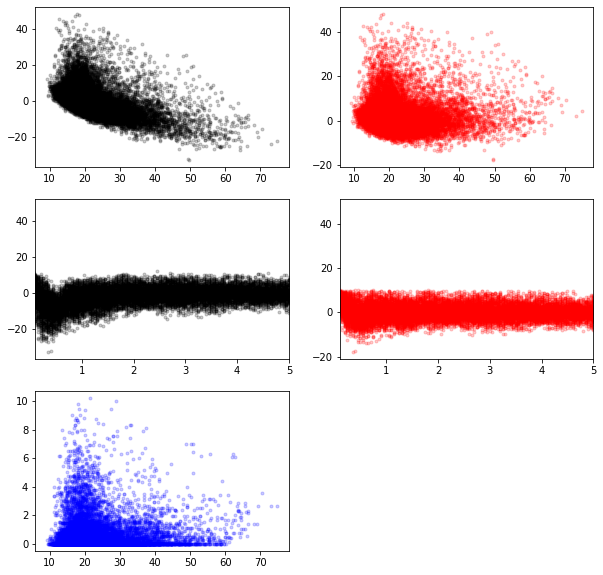

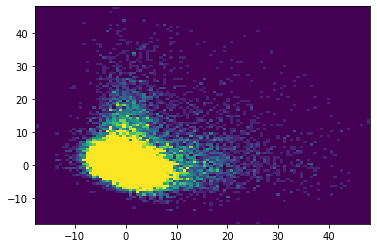

In [7]:
## trying to estimate underlying membrane potential with the proximity of spikes

prev_offset = offset

session_i = 1
session = sessions[session_i]
cell_i = 14#81#2
cell_idx = photostim_data_dict[session]['cell_indices'][cell_i]

spike_threshold = 5
tau_membrane = 2# photostim_data_dict[session]['fitted_tau'][cell_i] # using the generated F0 and tau values 3 
g_membrane = np.exp((-1*0.05)/tau_membrane)
spikes_trace = np.asarray(spikes_matrix_ALL[session_i])[cell_idx,:]
spikes_thresholded = spikes_trace>spike_threshold
spikes_convolved = []
s_last = 0
for s in spikes_thresholded:
    s_now = np.max([s,s_last*g_membrane])
    spikes_convolved.append(s_now)
    s_last = s_now
spikes_convolved=np.asarray(spikes_convolved)



session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                            scalar_f0 = scalar_f0,
                                                                            photostim = True,
                                                                            correct_offset = correct_offset)
if correct_with_running_F0:
    F_photostim = F_photostim-F0_photostim+F0_scalar_photostim

tau_real = photostim_data_dict[session]['fitted_tau'][cell_i] # using the generated F0 and tau values
F0 = b = photostim_data_dict[session]['fitted_f0'][cell_i] # using the generated F0 and tau values
g = np.exp((-1*0.05)/tau_real)
F_trace = F_photostim[cell_idx,:]
    


v0 = BCI_analysis.pipeline_utils.rollingfun(spikes_convolved,baseline_length,'max')    
spikes_base = BCI_analysis.pipeline_utils.rollingfun(spikes_trace,baseline_length,'mean')
spikes_peak = BCI_analysis.pipeline_utils.rollingfun(spikes_trace,peak_length)
spike_amplitudes = spikes_peak[offset:]#-spikes_base[:-offset]



f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
amplitudes = fpeak[offset:]-f0[:-offset]
previous_amplitudes = np.roll(amplitudes,prev_offset)
f0s = f0[:-offset]
v0s= v0[:-offset]
spikes_base = spikes_base[:-offset]

correction = f0s - (f0s-b)*(g**offset) - b
amplitudes_corrected = amplitudes+correction
previous_amplitudes_corrected = np.roll(amplitudes_corrected,prev_offset)


frames_since_last_spike = []
s_last = 0
for s in amplitudes_corrected>10:
    if s:
        s_last = 0
    else:
        s_last +=1
    frames_since_last_spike.append(s_last)

#frames_since_last_spike = frames_since_last_spike[:-offset]



# previous_amplitudes_corrected_= (previous_amplitudes_corrected_>20)*1
# previous_amplitudes_corrected = []
# s_last = 0
# for s in previous_amplitudes_corrected_:
#     s_now = np.max([s,s_last*g_membrane])
#     previous_amplitudes_corrected.append(s_now)
#     s_last = s_now
# previous_amplitudes_corrected=np.asarray(previous_amplitudes_corrected)




alpha = .2
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(3,2,1)
ax1.plot(f0s,amplitudes,'k.',alpha =  alpha)
    
ax2 = fig.add_subplot(3,2,2)
ax2.plot(f0s,amplitudes_corrected,'r.',alpha =  alpha)

ax1_spks = fig.add_subplot(3,2,3)
ax1_spks.plot(np.asarray(frames_since_last_spike)/20,amplitudes,'k.',alpha = alpha)
#ax1_spks.set_xscale('log')
ax2_spks = fig.add_subplot(3,2,4,sharex = ax1_spks)
ax2_spks.plot(np.asarray(frames_since_last_spike)/20,amplitudes_corrected,'r.',alpha = alpha)
ax2_spks.set_xlim(.1,5)
#ax2_spks.set_xscale('log')
# #plt.plot(spikes_trace[1000:2000])
# fig = plt.figure()
# ax_spk = fig.add_subplot(1,1,1)
# ax_trace = ax_spk.twinx()
# #ax_spk.plot(spikes_thresholded[1000:5000])
# ax_spk.plot(spikes_convolved[7000:9000])
# ax_trace.plot(F_trace[7000:9000],'g-')

ax_spiks_plot = fig.add_subplot(3,2,5)
ax_spiks_plot.plot(f0s,spike_amplitudes,'b.',alpha =  alpha)



fig = plt.figure()
ax = fig.add_subplot(1,1,1)
t = ax.hist2d(previous_amplitudes_corrected,amplitudes_corrected,100)
t[3].set_clim([0,10])


In [ ]:
# this plot shows correction for the TAU-based correction
cell_i = 60#12#81#2
cell_idx = photostim_data_dict[session]['cell_indices'][cell_i]

for session_i,session in enumerate(sessions):
    ####session = sessions[0]
    session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
    photostim_dir = os.path.join(session_dir,'photostim')
    dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                scalar_f0 = scalar_f0,
                                                                                photostim = True,
                                                                                correct_offset = correct_offset)
    if correct_with_running_F0:
            F_photostim = F_photostim-F0_photostim+F0_scalar_photostim
                
    tau_real = photostim_data_dict[session]['fitted_tau'][cell_i] # using the generated F0 and tau values
    F0 = b = photostim_data_dict[session]['fitted_f0'][cell_i] # using the generated F0 and tau values
    g = np.exp((-1*0.05)/tau_real)
    F_trace = F_photostim[cell_idx,:]
    spikes_trace = spikes_matrix_ALL[session_i][cell_idx]
    if correct_slow_drift:
        x = np.arange(len(np.mean(F0_photostim,0)))
        correction = x*(p_slow_drif[0])*F_trace
        F_trace -= correction

    f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
    fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
    amplitudes_spikes = BCI_analysis.pipeline_utils.rollingfun(spikes_trace,peak_length+peak_offset*2)[offset:]
    amplitudes = fpeak[offset:]-f0[:-offset]
    f0s = f0[:-offset]
    correction = f0s - (f0s-b)*(g**offset) - b
    amplitudes_corrected = amplitudes+correction


    fig = plt.figure(figsize = [20,10])
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.arange(len(F_trace))/20,F_trace)#-F0)/F0)
    ax.set_xlim([500, 1500])
    fig = plt.figure(figsize = [20,20])
    ax_current = fig.add_subplot(4,3,1)
    ax_current.plot(f0s,amplitudes,'k.',alpha = .1)

    ax_current.set_xlabel('f0 value')
    ax_current.set_ylabel('df value')
    ax_current.set_title('cell {} - tau: {} s, F0(new): {} - F0(old): {}'.format(cell_idx,np.round(tau_real,3),np.round(b),np.round(F0)))
    ax_current.plot(np.concatenate(photostim_data_dict[session]['F_start'][cell_i]),np.concatenate(photostim_data_dict[session]['dF'][cell_i]),'r.',alpha = .5)
    ax_current.plot(F0,0,'bo')
    #ax_current.errorbar(bin_center,bin_mean,bin_std,color = 'yellow')
    ax_current.plot(b,0,'yo')
    #ax_current.plot(np.polyval(p,np.unique(bin_mean)),np.unique(bin_mean),'y--')


    ax_corrected = fig.add_subplot(4,3,2,sharex = ax_current,sharey = ax_current)
    ax_corrected.plot(f0s,amplitudes_corrected,'k.',alpha = .1)
    ax_corrected.set_xlabel('f0 value')
    ax_corrected.set_ylabel('corrected df value')
    ax_corrected.plot(np.concatenate(photostim_data_dict[session]['F_start'][cell_i]),np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]),'r.',alpha = .5)
    
    
    ax_spikes = fig.add_subplot(4,3,3,sharex = ax_current)
    ax_spikes.plot(f0s,amplitudes_spikes,'k.',alpha = .1)
    ax_spikes.set_xlabel('f0 value')
    ax_spikes.set_ylabel('spikes')#spikes_amplitudes
    ax_spikes.plot(np.concatenate(photostim_data_dict[session]['F_start'][cell_i]),np.concatenate(photostim_data_dict[session]['spikes_amplitudes'][cell_i]),'b.',alpha = .5)
    
    

    ax_hist = fig.add_subplot(4,3,4)
    hist_range = [np.nanmin(np.concatenate([np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]),amplitudes_corrected])),
                  np.nanmax(np.concatenate([np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]),amplitudes_corrected]))]
    y,x = np.histogram(amplitudes_corrected,bins = 500,range = hist_range)
    y_stim,xx = np.histogram(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]),x)
    x = np.mean([x[:-1],x[1:]],0)
    pdf_y = np.cumsum(y)/np.sum(y)
    ax_hist.plot(x,pdf_y,'k-')
    pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
    # ax_hist_2 = ax_hist.twinx()
    # ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
    ax_hist.plot(x,pdf_y_stim,'r-')
    ax_hist_diff = ax_hist.twinx()
    ax_hist_diff.plot(x,pdf_y_stim-pdf_y,'b--')
    ax_hist.set_xlabel('corrected df')
    ax_hist.set_ylabel('cumulative probability')
    #ax_hist.set_xscale('log')


    ax_hist_f0 = fig.add_subplot(4,3,5)
    hist_range = [np.nanmin(np.concatenate([np.concatenate(photostim_data_dict[session]['F_start'][cell_i]),f0s])),
                  np.nanmax(np.concatenate([np.concatenate(photostim_data_dict[session]['F_start'][cell_i]),f0s]))]
    y,x = np.histogram(f0s,bins = 500,range = hist_range)
    y_stim,xx = np.histogram(np.concatenate(photostim_data_dict[session]['F_start'][cell_i]),x)
    x = np.mean([x[:-1],x[1:]],0)
    pdf_y = np.cumsum(y)/np.sum(y)
    ax_hist_f0.plot(x,pdf_y,'k-')
    pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
    # ax_hist_2 = ax_hist.twinx()
    # ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr']))
    ax_hist_f0.plot(x,pdf_y_stim,'r-')
    ax_hist_f0_diff = ax_hist_f0.twinx()
    ax_hist_f0_diff.get_shared_y_axes().join(ax_hist_f0_diff, ax_hist_diff)
    ax_hist_f0_diff.plot(x,pdf_y_stim-pdf_y,'b--')
    ax_hist_f0.set_xlabel('F0')
    ax_hist_f0.set_ylabel('cumulative probability')






    ax_group_f0_amplitude = fig.add_subplot(4,3,7)
    ax_group_f0_amplitude.plot(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes'][cell_i]),'k.',alpha = .1)#
    p__ = np.polyfit(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes'][cell_i]),1)
    x__ = np.percentile(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),[5,95])
    y__ = np.polyval(p__,x__)
    ax_group_f0_amplitude.plot(x__,y__,'k--')
    ax_group_f0_amplitude.set_title('f0 vs df corrcoeff: {:.3f}'.format(photostim_data_dict[session]['dF_vs_f0_corrcoef'][cell_i]))
    group_amps_all = []
    group_f0s_mean_all = []
    for f0s_,amps in zip(photostim_data_dict[session]['F_start'][cell_i],photostim_data_dict[session]['dF'][cell_i]):
        ax_group_f0_amplitude.plot(np.nanmean(f0s_),np.nanmean(amps),'ro')
        group_amps_all.append(np.nanmean(amps))
        group_f0s_mean_all.append(np.nanmean(f0s_))

    ax_group_f0_amplitude.set_xlabel('mean f0 value')
    ax_group_f0_amplitude.set_ylabel('mean dF')

    ax_group_f0_amplitude_corr = fig.add_subplot(4,3,8)
    ax_group_f0_amplitude_corr.plot(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i]),'k.',alpha = .1)#
    group_amps_all_corr = []
    for f0s_,amps in zip(photostim_data_dict[session]['F_start'][cell_i],photostim_data_dict[session]['dF_corr'][cell_i]):
        ax_group_f0_amplitude_corr.plot(np.nanmean(f0s_),np.nanmean(amps),'ro')
        group_amps_all_corr.append(np.nanmean(amps))

    ax_group_f0_amplitude_corr.set_xlabel('mean f0 value')
    ax_group_f0_amplitude_corr.set_ylabel('mean dF - corrected')

    p__ = np.polyfit(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i]),1)
    x__ = np.percentile(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),[5,95])
    y__ = np.polyval(p__,x__)
    ax_group_f0_amplitude_corr.plot(x__,y__,'k--')
    ax_group_f0_amplitude_corr.set_title('f0 vs df corrcoeff: {:.3f}'.format(photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'][cell_i]))



    
    
    
    ax_group_f0_spikes = fig.add_subplot(4,3,9)
    #ax_group_f0_spikes.plot(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i]),'k.',alpha = .1)#
    group_amps_all_corr = []
    for f0s_,amps in zip(photostim_data_dict[session]['F_start'][cell_i],photostim_data_dict[session]['spikes_amplitudes'][cell_i]):
        ax_group_f0_spikes.plot(np.nanmean(f0s_),np.nanmean(amps),'bo')
        group_amps_all_corr.append(np.nanmean(amps))

    ax_group_f0_spikes.set_xlabel('mean f0 value')
    ax_group_f0_spikes.set_ylabel('mean spikes')

    # p__ = np.polyfit(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i]),1)
    # x__ = np.percentile(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),[5,95])
    # y__ = np.polyval(p__,x__)
    # ax_group_f0_spikes.plot(x__,y__,'k--')
    # ax_group_f0_spikes.set_title('f0 vs df corrcoeff: {:.3f}'.format(photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'][cell_i]))



    
    
    
    
    
    ax_hist_group = fig.add_subplot(4,3,10)
    hist_range = [np.nanmin(np.concatenate([group_amps_all_corr,np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i])])),
                  np.nanmax(np.concatenate([group_amps_all_corr,np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i])]))]
    y,x = np.histogram(np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_i]),bins = 500,range = hist_range)
    y_stim,xx = np.histogram(group_amps_all_corr,x)
    x = np.mean([x[:-1],x[1:]],0)
    pdf_y = np.cumsum(y)/np.sum(y)
    ax_hist_group.plot(x,pdf_y,'k-')
    pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
    # ax_hist_2 = ax_hist.twinx()
    # ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr']))
    ax_hist_group.plot(x,pdf_y_stim,'r-')
    ax_hist_diff_group = ax_hist_group.twinx()
    ax_hist_diff_group.plot(x,pdf_y_stim-pdf_y,'b--')
    ax_hist_group.set_xlabel('corrected mean df')
    ax_hist_group.set_ylabel('cumulative probability')
    #ax_hist.set_xscale('log')


    ax_hist_f0_group = fig.add_subplot(4,3,11)
    hist_range = [np.nanmin(np.concatenate([group_f0s_mean_all,np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i])])),
                  np.nanmax(np.concatenate([group_f0s_mean_all,np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i])]))]
    y,x = np.histogram(np.concatenate(photostim_data_dict[session]['shuffled_mean_f0s'][cell_i]),bins = 500,range = hist_range)
    y_stim,xx = np.histogram(group_f0s_mean_all,x)
    x = np.mean([x[:-1],x[1:]],0)
    pdf_y = np.cumsum(y)/np.sum(y)
    ax_hist_f0_group.plot(x,pdf_y,'k-')
    pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
    # ax_hist_2 = ax_hist.twinx()
    # ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'])
    ax_hist_f0_group.plot(x,pdf_y_stim,'r-')
    ax_hist_f0_diff_group = ax_hist_f0_group.twinx()
    ax_hist_f0_diff_group.get_shared_y_axes().join(ax_hist_f0_diff_group, ax_hist_diff_group)
    ax_hist_f0_diff_group.plot(x,pdf_y_stim-pdf_y,'b--')
    ax_hist_f0_group.set_xlabel('F0')
    ax_hist_f0_group.set_ylabel('cumulative probability')

    #             fig_2 = plt.figure(figsize = [10,10])
    #             ax_uncorrected = fig_2.add_subplot(3,3,1)
    #             ax_uncorrected.plot(f0s,amplitudes,'k.',alpha = .1)
    #             frames_edge = 50
    #             for i,(center,meandf) in enumerate(zip(bin_center[:8],bin_mean[:8])):
    #                 dist = np.sqrt((f0s-center)**2+(amplitudes-meandf)**2)
    #                 idx = np.argmax(dist[frames_edge:-frames_edge]<1)+frames_edge #np.argmax(dist<1)
    #                 ax_uncorrected.plot(f0s[idx],amplitudes[idx],'ro')
    #                 if i==0:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i)
    #                 else:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i,sharey = ax_plot)
    #                 ax_plot.plot(F_trace[idx-frames_edge:idx+frames_edge])
    #                 ax_plot.plot(frames_edge-offset/2,f0s[idx],'ro')
    #                 ax_plot.plot(frames_edge+offset/2,f0s[idx]+amplitudes[idx],'ro')

    #             fig_2 = plt.figure(figsize = [10,10])
    #             ax_uncorrected = fig_2.add_subplot(3,3,1)
    #             ax_uncorrected.plot(f0s,amplitudes,'k.',alpha = .1)
    #             frames_edge = 50
    #             for i,(center,meandf) in enumerate(zip(bin_center[:8],bin_mean[:8])):
    #                 meandf = meandf+np.nanmax(amplitudes)/2
    #                 dist = np.sqrt((f0s-center)**2+(amplitudes-meandf)**2)
    #                 idx = np.argmax(dist[frames_edge:-frames_edge]<1)+frames_edge
    #                 #print(idx)
    #                 ax_uncorrected.plot(f0s[idx],amplitudes[idx],'ro')
    #                 if i==0:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i)
    #                 else:
    #                     ax_plot = fig_2.add_subplot(3,3,2+i,sharey = ax_plot)
    #                 idx+=offset
    #                 ax_plot.plot(F_trace[idx-frames_edge:idx+frames_edge])
    #                 ax_plot.plot(frames_edge-offset/2,f0s[idx],'ro')
    #                 ax_plot.plot(frames_edge+offset/2,f0s[idx]+amplitudes[idx],'ro')

    #sdas

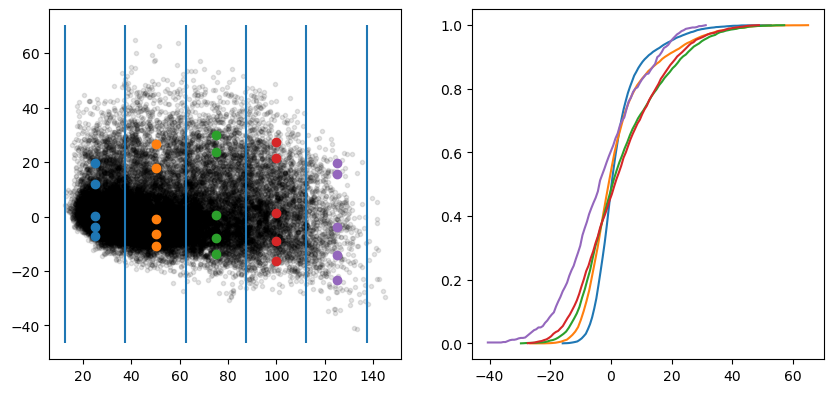

In [8]:
# plot showing how the distribution changes at different F0 values for a given cell 
# F0 values are biased towards cloes-to-0 values, so there is a sampling problem here, probably
F0  = 25
amplitudes_to_use = amplitudes_corrected
percentiles_to_show = [5,20,50,90,95]
fig = plt.figure(figsize = [10,10])
ax_1 = fig.add_subplot(2,2,1)
ax_1.plot(f0s,amplitudes_to_use,'k.',alpha = .1)
ax_1.vlines(np.asarray([.5,1.5,2.5,3.5,4.5,5.5])*F0,ax_1.get_ylim()[0],ax_1.get_ylim()[1])

ax_2 = fig.add_subplot(2,2,2)

idx_base = (f0s<F0*1.5) &  (f0s>F0*.5)
y,x = np.histogram(amplitudes_to_use[idx_base],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))

ax_1.plot(np.ones(len(percentiles_to_show))*1*F0,np.percentile(amplitudes_to_use[idx_base],percentiles_to_show),'o')


idx_1 = (f0s<F0*2.5) &  (f0s>F0*1.5)
y,x = np.histogram(amplitudes_to_use[idx_1],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*2*F0,np.percentile(amplitudes_to_use[idx_1],percentiles_to_show),'o')



idx_2 = (f0s<F0*3.5) &  (f0s>F0*2.5)
y,x = np.histogram(amplitudes_to_use[idx_2],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*3*F0,np.percentile(amplitudes_to_use[idx_2],percentiles_to_show),'o')



idx_4 = (f0s<F0*4.5) &  (f0s>F0*3.5)
y,x = np.histogram(amplitudes_to_use[idx_4],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*4*F0,np.percentile(amplitudes_to_use[idx_4],percentiles_to_show),'o')


idx_5 = (f0s<F0*5.5) &  (f0s>F0*4.5)
y,x = np.histogram(amplitudes_to_use[idx_5],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*5*F0,np.percentile(amplitudes_to_use[idx_5],percentiles_to_show),'o')



#ax_2.set_ylim([.9,1])

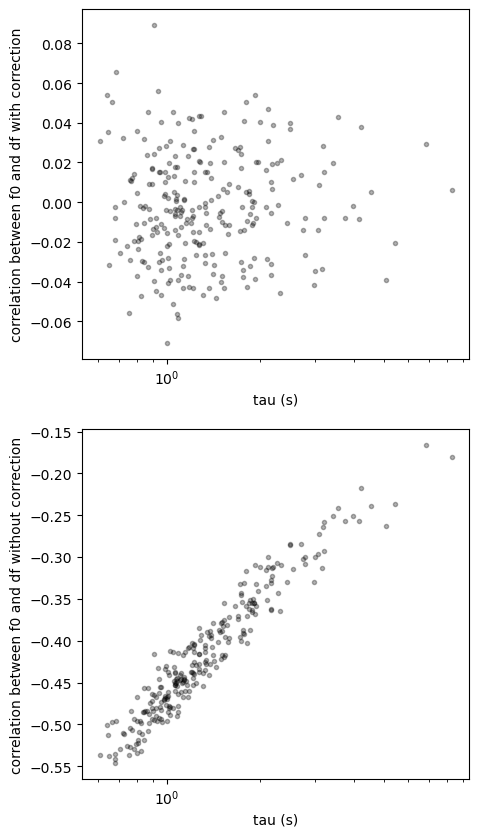

In [469]:
# What is the residual correlation between f0 and corrected amplitude vs the tau used for correction

fig = plt.figure(figsize = [5,10])
ax1 = fig.add_subplot(2,1,1)
ax1.plot(photostim_data_dict[session]['fitted_tau'],photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'],'k.',alpha = .3)
ax1.set_xlabel('tau (s)')
ax1.set_ylabel('correlation between f0 and df with correction')
ax1.set_xscale('log')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(photostim_data_dict[session]['fitted_tau'],photostim_data_dict[session]['dF_vs_f0_corrcoef'] ,'k.',alpha = .3)
ax2.set_xlabel('tau (s)')
ax2.set_ylabel('correlation between f0 and df without correction')
ax2.set_xscale('log')

Text(0, 0.5, 'correlation between f0 and df with correction')

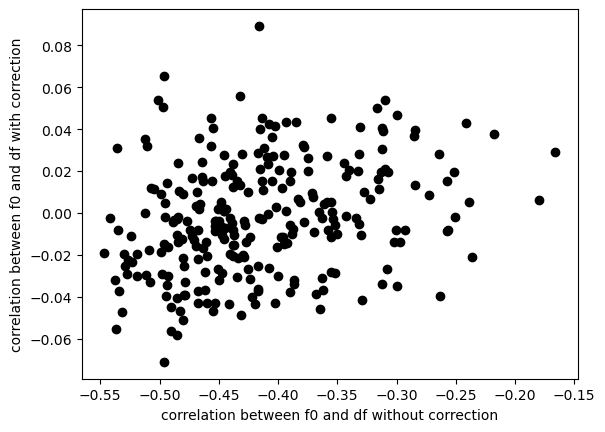

In [470]:
#does f0 correction depend on previous correlations?
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(photostim_data_dict[session]['dF_vs_f0_corrcoef'],photostim_data_dict[session]['dF_corr_vs_f0_corrcoef'],'ko')
ax.set_xlabel('correlation between f0 and df without correction')
ax.set_ylabel('correlation between f0 and df with correction')
# lims = np.asarray([ax.get_xlim(),ax.get_ylim()])

# ax.set_ylim([np.min(lims),np.max(lims)])
# ax.set_xlim([np.min(lims),np.max(lims)])

In [8]:
# select trials with matching f0 values  - maybe try matching baseline spike values

max_fstart_difference = .1 # in dF/F
max_trials_to_remove = 10
minimum_trial_number = 15 # if a group-cell pair doesn't have this trial number, it gets discarded


kept_trials_session_0 = []
kept_trials_session_1 = []
trials_removed_list = []
for cell_i in range(len(photostim_data_dict[session]['F_start'])):
    fstart_sessionwise = []
    f0_sessionwise = []
    trials_removed_cell_list = []
    kept_trials_session_0_cell = []
    kept_trials_session_1_cell = []
    for session in sessions:
        fstart_sessionwise.append(photostim_data_dict[session]['F_start'][cell_i])
        f0_sessionwise.append(photostim_data_dict[session]['fitted_f0'][cell_i])
    for fstart_0,fstart_1 in zip(fstart_sessionwise[0],fstart_sessionwise[1]):
        to_remove_0 = np.zeros(len(fstart_0))*False
        to_remove_1 = np.zeros(len(fstart_1))*False
        last_changed = 1
        trials_removed =0
        while np.abs(np.nanmean(fstart_0[to_remove_0==False])/f0_sessionwise[0]-np.nanmean(fstart_1[to_remove_1==False])/f0_sessionwise[1]) >= max_fstart_difference and trials_removed<max_trials_to_remove:
            if last_changed == 1:
                if np.nanmean(fstart_0[to_remove_0==False])/f0_sessionwise[0]>np.nanmean(fstart_1[to_remove_1==False])/f0_sessionwise[1]: # max to be removed from g0
                    to_remove_idx = np.argmax(fstart_0 == np.nanmax(fstart_0[to_remove_0==False]))
                else:# min to be removed from g0
                    to_remove_idx = np.argmax(fstart_0 == np.nanmin(fstart_0[to_remove_0==False]))
                to_remove_0[to_remove_idx] = True
                last_changed = 0
            else:
                if np.nanmean(fstart_0[to_remove_0==False])/f0_sessionwise[0]>np.nanmean(fstart_1[to_remove_1==False])/f0_sessionwise[1]: # min to be removed from g1
                    to_remove_idx = np.argmax(fstart_1 == np.nanmin(fstart_1[to_remove_1==False]))
                else:# min to be removed from g0
                    to_remove_idx = np.argmax(fstart_1 == np.nanmax(fstart_1[to_remove_1==False]))
                to_remove_1[to_remove_idx] = True
                last_changed = 1
                trials_removed +=1
        if sum(to_remove_0==False)< minimum_trial_number or sum(to_remove_1==False)< minimum_trial_number:
            kept_trials_session_0_cell.append(to_remove_0==np.pi)
            kept_trials_session_1_cell.append(to_remove_1==np.pi)
            trials_removed_cell_list.append(len(to_remove_0))
        else:
            kept_trials_session_0_cell.append(to_remove_0==False)
            kept_trials_session_1_cell.append(to_remove_1==False)
            trials_removed_cell_list.append(trials_removed)
    kept_trials_session_0.append(kept_trials_session_0_cell)
    kept_trials_session_1.append(kept_trials_session_1_cell)
    trials_removed_list.append(trials_removed_cell_list)
        
        
            
            
        
        #asdas
        

photostim_data_dict[sessions[0]]['f0_matched_trials'] = kept_trials_session_0
photostim_data_dict[sessions[1]]['f0_matched_trials'] = kept_trials_session_1
    

In [9]:
# create random halves of each session, and creates average amplitudes
# this one is very important - this creates the actual data to be plotted
import warnings
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

nonrandom_halves = True # sorts based on F0 if set to True
equalize_halves = True # F0 is equalized between halves (without removing anything)

resample_n = 500
do_resample = False
use_local_f0 = False # method Kayvon uses

for session_i, session in enumerate(sessions):
    photostim_data_dict[session]['baseline_photon_counts'] = photon_counts_list[session_i]
    
for session in photostim_data_dict.keys():
    repeats = []
    repeats_matched = []
    mean_spikes0 = []
    mean_dspikes = []
    mean_dspikes_1 = []
    mean_dspikes_2 = []
    mean_df = []
    
    var_df = []
    mean_min_df = []
    mean_min_df_corr = []
    mean_impact = []
    var_impact = []
    mean_impact_1 = []
    mean_impact_2 = []
    var_impact_1 = []
    var_impact_2 = []
    mean_df_1 = []
    mean_df_2 = []
    var_df_1 = []
    var_df_2 = []
    mean_df_corr = []
    var_df_corr = []
    mean_impact_corr = []
    var_impact_corr = []
    mean_df_corr_1 = []
    mean_df_corr_2 = []
    var_df_corr_1 = []
    var_df_corr_2 = []
    mean_impact_corr_1 = []
    mean_impact_corr_2 = []
    var_impact_corr_1 = []
    var_impact_corr_2 = []
    mean_f_start = []
    var_f_start = []
    mean_f_start_matched = []
    var_f_start_matched = []
    mean_f_start_1 = []
    mean_f_start_2 = []
    var_f_start_1 = []
    var_f_start_2 = []
    mean_f_zscore_start = []
    mean_f_zscore_start_1 = []
    mean_f_zscore_start_2 = []
    
    mean_df_bootstrapped = []
    mean_df_corr_bootstrapped = []
    mean_dspikes_bootstrapped = []
    
    mean_df_matched = []
    mean_impact_matched = []
    mean_df_matched_1 = []
    mean_df_matched_2 = []
    mean_impact_matched_1 = []
    mean_impact_matched_2 = []
    mean_df_matched_corr = []
    mean_impact_matched_corr = []
    mean_df_matched_corr_1 = []
    mean_df_matched_corr_2 = []
    mean_impact_matched_corr_1 = []
    mean_impact_matched_corr_2 = []
    mean_f_start_matched = []
    mean_f_start_matched_1 = []
    mean_f_start_matched_2 = []
    mean_f_zscore_start_matched = []
    mean_f_zscore_start_matched_1 = []
    mean_f_zscore_start_matched_2 = []
    mean_spikes0_matched = []
    mean_dspikes_matched = []
    mean_dspikes_matched_1 = []
    mean_dspikes_matched_2 = []
    
    
    var_df_matched = []
    var_impact_matched = []
    var_df_matched_1 = []
    var_df_matched_2 = []
    var_impact_matched_1 = []
    var_impact_matched_2 = []
    var_df_matched_corr = []
    var_impact_matched_corr = []
    var_df_matched_corr_1 = []
    var_df_matched_corr_2 = []
    var_impact_matched_corr_1 = []
    var_impact_matched_corr_2 = []
    var_f_start_matched = []
    var_f_start_matched_1 = []
    var_f_start_matched_2 = []
    var_f_zscore_start_matched = []
    var_f_zscore_start_matched_1 = []
    var_f_zscore_start_matched_2 = []
    
    
    for f_start,df,df_corr,f0,percentiles,percentiles_corr,min_df,min_df_corr,spikes_start,spikes_ampl,df_shuffle,df_shuffle_corr,shuffle_f0,matched_trials in zip(photostim_data_dict[session]['F_start'],
                                                                                                                                                                     photostim_data_dict[session]['dF'],
                                                                                                                                                                     photostim_data_dict[session]['dF_corr'],
                                                                                                                                                                     photostim_data_dict[session]['fitted_f0'],
                                                                                                                                                                     photostim_data_dict[session]['cell_percentile_amplitudes_ALL'],
                                                                                                                                                                     photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL'],
                                                                                                                                                                     photostim_data_dict[session]['min_dF'],
                                                                                                                                                                     photostim_data_dict[session]['min_dF_corr'],
                                                                                                                                                                     photostim_data_dict[session]['spikes_base'],
                                                                                                                                                                     photostim_data_dict[session]['spikes_amplitudes'] ,
                                                                                                                                                                     photostim_data_dict[session]['shuffled_mean_amplitudes'],
                                                                                                                                                                     photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'],
                                                                                                                                                                     photostim_data_dict[session]['shuffled_mean_f0s'],
                                                                                                                                                                     photostim_data_dict[session]['f0_matched_trials']): #'F0'#'fitted_f0
        mean_spikes0_cell = []
        mean_dspikes_cell = []
        mean_dspikes_cell_1 = []
        mean_dspikes_cell_2 = []
        mean_df_cell = []
        mean_min_df_cell = []
        mean_min_df_corr_cell = []
        mean_impact_cell = []
        mean_df_cell_1 = []
        mean_df_cell_2 = []
        mean_impact_cell_1 = []
        mean_impact_cell_2 = []
        mean_df_corr_cell = []
        mean_impact_corr_cell = []
        mean_df_corr_cell_1 = []
        mean_df_corr_cell_2 = []
        mean_impact_corr_cell_1 = []
        mean_impact_corr_cell_2 = []
        mean_f_start_cell = []
        mean_f_start_cell_1 = []
        mean_f_start_cell_2 = []
        mean_f_zscore_start_cell = []
        mean_f_zscore_start_cell_1 = []
        mean_f_zscore_start_cell_2 = []
        
        mean_df_bootstrapped_cell = []
        mean_df_corr_bootstrapped_cell = []
        mean_dspikes_bootstrapped_cell = []

        var_df_cell = []
        var_impact_cell = []
        var_df_cell_1 = []
        var_df_cell_2 = []
        var_impact_cell_1 = []
        var_impact_cell_2 = []
        var_df_corr_cell = []
        var_impact_corr_cell = []
        var_df_corr_cell_1 = []
        var_df_corr_cell_2 = []
        var_impact_corr_cell_1 = []
        var_impact_corr_cell_2 = []
        var_f_start_cell = []
        var_f_start_cell_1 = []
        var_f_start_cell_2 = []
        var_f_zscore_start_cell = []
        var_f_zscore_start_cell_1 = []
        var_f_zscore_start_cell_2 = []
        
        repeats_cell = []
        repeats_matched_cell = []

        for group_i in range(len(f_start)):
            if nonrandom_halves:
                random_order = np.argsort(f_start[group_i])# ORDERED BY F0
                if equalize_halves:
                    random_order = np.concatenate([random_order[0::2],random_order[1::2]]) # equalized
            else:
                random_order = np.arange(len(df[group_i]))
                random.shuffle(random_order)
            repeats_cell.append(sum(np.isnan(df[group_i])==False))
            if use_local_f0:
                mean_df_cell.append(np.nanmean(np.asarray(df[group_i])/np.asarray(f_start[group_i])))
                var_df_cell.append(np.nanvar(np.asarray(df[group_i])/np.asarray(f_start[group_i])))
            else:
                mean_df_cell.append(np.nanmean(df[group_i])/f0)
                var_df_cell.append(np.nanvar(df[group_i])/f0)
            mean_spikes0_cell.append(np.nanmean(spikes_start[group_i]))
            mean_dspikes_cell.append(np.nanmean(spikes_ampl[group_i]))
            impacts = (df[group_i]-np.mean(np.concatenate(df_shuffle)))/np.std(np.concatenate(df_shuffle))
            mean_impact_cell.append(np.nanmean(impacts))
            var_impact_cell.append(np.nanvar(impacts))
            
            fstarts = f_start[group_i]
            fstarts = fstarts[random_order]
            
            if use_local_f0:
                dfs = np.asarray(df[group_i])/np.asarray(f_start[group_i]) ## df/f calculation a'la Kayvon
            else:
                dfs = df[group_i]/f0
            
            
            dfs = dfs[random_order]
            
            impacts = impacts[random_order]
            
            
            spikes = spikes_ampl[group_i][random_order]
            fstarts_zscore = (fstarts-np.mean(np.concatenate(shuffle_f0)))/np.std(np.concatenate(shuffle_f0))
            half = int(len(dfs)/2)
            mean_df_cell_1.append(np.nanmean(dfs[:half]))
            mean_df_cell_2.append(np.nanmean(dfs[half:]))
            mean_dspikes_cell_1.append(np.nanmean(spikes[:half]))
            mean_dspikes_cell_2.append(np.nanmean(spikes[half:]))
            mean_impact_cell_1.append(np.nanmean(impacts[:half]))
            mean_impact_cell_2.append(np.nanmean(impacts[half:]))
            mean_df_corr_cell.append(np.nanmean(df_corr[group_i])/f0)
            
            if do_resample:
                df_bootstrapped = []
                df_corr_bootstrapped = []
                dspikes_bootstrapped = []
                for i in range(resample_n):
                    df_bootstrapped.append(np.nanmean(np.random.choice(dfs,int(len(dfs)))))
                    df_corr_bootstrapped.append(np.nanmean(np.random.choice((df_corr[group_i])/f0,int(len((df_corr[group_i])/f0)))))
                    dspikes_bootstrapped.append(np.nanmean(np.random.choice((spikes_ampl[group_i]),int(len((spikes_ampl[group_i]))))))
            
                mean_df_bootstrapped_cell.append(np.nanmedian(df_bootstrapped))
                mean_df_corr_bootstrapped_cell.append(np.nanmedian(df_corr_bootstrapped))
                mean_dspikes_bootstrapped_cell.append(np.nanmedian(dspikes_bootstrapped))
            
            var_df_cell_1.append(np.nanvar(dfs[:half]))
            var_df_cell_2.append(np.nanvar(dfs[half:]))

            var_impact_cell_1.append(np.nanvar(impacts[:half]))
            var_impact_cell_2.append(np.nanvar(impacts[half:]))
            var_df_corr_cell.append(np.nanvar(df_corr[group_i])/f0)
            
            
            impacts_corr = (df_corr[group_i]-np.mean(np.concatenate(df_shuffle_corr)))/np.std(np.concatenate(df_shuffle_corr))
            mean_impact_corr_cell.append(np.nanmean(impacts_corr))
            if use_local_f0:
                dfs = np.asarray(df_corr[group_i])/np.asarray(f_start[group_i]) ## df/f calculation a'la Kayvon
            else:
                dfs = df_corr[group_i]/f0
            dfs = dfs[random_order]
            impacts_corr = impacts_corr[random_order]
            half = int(len(dfs)/2)
            mean_df_corr_cell_1.append(np.nanmean(dfs[:half]))
            mean_df_corr_cell_2.append(np.nanmean(dfs[half:]))
            mean_impact_corr_cell_1.append(np.nanmean(impacts_corr[:half]))
            mean_impact_corr_cell_2.append(np.nanmean(impacts_corr[half:]))
            mean_f_start_cell.append(np.nanmean(fstarts)/f0-1)
            mean_f_start_cell_1.append(np.nanmean(fstarts[:half])/f0-1)
            mean_f_start_cell_2.append(np.nanmean(fstarts[half:])/f0-1)
            mean_f_zscore_start_cell.append(np.nanmean(fstarts_zscore))
            mean_f_zscore_start_cell_1.append(np.nanmean(fstarts_zscore[:half]))
            mean_f_zscore_start_cell_2.append(np.nanmean(fstarts_zscore[half:]))
            mean_min_df_cell.append(np.nanmean(min_df[group_i])/f0)
            mean_min_df_corr_cell.append(np.nanmean(min_df_corr[group_i])/f0)
            
            var_df_corr_cell_1.append(np.nanvar(dfs[:half]))
            var_df_corr_cell_2.append(np.nanvar(dfs[half:]))
            var_impact_corr_cell_1.append(np.nanvar(impacts_corr[:half]))
            var_impact_corr_cell_2.append(np.nanvar(impacts_corr[half:]))
            var_f_start_cell.append(np.nanvar(fstarts)/f0-1)
            var_f_start_cell_1.append(np.nanvar(fstarts[:half])/f0-1)
            var_f_start_cell_2.append(np.nanvar(fstarts[half:])/f0-1)
            
        mean_df.append(mean_df_cell)
        mean_impact.append(mean_impact_cell)
        mean_df_1.append(mean_df_cell_1)
        mean_df_2.append(mean_df_cell_2)
        mean_impact_1.append(mean_impact_cell_1)
        mean_impact_2.append(mean_impact_cell_2)
        mean_df_corr.append(mean_df_corr_cell)
        mean_impact_corr.append(mean_impact_corr_cell)
        mean_df_corr_1.append(mean_df_corr_cell_1)
        mean_df_corr_2.append(mean_df_corr_cell_2)
        mean_impact_corr_1.append(mean_impact_corr_cell_1)
        mean_impact_corr_2.append(mean_impact_corr_cell_2)
        mean_f_start.append(mean_f_start_cell)
        mean_f_start_1.append(mean_f_start_cell_1)
        mean_f_start_2.append(mean_f_start_cell_2)
        mean_f_zscore_start.append(mean_f_zscore_start_cell)
        mean_f_zscore_start_1.append(mean_f_zscore_start_cell_1)
        mean_f_zscore_start_2.append(mean_f_zscore_start_cell_2)
        mean_min_df.append(mean_min_df_cell)
        mean_min_df_corr.append(mean_min_df_corr_cell)
        mean_spikes0.append(mean_spikes0_cell)
        mean_dspikes.append(mean_dspikes_cell)
        mean_dspikes_1.append(mean_dspikes_cell_1)
        mean_dspikes_2.append(mean_dspikes_cell_2)
        if do_resample:
            mean_df_bootstrapped.append(mean_df_bootstrapped_cell)
            mean_df_corr_bootstrapped.append(mean_df_corr_bootstrapped_cell)
            mean_dspikes_bootstrapped.append(mean_dspikes_bootstrapped_cell)
        
        
        var_df.append(var_df_cell)
        var_impact.append(var_impact_cell)
        var_df_1.append(var_df_cell_1)
        var_df_2.append(var_df_cell_2)
        var_impact_1.append(var_impact_cell_1)
        var_impact_2.append(var_impact_cell_2)
        var_df_corr.append(var_df_corr_cell)
        var_impact_corr.append(var_impact_corr_cell)
        var_df_corr_1.append(var_df_corr_cell_1)
        var_df_corr_2.append(var_df_corr_cell_2)
        var_impact_corr_1.append(var_impact_corr_cell_1)
        var_impact_corr_2.append(var_impact_corr_cell_2)
        var_f_start.append(var_f_start_cell)
        var_f_start_1.append(var_f_start_cell_1)
        var_f_start_2.append(var_f_start_cell_2)
        
        repeats.append(repeats_cell)
        
        # Matching F0 from session to session -------------------------------------------------------------------------
        mean_spikes0_cell = []
        mean_dspikes_cell = []
        mean_dspikes_cell_1 = []
        mean_dspikes_cell_2 = []
        mean_df_cell = []
        mean_min_df_cell = []
        mean_min_df_corr_cell = []
        mean_impact_cell = []
        mean_df_cell_1 = []
        mean_df_cell_2 = []
        mean_impact_cell_1 = []
        mean_impact_cell_2 = []
        mean_df_corr_cell = []
        mean_impact_corr_cell = []
        mean_df_corr_cell_1 = []
        mean_df_corr_cell_2 = []
        mean_impact_corr_cell_1 = []
        mean_impact_corr_cell_2 = []
        mean_f_start_cell = []
        mean_f_start_cell_1 = []
        mean_f_start_cell_2 = []
        mean_f_zscore_start_cell = []
        mean_f_zscore_start_cell_1 = []
        mean_f_zscore_start_cell_2 = []
        
        var_df_cell = []
        var_impact_cell = []
        var_df_cell_1 = []
        var_df_cell_2 = []
        var_impact_cell_1 = []
        var_impact_cell_2 = []
        var_df_corr_cell = []
        var_impact_corr_cell = []
        var_df_corr_cell_1 = []
        var_df_corr_cell_2 = []
        var_impact_corr_cell_1 = []
        var_impact_corr_cell_2 = []
        var_f_start_cell = []
        var_f_start_cell_1 = []
        var_f_start_cell_2 = []
        var_f_zscore_start_cell = []
        var_f_zscore_start_cell_1 = []
        var_f_zscore_start_cell_2 = []
        
        
        for group_i in range(len(f_start)):
            
            matched_indices = matched_trials[group_i] ###############################################################################################
            if nonrandom_halves:
                random_order = np.argsort(f_start[group_i][matched_indices])# ORDERED BY F0
                if equalize_halves:
                    random_order = np.concatenate([random_order[0::2],random_order[1::2]]) # equalized
            else:
                random_order = np.arange(len(df[group_i][matched_indices]))
                random.shuffle(random_order)
            repeats_matched_cell.append(sum(matched_indices))

            mean_df_cell.append(np.nanmean(df[group_i][matched_indices])/f0)
            var_df_cell.append(np.nanvar(df[group_i][matched_indices])/f0)
            mean_spikes0_cell.append(np.nanmean(spikes_start[group_i][matched_indices]))
            mean_dspikes_cell.append(np.nanmean(spikes_ampl[group_i][matched_indices]))
            impacts = (df[group_i][matched_indices]-np.mean(np.concatenate(df_shuffle)))/np.std(np.concatenate(df_shuffle))
            mean_impact_cell.append(np.nanmean(impacts))
            var_impact_cell.append(np.nanvar(impacts))
            dfs = df[group_i][matched_indices]/f0
            dfs = dfs[random_order]
            impacts = impacts[random_order]
            fstarts = f_start[group_i][matched_indices]
            fstarts = fstarts[random_order]
            fstarts_zscore = (fstarts-np.mean(np.concatenate(shuffle_f0)))/np.std(np.concatenate(shuffle_f0))
            half = int(len(dfs)/2)
            mean_df_cell_1.append(np.nanmean(dfs[:half]))
            mean_df_cell_2.append(np.nanmean(dfs[half:]))
            mean_dspikes_cell_1.append(np.nanmean(spikes_ampl[group_i][matched_indices][:half]))
            mean_dspikes_cell_2.append(np.nanmean(spikes_ampl[group_i][matched_indices][half:]))
            mean_impact_cell_1.append(np.nanmean(impacts[:half]))
            mean_impact_cell_2.append(np.nanmean(impacts[half:]))
            mean_df_corr_cell.append(np.nanmean(df_corr[group_i][matched_indices])/f0)
            
            var_df_cell_1.append(np.nanvar(dfs[:half]))
            var_df_cell_2.append(np.nanvar(dfs[half:]))
            var_impact_cell_1.append(np.nanvar(impacts[:half]))
            var_impact_cell_2.append(np.nanvar(impacts[half:]))
            var_df_corr_cell.append(np.nanvar(df_corr[group_i][matched_indices])/f0)
            
            
            
            
            impacts_corr = (df_corr[group_i][matched_indices]-np.mean(np.concatenate(df_shuffle_corr)))/np.std(np.concatenate(df_shuffle_corr))
            mean_impact_corr_cell.append(np.nanmean(impacts_corr))
            var_impact_corr_cell.append(np.nanvar(impacts_corr))
            dfs = df_corr[group_i][matched_indices]/f0
            dfs = dfs[random_order]
            impacts_corr = impacts_corr[random_order]##############
            half = int(len(dfs)/2)
            mean_df_corr_cell_1.append(np.nanmean(dfs[:half]))
            mean_df_corr_cell_2.append(np.nanmean(dfs[half:]))
            mean_impact_corr_cell_1.append(np.nanmean(impacts_corr[:half]))
            mean_impact_corr_cell_2.append(np.nanmean(impacts_corr[half:]))
            mean_f_start_cell.append(np.nanmean(fstarts)/f0-1)
            mean_f_start_cell_1.append(np.nanmean(fstarts[:half])/f0-1)
            mean_f_start_cell_2.append(np.nanmean(fstarts[half:])/f0-1)
            mean_f_zscore_start_cell.append(np.nanmean(fstarts_zscore))
            mean_f_zscore_start_cell_1.append(np.nanmean(fstarts_zscore[:half]))
            mean_f_zscore_start_cell_2.append(np.nanmean(fstarts_zscore[half:]))
            mean_min_df_cell.append(np.nanmean(min_df[group_i])/f0)
            mean_min_df_corr_cell.append(np.nanmean(min_df_corr[group_i])/f0)
            
            var_df_corr_cell_1.append(np.nanvar(dfs[:half]))
            var_df_corr_cell_2.append(np.nanvar(dfs[half:]))
            var_impact_corr_cell_1.append(np.nanvar(impacts_corr[:half]))
            var_impact_corr_cell_2.append(np.nanvar(impacts_corr[half:]))
            var_f_start_cell.append(np.nanvar(fstarts)/f0-1)
            var_f_start_cell_1.append(np.nanvar(fstarts[:half])/f0-1)
            var_f_start_cell_2.append(np.nanvar(fstarts[half:])/f0-1)
            var_f_zscore_start_cell.append(np.nanvar(fstarts_zscore))
            var_f_zscore_start_cell_1.append(np.nanvar(fstarts_zscore[:half]))
            var_f_zscore_start_cell_2.append(np.nanvar(fstarts_zscore[half:]))
            
        repeats_matched.append(repeats_matched_cell)
        mean_df_matched.append(mean_df_cell)
        mean_impact_matched.append(mean_impact_cell)
        mean_df_matched_1.append(mean_df_cell_1)
        mean_df_matched_2.append(mean_df_cell_2)
        mean_impact_matched_1.append(mean_impact_cell_1)
        mean_impact_matched_2.append(mean_impact_cell_2)
        mean_df_matched_corr.append(mean_df_corr_cell)
        mean_impact_matched_corr.append(mean_impact_corr_cell)
        mean_df_matched_corr_1.append(mean_df_corr_cell_1)
        mean_df_matched_corr_2.append(mean_df_corr_cell_2)
        mean_impact_matched_corr_1.append(mean_impact_corr_cell_1)
        mean_impact_matched_corr_2.append(mean_impact_corr_cell_2)
        mean_f_start_matched.append(mean_f_start_cell)
        mean_f_start_matched_1.append(mean_f_start_cell_1)
        mean_f_start_matched_2.append(mean_f_start_cell_2)
        mean_f_zscore_start_matched.append(mean_f_zscore_start_cell)
        mean_f_zscore_start_matched_1.append(mean_f_zscore_start_cell_1)
        mean_f_zscore_start_matched_2.append(mean_f_zscore_start_cell_2)
        mean_spikes0_matched.append(mean_spikes0_cell)
        mean_dspikes_matched.append(mean_dspikes_cell)
        mean_dspikes_matched_1.append(mean_dspikes_cell_1)
        mean_dspikes_matched_2.append(mean_dspikes_cell_2)
        
        
        var_df_matched.append(var_df_cell)
        var_impact_matched.append(var_impact_cell)
        var_df_matched_1.append(var_df_cell_1)
        var_df_matched_2.append(var_df_cell_2)
        var_impact_matched_1.append(var_impact_cell_1)
        var_impact_matched_2.append(var_impact_cell_2)
        var_df_matched_corr.append(var_df_corr_cell)
        var_impact_matched_corr.append(var_impact_corr_cell)
        var_df_matched_corr_1.append(var_df_corr_cell_1)
        var_df_matched_corr_2.append(var_df_corr_cell_2)
        var_impact_matched_corr_1.append(var_impact_corr_cell_1)
        var_impact_matched_corr_2.append(var_impact_corr_cell_2)
        var_f_start_matched.append(var_f_start_cell)
        var_f_start_matched_1.append(var_f_start_cell_1)
        var_f_start_matched_2.append(var_f_start_cell_2)
        
        # Matching F0 from session to session -------------------------------------------------------------------------
    
    photostim_data_dict[session]['repeats'] = repeats
    photostim_data_dict[session]['repeats_matched'] = repeats_matched
    
    photostim_data_dict[session]['mean_df'] = mean_df
    photostim_data_dict[session]['mean_min_df'] = mean_min_df
    photostim_data_dict[session]['mean_min_df_corr'] = mean_min_df_corr
    photostim_data_dict[session]['mean_impact'] = mean_impact
    photostim_data_dict[session]['mean_df_1st_half'] = mean_df_1
    photostim_data_dict[session]['mean_df_2nd_half'] = mean_df_2
    photostim_data_dict[session]['mean_impact_1st_half'] = mean_impact_1
    photostim_data_dict[session]['mean_impact_2nd_half'] = mean_impact_2
    photostim_data_dict[session]['mean_df_corr'] = mean_df_corr
    photostim_data_dict[session]['mean_impact_corr'] = mean_impact_corr
    photostim_data_dict[session]['mean_df_corr_1st_half'] = mean_df_corr_1
    photostim_data_dict[session]['mean_df_corr_2nd_half'] = mean_df_corr_2
    photostim_data_dict[session]['mean_impact_corr_1st_half'] = mean_impact_corr_1
    photostim_data_dict[session]['mean_impact_corr_2nd_half'] = mean_impact_corr_2
    photostim_data_dict[session]['mean_f_start'] = mean_f_start
    photostim_data_dict[session]['mean_f_start_1st_half'] = mean_f_start_1
    photostim_data_dict[session]['mean_f_start_2nd_half'] = mean_f_start_2
    photostim_data_dict[session]['mean_f_start_zscore'] = mean_f_zscore_start
    photostim_data_dict[session]['mean_f_start_zscore_1st_half'] = mean_f_zscore_start_1
    photostim_data_dict[session]['mean_f_start_zscore_2nd_half'] = mean_f_zscore_start_2
    photostim_data_dict[session]['mean_spikes_start'] = mean_spikes0
    photostim_data_dict[session]['mean_dspikes'] = mean_dspikes
    photostim_data_dict[session]['mean_dspikes_1st_half'] = mean_dspikes_1
    photostim_data_dict[session]['mean_dspikes_2nd_half'] = mean_dspikes_2
    
    photostim_data_dict[session]['mean_df_matched'] = mean_df_matched
    photostim_data_dict[session]['mean_impact_matched'] = mean_impact_matched
    photostim_data_dict[session]['mean_df_matched_1st_half'] = mean_df_matched_1
    photostim_data_dict[session]['mean_df_matched_2nd_half'] = mean_df_matched_2
    photostim_data_dict[session]['mean_impact_matched_1st_half'] = mean_impact_matched_1
    photostim_data_dict[session]['mean_impact_matched_2nd_half'] = mean_impact_matched_2
    photostim_data_dict[session]['mean_df_matched_corr'] = mean_df_matched_corr
    photostim_data_dict[session]['mean_impact_matched_corr'] = mean_impact_matched_corr
    photostim_data_dict[session]['mean_df_matched_corr_1st_half'] = mean_df_matched_corr_1
    photostim_data_dict[session]['mean_df_matched_corr_2nd_half'] = mean_df_matched_corr_2
    photostim_data_dict[session]['mean_impact_matched_corr_1st_half'] = mean_impact_matched_corr_1
    photostim_data_dict[session]['mean_impact_matched_corr_2nd_half'] = mean_impact_matched_corr_2
    photostim_data_dict[session]['mean_f_start_matched'] = mean_f_start_matched
    photostim_data_dict[session]['mean_f_start_matched_1st_half'] = mean_f_start_matched_1
    photostim_data_dict[session]['mean_f_start_matched_2nd_half'] = mean_f_start_matched_2
    photostim_data_dict[session]['mean_f_start_zscore_matched'] = mean_f_zscore_start_matched
    photostim_data_dict[session]['mean_f_start_zscore_matched_1st_half'] = mean_f_zscore_start_matched_1
    photostim_data_dict[session]['mean_f_start_zscore_matched_2nd_half'] = mean_f_zscore_start_matched_2
    photostim_data_dict[session]['mean_spikes_start_matched'] = mean_spikes0_matched
    photostim_data_dict[session]['mean_dspikes_matched'] = mean_dspikes_matched
    photostim_data_dict[session]['mean_dspikes_matched_1st_half'] = mean_dspikes_matched_1
    photostim_data_dict[session]['mean_dspikes_matched_2nd_half'] = mean_dspikes_matched_2
    
    if do_resample:
        photostim_data_dict[session]['mean_df_bootstrapped_corr'] = mean_df_corr_bootstrapped
        photostim_data_dict[session]['mean_df_bootstrapped'] = mean_df_bootstrapped
        photostim_data_dict[session]['mean_dspikes_bootstrapped'] = mean_df_bootstrapped= mean_dspikes_bootstrapped
    
    photostim_data_dict[session]['var_df'] = var_df
    photostim_data_dict[session]['var_impact'] = var_impact
    photostim_data_dict[session]['var_df_1st_half'] = var_df_1
    photostim_data_dict[session]['var_df_2nd_half'] = var_df_2
    photostim_data_dict[session]['var_impact_1st_half'] = var_impact_1
    photostim_data_dict[session]['var_impact_2nd_half'] = var_impact_2
    photostim_data_dict[session]['var_df_corr'] = var_df_corr
    photostim_data_dict[session]['var_impact_corr'] = var_impact_corr
    photostim_data_dict[session]['var_df_corr_1st_half'] = var_df_corr_1
    photostim_data_dict[session]['var_df_corr_2nd_half'] = var_df_corr_2
    photostim_data_dict[session]['var_impact_corr_1st_half'] = var_impact_corr_1
    photostim_data_dict[session]['var_impact_corr_2nd_half'] = var_impact_corr_2
    photostim_data_dict[session]['var_f_start'] = var_f_start
    photostim_data_dict[session]['var_f_start_1st_half'] = var_f_start_1
    photostim_data_dict[session]['var_f_start_2nd_half'] = var_f_start_2
    
    photostim_data_dict[session]['var_df_matched'] = var_df_matched
    photostim_data_dict[session]['var_impact_matched'] = var_impact_matched
    photostim_data_dict[session]['var_df_matched_1st_half'] = var_df_matched_1
    photostim_data_dict[session]['var_df_matched_2nd_half'] = var_df_matched_2
    photostim_data_dict[session]['var_impact_matched_1st_half'] = var_impact_matched_1
    photostim_data_dict[session]['var_impact_matched_2nd_half'] = var_impact_matched_2
    photostim_data_dict[session]['var_df_matched_corr'] = var_df_matched_corr
    photostim_data_dict[session]['var_impact_matched_corr'] = var_impact_matched_corr
    photostim_data_dict[session]['var_df_matched_corr_1st_half'] = var_df_matched_corr_1
    photostim_data_dict[session]['var_df_matched_corr_2nd_half'] = var_df_matched_corr_2
    photostim_data_dict[session]['var_impact_matched_corr_1st_half'] = var_impact_matched_corr_1
    photostim_data_dict[session]['var_impact_matched_corr_2nd_half'] = var_impact_matched_corr_2
    photostim_data_dict[session]['var_f_start_matched'] = var_f_start_matched
    photostim_data_dict[session]['var_f_start_matched_1st_half'] = var_f_start_matched_1
    photostim_data_dict[session]['var_f_start_matched_2nd_half'] = var_f_start_matched_2
    
    
    
distances_matrix = []
for group_idx in range(len(photostim_groups['groups'])):
    distances = []
    for s in stat:
        d_now = np.sqrt((photostim_groups['groups'][group_idx]['centerXY'][:,0]-s['med'][1])**2 + (photostim_groups['groups'][group_idx]['centerXY'][:,1] -s['med'][0])**2)
        distances.append(np.min(d_now))
    distances_matrix.append(distances)
print('done')

done


(-2.0, 2.0)

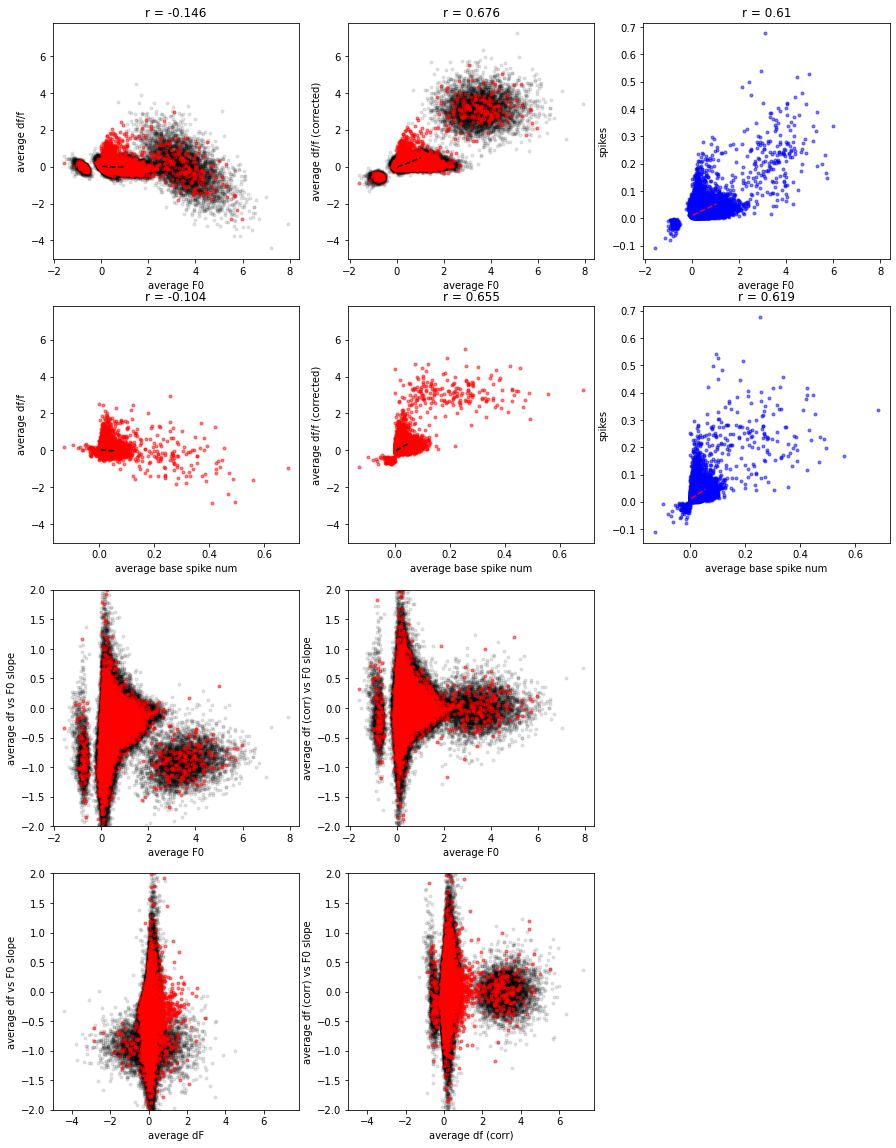

In [10]:
#plot correlations between average amplitudes, variances, f0s, baseline firing rates for each method
session = sessions[1]
shuffled_fstart = np.asarray(photostim_data_dict[session]['shuffled_mean_f0s'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]-1
shuffled_df = np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]
shuffled_df_corr = np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]

fstart_list = []
df_list = []
df_corr_list = []
slope_list =[]
slope_corr_list = []
spikes_list = []
spikes_base_list = []
for f_start,df,df_corr,f0,spks,spks_base in zip(photostim_data_dict[session]['F_start'],
                                 photostim_data_dict[session]['dF'],
                                 photostim_data_dict[session]['dF_corr'],
                                 photostim_data_dict[session]['fitted_f0'],#
                                 photostim_data_dict[session]['spikes_amplitudes'],
                                      photostim_data_dict[session]['spikes_base']): #'F0'#'fitted_f0
    for f_start_g,df_g,df_corr_g,s_,s_b in zip(f_start,df,df_corr,spks,spks_base):
        needed = (np.isnan(f_start_g)==False) & (np.isnan(df_g)==False) & (np.isnan(df_corr_g)==False)
        slope, intercept = np.polyfit(f_start_g[needed],df_g[needed],1)
        slope_corr, intercept_corr = np.polyfit(f_start_g[needed],df_corr_g[needed],1)
        fstart_list.append(np.nanmean(f_start_g)/f0-1)
        spikes_base_list.append(np.nanmean(s_b)/f0)#
        df_list.append(np.nanmean(df_g)/f0)
        ####df_list.append(np.nanmean(np.asarray(df_g)/np.asarray(f_start_g))/f0)
        df_corr_list.append(np.nanmean(df_corr_g)/f0)
        spikes_list.append(np.nanmean(s_)/f0)#-np.nanmean(s_b)
        slope_list.append(slope)
        slope_corr_list.append(slope_corr)
        
    


fig = plt.figure(figsize = [15,20])
ax_norm = fig.add_subplot(4,3,1)
ax_norm.plot(shuffled_fstart.flatten(),shuffled_df.flatten(),'k.',alpha = .1)
ax_norm.plot(fstart_list,df_list,'r.',alpha = .5)
ax_norm.set_xlabel('average F0')
ax_norm.set_ylabel('average df/f')
x = np.asarray(fstart_list)
y = np.asarray(df_list)
needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed_]
y = y[needed_]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax_norm.plot(xx,yy,'k--')
ax_norm.set_title('r = {}'.format(np.round(r[1][0],3)))


ax_corr = fig.add_subplot(4,3,2,sharex = ax_norm,sharey = ax_norm)
ax_corr.plot(shuffled_fstart.flatten(),shuffled_df_corr.flatten(),'k.',alpha = .1)
ax_corr.plot(fstart_list,df_corr_list,'r.',alpha = .5)
ax_corr.set_xlabel('average F0')
ax_corr.set_ylabel('average df/f (corrected)')

x = np.asarray(fstart_list)
y = np.asarray(df_corr_list)
needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed_]
y = y[needed_]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax_corr.plot(xx,yy,'k--')
ax_corr.set_title('r = {}'.format(np.round(r[1][0],3)))
#ax_corr.set_ylim([-2,5])

ax_spks = fig.add_subplot(4,3,3,sharex = ax_norm)
#ax_spks.plot(shuffled_fstart.flatten(),shuffled_df_corr.flatten(),'k.',alpha = .1)
ax_spks.plot(fstart_list,spikes_list,'b.',alpha = .5)
ax_spks.set_xlabel('average F0')
ax_spks.set_ylabel('spikes')

x = np.asarray(fstart_list)
y = np.asarray(spikes_list)
needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed_]
y = y[needed_]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax_spks.plot(xx,yy,'r--')
ax_spks.set_title('r = {}'.format(np.round(r[1][0],3)))




ax_norm_s = fig.add_subplot(4,3,4,sharey = ax_norm)
#ax_norm_s.plot(shuffled_fstart.flatten(),shuffled_df.flatten(),'k.',alpha = .1)
ax_norm_s.plot(spikes_base_list,df_list,'r.',alpha = .5)
ax_norm_s.set_xlabel('average base spike num')
ax_norm_s.set_ylabel('average df/f')

x = np.asarray(spikes_base_list)
y = np.asarray(df_list)
needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed_]
y = y[needed_]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax_norm_s.plot(xx,yy,'k--')
ax_norm_s.set_title('r = {}'.format(np.round(r[1][0],3)))


ax_corr_s = fig.add_subplot(4,3,5,sharex = ax_norm_s,sharey = ax_norm)
#ax_corr_s.plot(shuffled_fstart.flatten(),shuffled_df_corr.flatten(),'k.',alpha = .1)
ax_corr_s.plot(spikes_base_list,df_corr_list,'r.',alpha = .5)
ax_corr_s.set_xlabel('average base spike num')
ax_corr_s.set_ylabel('average df/f (corrected)')
x = np.asarray(spikes_base_list)
y = np.asarray(df_corr_list)
needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed_]
y = y[needed_]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax_corr_s.plot(xx,yy,'k--')
ax_corr_s.set_title('r = {}'.format(np.round(r[1][0],3)))






ax_spks_s = fig.add_subplot(4,3,6,sharex = ax_norm_s)
#ax_spks.plot(shuffled_fstart.flatten(),shuffled_df_corr.flatten(),'k.',alpha = .1)
ax_spks_s.plot(spikes_base_list,spikes_list,'b.',alpha = .5)
ax_spks_s.set_xlabel('average base spike num')
ax_spks_s.set_ylabel('spikes')
x = np.asarray(spikes_base_list)
y = np.asarray(spikes_list)
needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed_]
y = y[needed_]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax_spks_s.plot(xx,yy,'r--')
ax_spks_s.set_title('r = {}'.format(np.round(r[1][0],3)))




ax_slope = fig.add_subplot(4,3,7)
needed_shuffled = shuffled_df_corr.flatten()>-1000
needed_photostim = np.asarray(df_corr_list)>-1000
ax_slope.plot(shuffled_fstart.flatten(),np.asarray(photostim_data_dict[session]['shuffled_mean_amplitude_slopes']).flatten(),'k.',alpha = .1)
ax_slope.plot(fstart_list,slope_list,'r.',alpha = .5)
ax_slope.set_xlabel('average F0')
ax_slope.set_ylabel('average df vs F0 slope')
ax_slope_corr = fig.add_subplot(4,3,8,sharex = ax_slope,sharey = ax_slope)
ax_slope_corr.plot(shuffled_fstart.flatten()[needed_shuffled],np.asarray(photostim_data_dict[session]['shuffled_mean_amplitude_slopes_corrected']).flatten()[needed_shuffled],'k.',alpha = .1)
ax_slope_corr.plot(np.asarray(fstart_list)[needed_photostim],np.asarray(slope_corr_list)[needed_photostim],'r.',alpha = .5)
ax_slope_corr.set_xlabel('average F0')
ax_slope_corr.set_ylabel('average df (corr) vs F0 slope')
ax_slope.set_ylim([-2,2])



ax_slope = fig.add_subplot(4,3,10)
ax_slope.plot(shuffled_df.flatten(),np.asarray(photostim_data_dict[session]['shuffled_mean_amplitude_slopes']).flatten(),'k.',alpha = .1)
ax_slope.plot(df_list,slope_list,'r.',alpha = .5)
ax_slope.set_xlabel('average dF')
ax_slope.set_ylabel('average df vs F0 slope')
ax_slope_corr = fig.add_subplot(4,3,11,sharex = ax_slope,sharey = ax_slope)
ax_slope_corr.plot(shuffled_df_corr.flatten(),np.asarray(photostim_data_dict[session]['shuffled_mean_amplitude_slopes_corrected']).flatten(),'k.',alpha = .1)
ax_slope_corr.plot(df_corr_list,slope_corr_list,'r.',alpha = .5)
ax_slope_corr.set_xlabel('average df (corr)')
ax_slope_corr.set_ylabel('average df (corr) vs F0 slope')
ax_slope.set_ylim([-2,2])

In [11]:
# correlations between different amplitude measures, and distribution of changes

session_i = 1
session = sessions[session_i]
min_dist = 0
max_dist = 60
needed_cells = np.asarray(photostim_data_dict[session]['fitted_tau'])>minimum_time_constant

distances_flat = np.asarray(distances_matrix).T[needed_cells].flatten()
df_flat = np.asarray(photostim_data_dict[session][to_show])[needed_cells].flatten()#mean_df#mean_impact
df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr'])[needed_cells].flatten()
oasis_flat = (np.asarray(photostim_data_dict[session]['mean_dspikes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis])[needed_cells].flatten()#mean_df#mean_impact
needed = (distances_flat<max_dist) &(distances_flat>min_dist) &(repeats_flat<=maximum_repeats)&(repeats_flat>=minimum_repeats)
#plt.plot(oasis_flat[needed],df_corr_flat[needed],'k.',alpha = .1)
df_1 =  np.asarray(photostim_data_dict[session][to_show+'_1st_half'])[needed_cells].flatten()[needed]
df_2 =  np.asarray(photostim_data_dict[session][to_show+'_2nd_half'])[needed_cells].flatten()[needed]
#plt.hist((df_1-df_2)/((df_1+df_2)/2),np.arange(-10,10,.1))
df_1_corr =  np.asarray(photostim_data_dict[session][to_show+'_corr_1st_half'])[needed_cells].flatten()[needed]
df_2_corr =  np.asarray(photostim_data_dict[session][to_show+'_corr_2nd_half'])[needed_cells].flatten()[needed]
df_1_spikes =  np.asarray(photostim_data_dict[session]['mean_dspikes_1st_half'])[needed_cells].flatten()[needed]
df_2_spikes =  np.asarray(photostim_data_dict[session]['mean_dspikes_2nd_half'])[needed_cells].flatten()[needed]
fig = plt.figure(figsize = [10,10])
ax_hist = fig.add_subplot(2,2,1)
ax_hist.hist((df_1-df_2)/np.diff(np.percentile(df_1,[10,90])),np.arange(-1,1,.05),color = 'black',alpha = .5)#-.2
ax_hist.hist((df_1_corr-df_2_corr)/np.diff(np.percentile(df_1_corr,[10,90])),np.arange(-1,1,.05),alpha = .5,color = 'red')
ax_hist.hist((df_1_spikes-df_2_spikes)/np.diff(np.percentile(df_1_spikes,[10,90])),np.arange(-1,1,.05),alpha = .5,color = 'blue')#/2.5+.1
ax_hist.set_xlabel('(half1-half2)/(5-95 percentile range)')

ax_df_vs_dfcorr = fig.add_subplot(2,2,2)
ax_df_vs_dfcorr.plot(df_flat,df_corr_flat,'k.',alpha = .1)
ax_df_vs_dfcorr.set_xlabel('df raw')
ax_df_vs_dfcorr.set_ylabel('df corrected')
ax_df_vs_oasis = fig.add_subplot(2,2,4)
ax_df_vs_oasis.plot(df_flat,oasis_flat,'k.',alpha = .1)
ax_df_vs_oasis.set_xlabel('df raw')
ax_df_vs_oasis.set_ylabel('spikes')
ax_dfcorr_vs_oasis = fig.add_subplot(2,2,3)
ax_dfcorr_vs_oasis.plot(df_corr_flat,oasis_flat,'k.',alpha = .1)
ax_dfcorr_vs_oasis.set_xlabel('df corrected')
ax_dfcorr_vs_oasis.set_ylabel('spikes')

ax_df_vs_oasis.set_xlim([-.5,2])
ax_df_vs_dfcorr.set_xlim([-.5,2])

NameError: name 'minimum_time_constant' is not defined

In [11]:
sessions_to_compare

NameError: name 'sessions_to_compare' is not defined

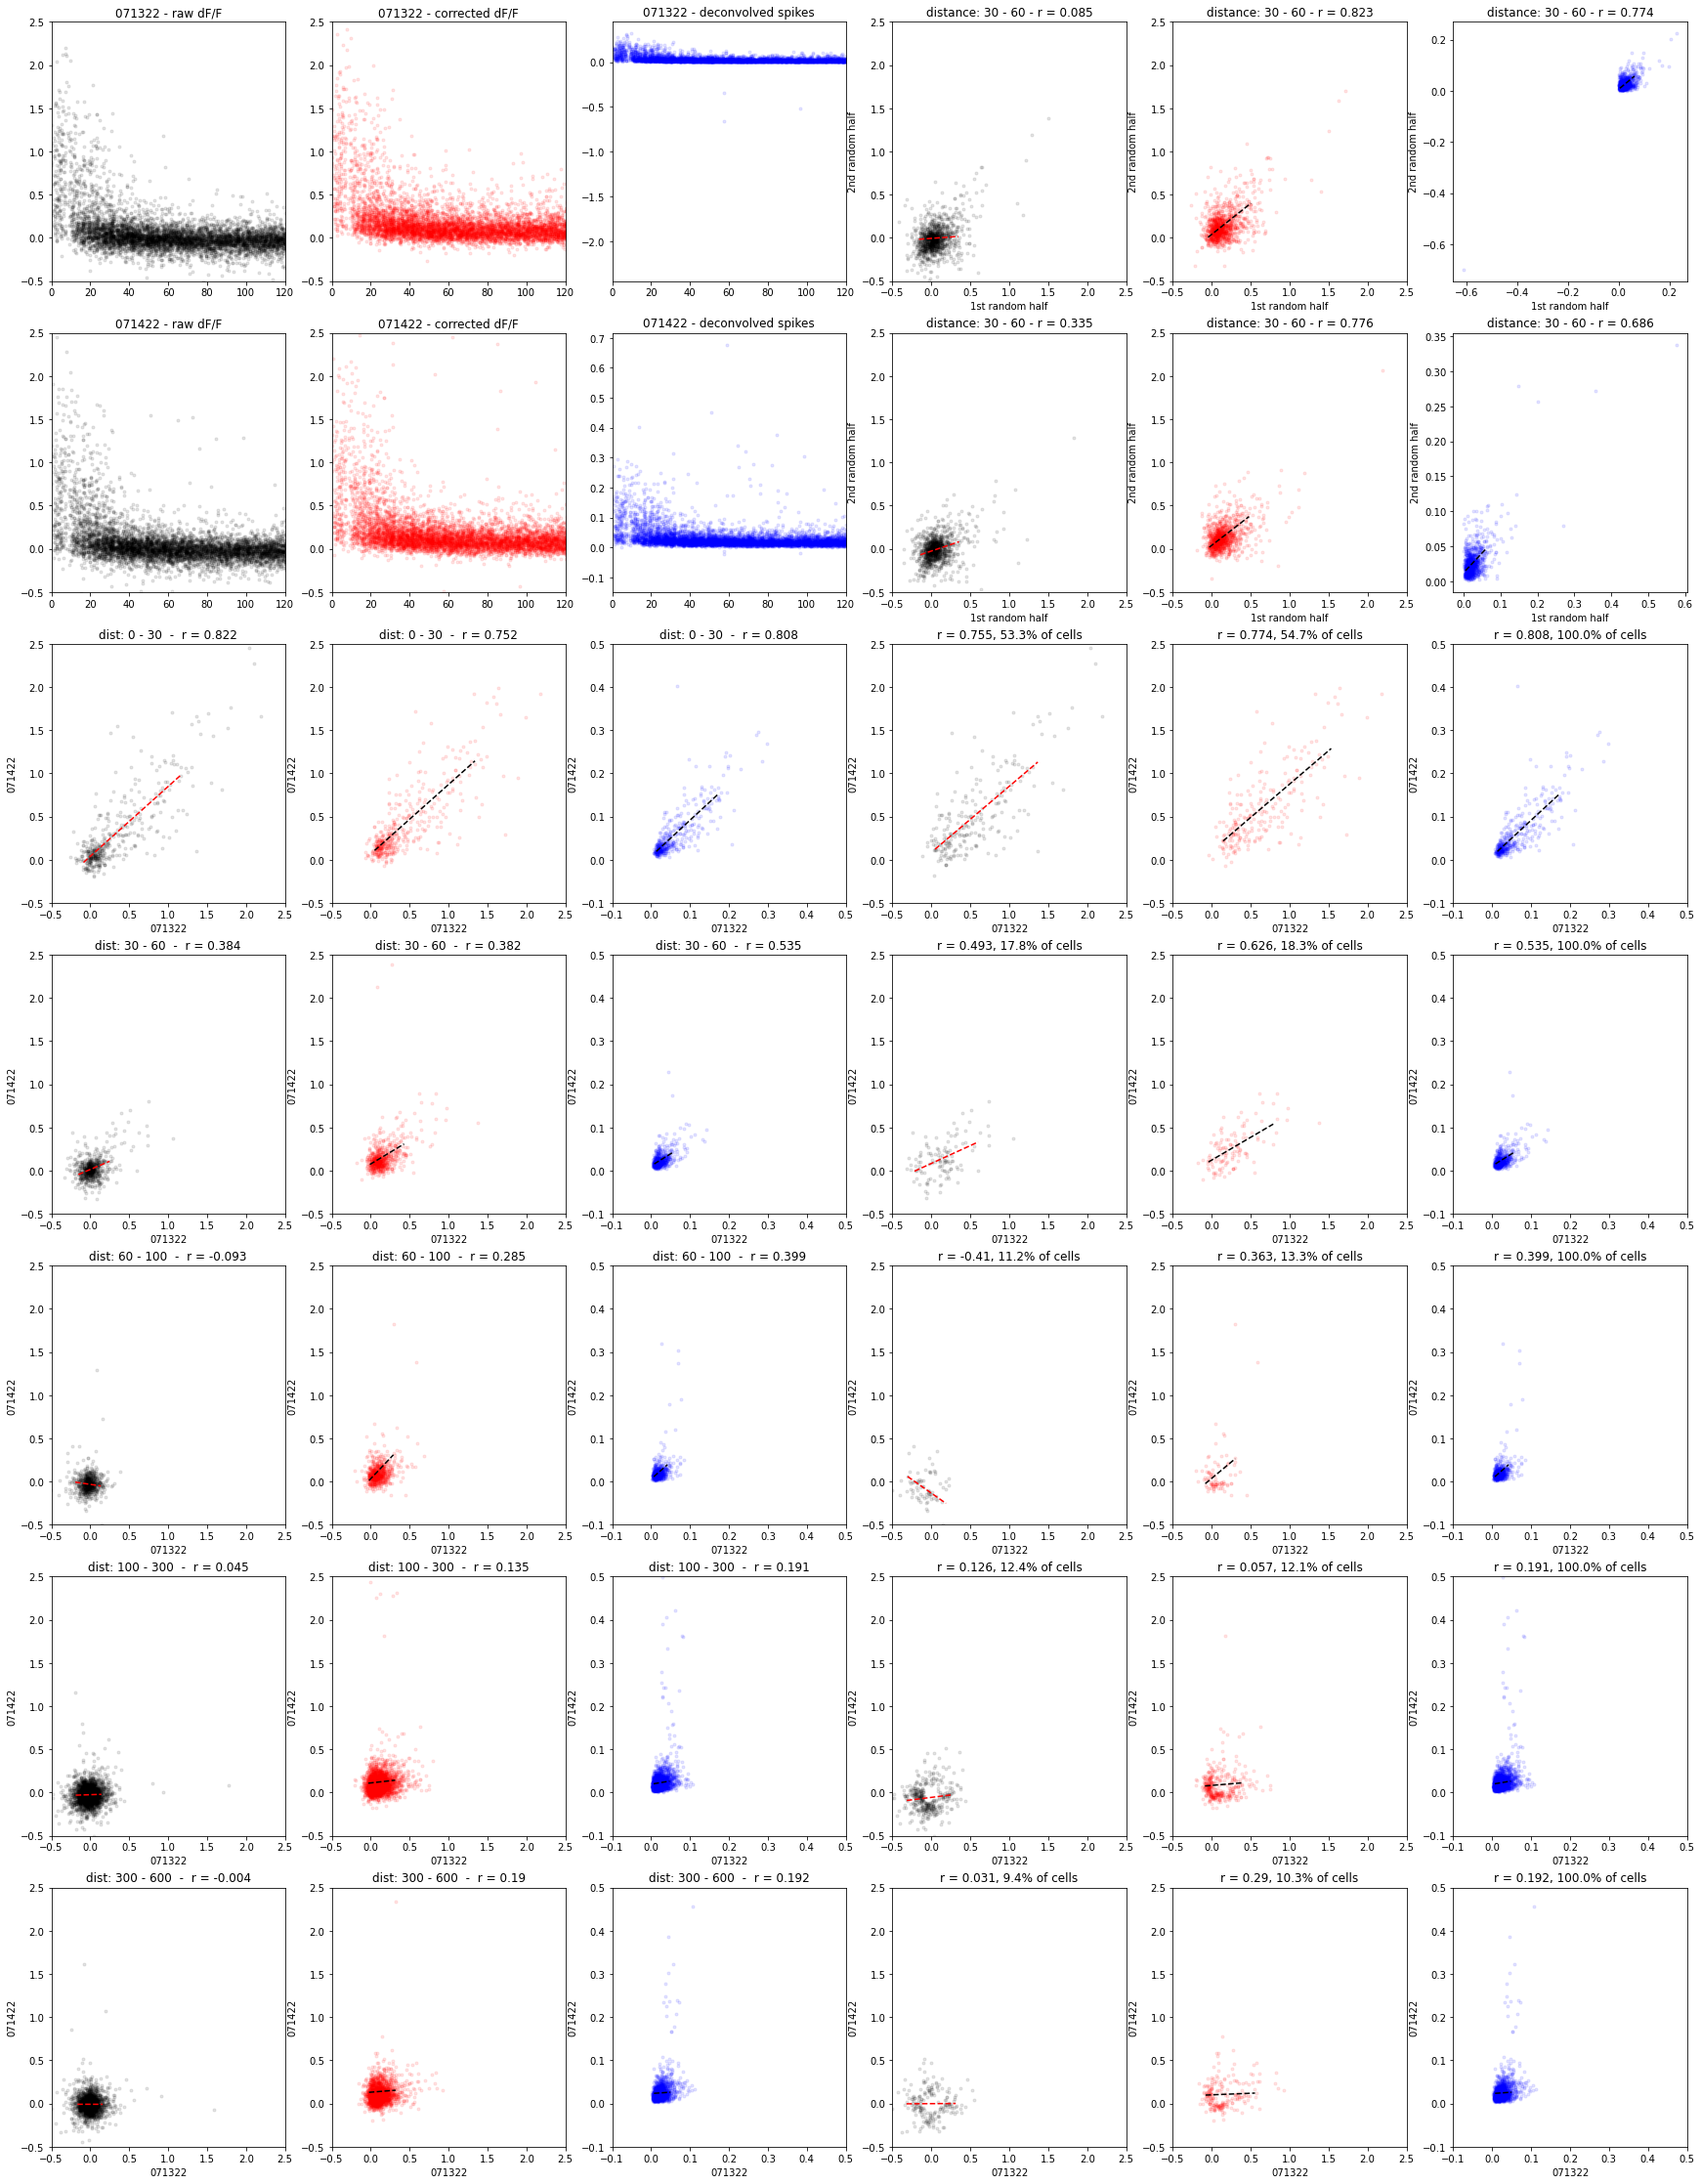

In [12]:


to_show = 'mean_df'#'mean_df_bootstrapped'#'mean_df_matched'#'mean_impact_matched'#'mean_df'#'mean_df_matched'#'mean_df'#mean_impact#mean_df#mean_dspikes

fig = plt.figure(figsize = [30, 40])
pval = .05

#tau_thresholds = [.5,5]
sessions_to_compare = sessions#['071322','071422']#[
df_list = []
df_corr_list = []
tau_list = []
f0_list = []
min_dist_list = [0,30,60,100,300]
max_dist_list = [30,60,100,300,600]
if 'impact' in to_show:
    limits = [-5,20]
else:
    limits = [-.5,2.5]
limits_spikes = [-.1,.5]
plot_row_count = 2+len(min_dist_list)
min_dist = 30
max_dist = 60
minimum_time_constant = 0

minimum_repeats = 20
maximum_repeats = 2022

for session_i in range(len(sessions_to_compare)):
    needed_cells = np.asarray(photostim_data_dict[session]['fitted_tau'])>minimum_time_constant
    session = sessions_to_compare[session_i]
    distances_flat = np.asarray(distances_matrix).T[needed_cells].flatten()
    df_flat = np.asarray(photostim_data_dict[session][to_show])[needed_cells].flatten()#mean_df#mean_impact
    oasis_flat = (np.asarray(photostim_data_dict[session]['mean_dspikes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis])[needed_cells].flatten()#mean_df#mean_impact
    if 'matched' in to_show:
        repeats_flat = np.asarray(photostim_data_dict[session]['repeats_matched'])[needed_cells].flatten()#mean_df#mean_impact
    else:
        repeats_flat = np.asarray(photostim_data_dict[session]['repeats'])[needed_cells].flatten()#mean_df#mean_impact
    try:
        df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr'])[needed_cells].flatten()#mean_df_corr#mean_impact_corr
    except:
        print('corrected values could not be loaded')
        df_corr_flat = df_flat
    alpha = .1
    ax_distance_dependence = fig.add_subplot(plot_row_count,6,1+6*session_i)
    ax_distance_dependence.plot(distances_flat,df_flat,'k.',alpha = alpha)
    ax_distance_dependence_corr = fig.add_subplot(plot_row_count,6,2+6*session_i,sharey = ax_distance_dependence,sharex = ax_distance_dependence)
    ax_distance_dependence_corr.plot(distances_flat,df_corr_flat,'r.',alpha = alpha)
    ax_distance_dependence.set_title('{} - raw dF/F'.format(session))
    ax_distance_dependence_corr.set_title('{} - corrected dF/F'.format(session))
    
    ax_distance_dependence_oasis = fig.add_subplot(plot_row_count,6,3+6*session_i,sharex = ax_distance_dependence)
    ax_distance_dependence_oasis.plot(distances_flat,oasis_flat,'b.',alpha = alpha)
    ax_distance_dependence_oasis.set_title('{} - deconvolved spikes'.format(session))

    ax_distance_dependence.set_xlim([0,120])
    ax_distance_dependence.set_ylim(limits)
    ax_distance_dependence_corr.set_ylim(limits)
    needed = (distances_flat<max_dist) &(distances_flat>min_dist) &(repeats_flat<=maximum_repeats)&(repeats_flat>=minimum_repeats)
    
    ax_1st_second_half_nocorr = fig.add_subplot(plot_row_count,6,4+6*session_i)
    try:
        df_1 =  np.asarray(photostim_data_dict[session][to_show+'_1st_half'])[needed_cells].flatten()[needed]
        df_2 =  np.asarray(photostim_data_dict[session][to_show+'_2nd_half'])[needed_cells].flatten()[needed]
        ax_1st_second_half_nocorr.plot(df_1,df_2,'k.',alpha = .1)
    except:
        print('half day values could not be loaded')
        pass
    x = df_1
    y = df_2
    needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
    x = x[needed_]
    y = y[needed_]
    r = np.corrcoef(x,y)
    p = np.polyfit(x,y,1)
    xx = np.percentile(x,[5,95])
    yy = np.polyval(p,xx)
    ax_1st_second_half_nocorr.plot(xx,yy,'r--')
    ax_1st_second_half_nocorr.set_xlim(limits)
    ax_1st_second_half_nocorr.set_ylim(limits)
    ax_1st_second_half_nocorr.set_title('distance: {} - {} - r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
    ax_1st_second_half_nocorr.set_xlabel('1st random half')
    ax_1st_second_half_nocorr.set_ylabel('2nd random half')
    
    ax_1st_second_half_corr = fig.add_subplot(plot_row_count,6,5+6*session_i)
    try:
        df_1 =  np.asarray(photostim_data_dict[session][to_show+'_corr_1st_half'])[needed_cells].flatten()[needed]
        df_2 =  np.asarray(photostim_data_dict[session][to_show+'_corr_2nd_half'])[needed_cells].flatten()[needed]
        ax_1st_second_half_corr.plot(df_1,df_2,'r.',alpha = .1)
    except:
        print('corrected values could not be loaded')

        pass
    
    
    
    x = df_1
    y = df_2
    needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
    x = x[needed_]
    y = y[needed_]
    r = np.corrcoef(x,y)
    p = np.polyfit(x,y,1)
    xx = np.percentile(x,[5,95])
    yy = np.polyval(p,xx)
    ax_1st_second_half_corr.plot(xx,yy,'k--')
    ax_1st_second_half_corr.set_xlim(limits)
    ax_1st_second_half_corr.set_ylim(limits)
    ax_1st_second_half_corr.set_title('distance: {} - {} - r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
    ax_1st_second_half_corr.set_xlabel('1st random half')
    ax_1st_second_half_corr.set_ylabel('2nd random half')

    
    ax_1st_second_half_oasis = fig.add_subplot(plot_row_count,6,6+6*session_i)
    df_1 =  (np.asarray(photostim_data_dict[session]['mean_dspikes_1st_half'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis])[needed_cells].flatten()[needed]
    df_2 =  (np.asarray(photostim_data_dict[session]['mean_dspikes_2nd_half'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis])[needed_cells].flatten()[needed]
    ax_1st_second_half_oasis.plot(df_1,df_2,'b.',alpha = .1)
    x = df_1
    y = df_2
    needed_ = (np.isnan(x)==False) & (np.isnan(y)==False)
    x = x[needed_]
    y = y[needed_]
    r = np.corrcoef(x,y)
    p = np.polyfit(x,y,1)
    xx = np.percentile(x,[5,95])
    yy = np.polyval(p,xx)
    ax_1st_second_half_oasis.plot(xx,yy,'k--')
    # ax_1st_second_half_oasis.set_xlim(limits)
    # ax_1st_second_half_oasis.set_ylim(limits)
    ax_1st_second_half_oasis.set_title('distance: {} - {} - r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
    ax_1st_second_half_oasis.set_xlabel('1st random half')
    ax_1st_second_half_oasis.set_ylabel('2nd random half')
    
    
    
    df_list.append(df_flat[needed])
    df_corr_list.append(df_corr_flat[needed])
    f0_list.append(photostim_data_dict[session]['fitted_f0'])
    tau_list.append(photostim_data_dict[session]['fitted_tau'])
for only_significant_connections in [False,True]:
    for i,(min_dist,max_dist) in enumerate(zip(min_dist_list,max_dist_list)):
        needed_cells = np.min(np.asarray(tau_list),0)>minimum_time_constant
        df_list = []
        df_corr_list = []
        percentiles_list = []
        percentiles_corr_list = []
        repeats_list = []
        spikes_list = []
        for session_i in range(len(sessions_to_compare)):
            session = sessions_to_compare[session_i]
            percentiles_list.append(np.asarray(photostim_data_dict[session]['percentile'])[needed_cells].flatten())
            percentiles_corr_list.append(np.asarray(photostim_data_dict[session]['percentile_corr'])[needed_cells].flatten())
            if 'matched' in to_show:
                repeats_list.append(np.asarray(photostim_data_dict[session]['repeats_matched'])[needed_cells].flatten())
            else:
                repeats_list.append(np.asarray(photostim_data_dict[session]['repeats'])[needed_cells].flatten())
        repeats_list = np.asarray(repeats_list)
        for session_i in range(len(sessions_to_compare)):
            session = sessions_to_compare[session_i]
            distances_flat = np.asarray(distances_matrix).T[needed_cells].flatten()
            df_flat = np.asarray(photostim_data_dict[session][to_show])[needed_cells].flatten()#mean_df#mean_impact
            spikes_flat = (np.asarray(photostim_data_dict[session]['mean_dspikes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis])[needed_cells].flatten()#mean_df#mean_impact
            repeats_flat = np.asarray(photostim_data_dict[session]['repeats'])[needed_cells].flatten()#mean_df#mean_impact
            
            try:
                df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr'])[needed_cells].flatten()#mean_df_corr#mean_impact_corr
            except:
                print('corrected values could not be loaded')
                df_corr_flat = df_flat

            if only_significant_connections:
                needed_raw = (distances_flat<max_dist) &(distances_flat>min_dist) & ((np.nanmin(percentiles_list,0)<pval) | (np.nanmax(percentiles_list,0)>1-pval)) &(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
                needed_all = (distances_flat<max_dist) &(distances_flat>min_dist) &(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
                needed_corr = (distances_flat<max_dist) &(distances_flat>min_dist) & ((np.nanmin(percentiles_corr_list,0)<pval) | (np.nanmax(percentiles_corr_list,0)>1-pval)) &(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
                needed_spikes = (distances_flat<max_dist) &(distances_flat>min_dist) &(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
            else:
                needed_raw = (distances_flat<max_dist) &(distances_flat>min_dist) &(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
                needed_corr = (distances_flat<max_dist) &(distances_flat>min_dist)&(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
                needed_spikes = (distances_flat<max_dist) &(distances_flat>min_dist) &(np.max(repeats_list,0)<=maximum_repeats)&(np.min(repeats_list,0)>=minimum_repeats)
            
            df_list.append(df_flat[needed_raw])
            df_corr_list.append(df_corr_flat[needed_corr])
            spikes_list.append(spikes_flat[needed_spikes])
            
        if only_significant_connections:
            ax_d1d2 = fig.add_subplot(plot_row_count,6,16+6*i)
        else:
            ax_d1d2 = fig.add_subplot(plot_row_count,6,13+6*i)
        ax_d1d2.plot(df_list[0],df_list[1],'k.',alpha = .1)
        x = df_list[0]
        y = df_list[1]
        needed = (np.isnan(x)==False) & (np.isnan(y)==False)
        x = x[needed]
        y = y[needed]
        r = np.corrcoef(x,y)
        p = np.polyfit(x,y,1)
        xx = np.percentile(x,[5,95])
        yy = np.polyval(p,xx)
        ax_d1d2.plot(xx,yy,'r--')
        if only_significant_connections:
            ax_d1d2.set_title('r = {}, {:.1f}% of cells'.format(np.round(r[1][0],3),np.sum(needed_raw)/np.sum(needed_all)*100))
        else:
            ax_d1d2.set_title('dist: {} - {}  -  r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
        ax_d1d2.set_xlabel(sessions_to_compare[0])
        ax_d1d2.set_ylabel(sessions_to_compare[1])
        
        
        
        
        
        if only_significant_connections:
            ax_d1d2_corr = fig.add_subplot(plot_row_count,6,17+6*i,sharex = ax_d1d2,sharey = ax_d1d2)
        else:
            ax_d1d2_corr = fig.add_subplot(plot_row_count,6,14+6*i,sharex = ax_d1d2,sharey = ax_d1d2)
        ax_d1d2_corr.plot(df_corr_list[0],df_corr_list[1],'r.',alpha = .1)
        x = df_corr_list[0]
        y = df_corr_list[1]
        needed = (np.isnan(x)==False) & (np.isnan(y)==False)
        x = x[needed]
        y = y[needed]
        r = np.corrcoef(x,y)
        p = np.polyfit(x,y,1)
        xx = np.percentile(x,[5,95])
        yy = np.polyval(p,xx)
        ax_d1d2_corr.plot(xx,yy,'k--')
        if only_significant_connections:
            ax_d1d2_corr.set_title('r = {}, {:.1f}% of cells'.format(np.round(r[1][0],3),np.sum(needed_corr)/np.sum(needed_all)*100))
        else:
            ax_d1d2_corr.set_title('dist: {} - {}  -  r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
        ax_d1d2_corr.set_xlim(limits)
        ax_d1d2_corr.set_ylim(limits)
        ax_d1d2_corr.set_xlabel(sessions_to_compare[0])
        ax_d1d2_corr.set_ylabel(sessions_to_compare[1])
        
        
        if only_significant_connections:
            ax_d1d2_spikes = fig.add_subplot(plot_row_count,6,18+6*i)#,sharex = ax_d1d2,sharey = ax_d1d2)
        else:
            ax_d1d2_spikes = fig.add_subplot(plot_row_count,6,15+6*i)#,sharex = ax_d1d2,sharey = ax_d1d2)
        ax_d1d2_spikes.plot(spikes_list[0],spikes_list[1],'b.',alpha = .1)
        x = spikes_list[0]
        y = spikes_list[1]
        needed = (np.isnan(x)==False) & (np.isnan(y)==False)
        x = x[needed]
        y = y[needed]
        r = np.corrcoef(x,y)
        p = np.polyfit(x,y,1)
        xx = np.percentile(x,[5,95])
        yy = np.polyval(p,xx)
        ax_d1d2_spikes.plot(xx,yy,'k--')
        if only_significant_connections:
            ax_d1d2_spikes.set_title('r = {}, {:.1f}% of cells'.format(np.round(r[1][0],3),np.sum(needed_spikes)/np.sum(needed_all)*100))
        else:
            ax_d1d2_spikes.set_title('dist: {} - {}  -  r = {}'.format(min_dist,max_dist,np.round(r[1][0],3)))
        ax_d1d2_spikes.set_xlim(limits_spikes)
        ax_d1d2_spikes.set_ylim(limits_spikes)
        ax_d1d2_spikes.set_xlabel(sessions_to_compare[0])
        ax_d1d2_spikes.set_ylabel(sessions_to_compare[1])



Text(0, 0.5, 'variance of amplitudes (corrected)')

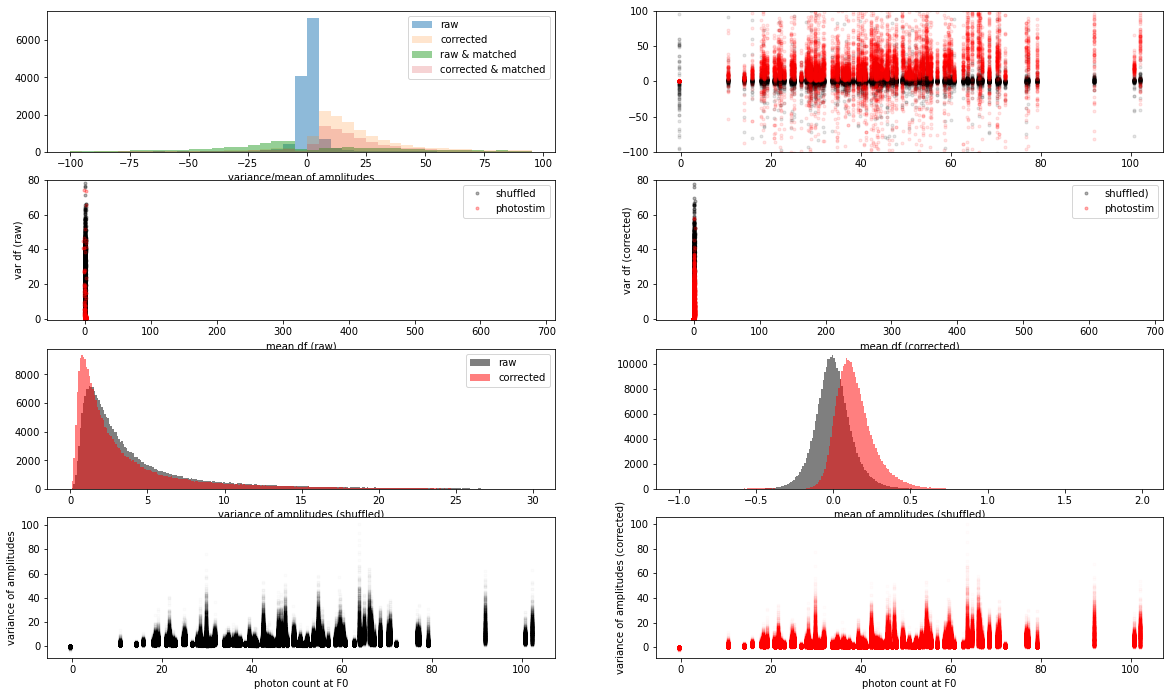

In [12]:
session = sessions[1]
fig = plt.figure(figsize = [20,15])
ax_var_per_mean_hist = fig.add_subplot(5,2,1)
ax_var_per_mean_hist.hist(np.asarray(photostim_data_dict[session]['var_df']).flatten()/np.asarray(photostim_data_dict[session]['mean_df']).flatten(),np.arange(-100,100,5),alpha = .5,label = 'raw')
ax_var_per_mean_hist.hist(np.asarray(photostim_data_dict[session]['var_df_corr']).flatten()/np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten(),np.arange(-100,100,5),alpha = .2,label = 'corrected')
ax_var_per_mean_hist.hist(np.asarray(photostim_data_dict[session]['var_df_matched']).flatten()/np.asarray(photostim_data_dict[session]['mean_df_matched']).flatten(),np.arange(-100,100,5),alpha = .5,label = 'raw & matched')
ax_var_per_mean_hist.hist(np.asarray(photostim_data_dict[session]['var_df_matched_corr']).flatten()/np.asarray(photostim_data_dict[session]['mean_df_matched_corr']).flatten(),np.arange(-100,100,5),alpha = .2,label = 'corrected & matched')

ax_var_per_mean_hist.legend()
ax_var_per_mean_hist.set_xlabel('variance/mean of amplitudes')
# plt.yscale('log')
# plt.xscale('log')

ax_var_per_mean_vs_photon_count = fig.add_subplot(5,2,2)
varpermean = np.asarray(photostim_data_dict[session]['var_df']).flatten()/np.asarray(photostim_data_dict[session]['mean_df']).flatten()
varpermean_corr = np.asarray(photostim_data_dict[session]['var_df_corr']).flatten()/np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten()
photon_count = (photostim_data_dict[session]['baseline_photon_counts'][:,np.newaxis]*np.ones(np.asarray(photostim_data_dict[session]['var_df']).shape)).flatten()
ax_var_per_mean_vs_photon_count.plot(photon_count,varpermean,'k.',alpha = .1)
ax_var_per_mean_vs_photon_count.plot(photon_count,varpermean_corr,'r.',alpha = .1)
ax_var_per_mean_vs_photon_count.set_ylim([-100,100])

baseline_photon_counts = (np.ones(np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes']).shape)*photostim_data_dict[session]['baseline_photon_counts'][:,np.newaxis,np.newaxis]).flatten()
shuffled_mean_df = (np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()
shuffled_mean_df_corr = (np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()
shuffled_var_df = (np.asarray(photostim_data_dict[session]['shuffled_var_amplitudes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()
shuffled_var_df_corr = (np.asarray(photostim_data_dict[session]['shuffled_var_amplitudes_corrected'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()

ax_var_vs_mean = fig.add_subplot(5,2,3)

ax_var_vs_mean.plot(shuffled_mean_df,shuffled_var_df,'k.',alpha = .3,label = 'shuffled')
ax_var_vs_mean.plot(np.asarray(photostim_data_dict[session]['mean_df']).flatten(),np.asarray(photostim_data_dict[session]['var_df']).flatten(),'r.',alpha = .3,label = 'photostim')
ax_var_vs_mean.legend()
ax_var_vs_mean.set_xlabel('mean df (raw)')
ax_var_vs_mean.set_ylabel('var df (raw)')

#ax_var_vs_mean.plot(np.asarray(photostim_data_dict[session]['mean_df']).flatten(),np.asarray(photostim_data_dict[session]['var_df']).flatten(),'k.',alpha = .1)

#ax_var_vs_mean.plot(np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten(),np.asarray(photostim_data_dict[session]['var_df_corr']).flatten()/(np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten()+0.2),'r.',alpha = .1)

#h,x,y,im = ax_var_vs_mean.hist2d(np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten(),np.asarray(photostim_data_dict[session]['var_df_corr']).flatten(),50)
#im.set_clim([0,50])



ax_var_vs_mean_corrected = fig.add_subplot(5,2,4,sharex = ax_var_vs_mean,sharey = ax_var_vs_mean)
ax_var_vs_mean_corrected.plot(shuffled_mean_df_corr,shuffled_var_df_corr,'k.',alpha = .3,label = 'shuffled)')
ax_var_vs_mean_corrected.plot(np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten(),np.asarray(photostim_data_dict[session]['var_df_corr']).flatten(),'r.',alpha = .3,label = 'photostim')
ax_var_vs_mean_corrected.legend()
ax_var_vs_mean_corrected.set_xlabel('mean df (corrected)')
ax_var_vs_mean_corrected.set_ylabel('var df (corrected)')
ax_var_vs_mean.set_ylim([-1,80])



ax_var_hist = fig.add_subplot(5,2,5)
needed = shuffled_mean_df>-111110
ax_var_hist.hist(shuffled_var_df[needed],np.arange(0,30,.1),alpha = .5,color = 'black',label = 'raw')
ax_var_hist.hist(shuffled_var_df_corr[needed],np.arange(0,30,.1),alpha = .5,color = 'red',label = 'corrected')
ax_var_hist.set_xlabel('variance of amplitudes (shuffled)')
ax_var_hist.legend()

# needed = np.asarray(photostim_data_dict[session]['mean_df']).flatten()>-111110
# ax_var_hist.hist(np.asarray(photostim_data_dict[session]['var_df']).flatten()[needed],np.arange(0,30,.1),alpha = .5,color = 'black',label = 'raw')
# ax_var_hist.hist(np.asarray(photostim_data_dict[session]['var_df_corr']).flatten()[needed],np.arange(0,30,.1),alpha = .5,color = 'red',label = 'corrected')
# ax_var_hist.set_xlabel('variance of amplitudes (photostim)')
# ax_var_hist.legend()


ax_mean_hist = fig.add_subplot(5,2,6)
needed = shuffled_mean_df>-111110
ax_mean_hist.hist(shuffled_mean_df[needed],np.arange(-1,2,.01),alpha = .5,color = 'black',label = 'raw')
ax_mean_hist.hist(shuffled_mean_df_corr[needed],np.arange(-1,2,.01),alpha = .5,color = 'red',label = 'corrected')
ax_mean_hist.set_xlabel('mean of amplitudes (shuffled)')

ax_photon_count_var = fig.add_subplot(5,2,7)
ax_photon_count_var.plot(baseline_photon_counts,shuffled_var_df,'k.',alpha = .01)
ax_photon_count_var.set_xlabel('photon count at F0')
ax_photon_count_var.set_ylabel('variance of amplitudes')
ax_photon_count_var = fig.add_subplot(5,2,8)
ax_photon_count_var.plot(baseline_photon_counts,shuffled_var_df_corr,'r.',alpha = .01)
ax_photon_count_var.set_xlabel('photon count at F0')
ax_photon_count_var.set_ylabel('variance of amplitudes (corrected)')

In [ ]:
shuffled_mean_df = (np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()
shuffled_mean_df_corr = (np.asarray(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()
shuffled_var_df = (np.asarray(photostim_data_dict[session]['shuffled_var_amplitudes'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()
shuffled_var_df_corr = (np.asarray(photostim_data_dict[session]['shuffled_var_amplitudes_corrected'])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis,np.newaxis]).flatten()

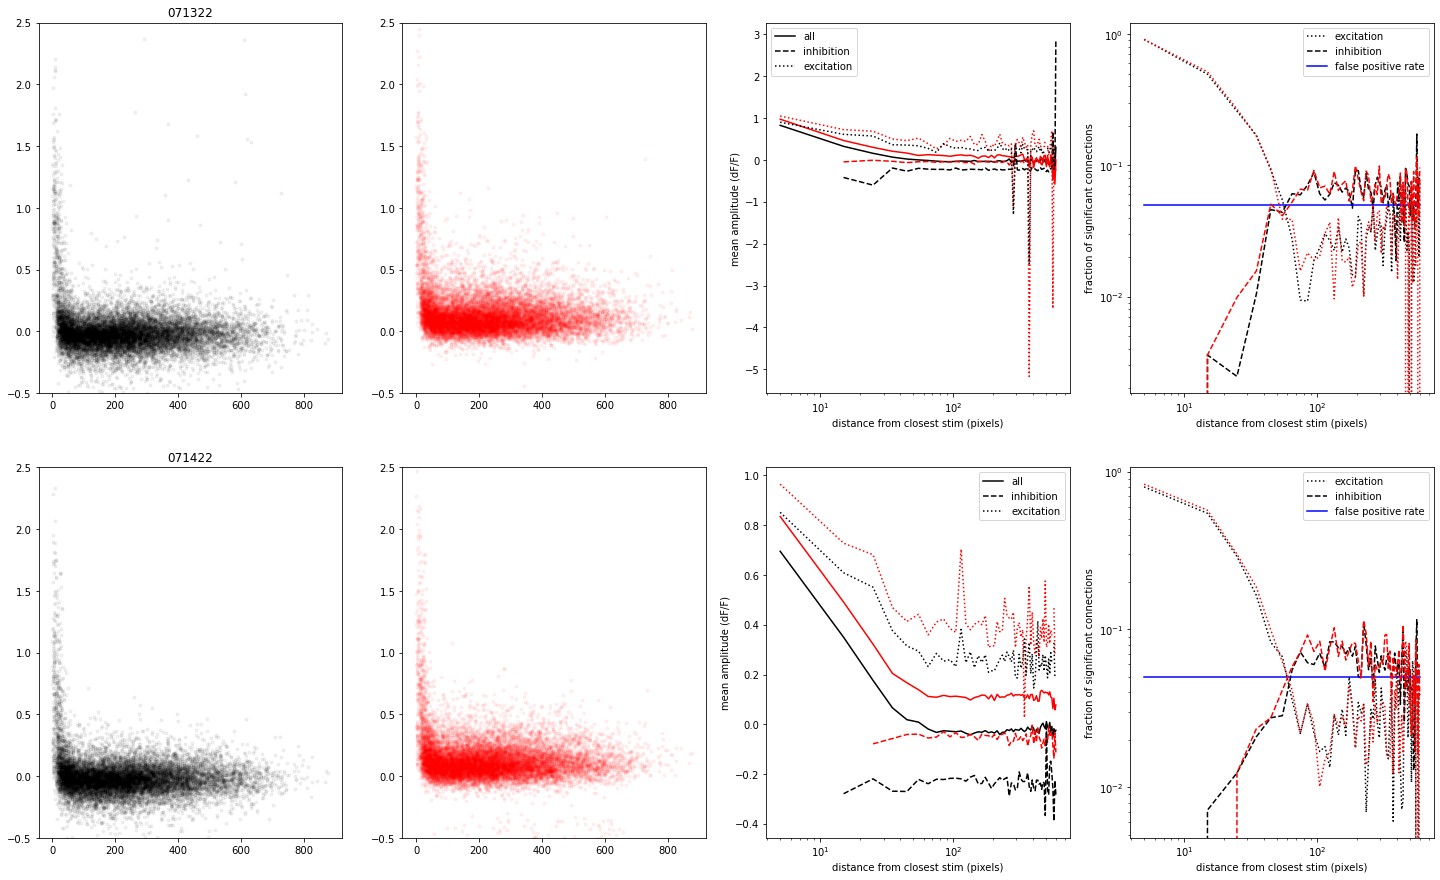

In [28]:

bin_step = 10
bin_size = 10
bin_end = 600
pval = .05
bin_centers = np.arange(bin_size/2,bin_end,bin_step)
fig = plt.figure(figsize = [25, 15])
to_show = 'mean_df'#'mean_df_bootstrapped' #mean_impact, mean_df
for session_i in range(len(sessions_to_compare)):
    session = sessions_to_compare[session_i]
    distances_flat = np.asarray(distances_matrix).T.flatten()
    df_flat = np.asarray(photostim_data_dict[session][to_show]).flatten()#mean_df#mean_impact
    df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr']).flatten()#mean_df_corr#mean_impact_corr
    #df_corr_flat = np.asarray(photostim_data_dict[session]['mean_dspikes']).flatten()#mean_df_corr#mean_impact_corr
    percentiles_flat = np.asarray(photostim_data_dict[session]['percentile']).flatten()
    percentiles_corr_flat = np.asarray(photostim_data_dict[session]['percentile_corr']).flatten()
    
    
    
    ax_distance_dependence = fig.add_subplot(2,4,1+4*session_i)
    ax_distance_dependence.plot(distances_flat,df_flat,'k.',alpha = .05)
    ax_distance_dependence_corr = fig.add_subplot(2,4,2+4*session_i,sharey = ax_distance_dependence)
    ax_distance_dependence_corr.plot(distances_flat,df_corr_flat,'r.',alpha = .05)
    ax_distance_dependence.set_title(session)
    
    ax_distance_dependence.set_ylim([-.5,2.5])
    
    bin_mean_df = []
    bin_mean_df_exc = []
    bin_mean_df_inh = []
    bin_mean_df_corr = []
    bin_mean_df_corr_exc = []
    bin_mean_df_corr_inh = []
    
    bin_n = []
    bin_n_exc = []
    bin_n_corr_exc = []
    bin_n_inh = []
    bin_n_corr_inh = []
    
    significantly_inhibited = percentiles_flat<pval
    significantly_inhibited_corr = percentiles_corr_flat<pval
    significantly_excited = percentiles_flat>1-pval
    significantly_excited_corr = percentiles_corr_flat>1-pval
    for c in bin_centers:
        needed = (distances_flat<c+bin_size/2) &(distances_flat>c-bin_size/2)
        bin_mean_df.append(np.nanmean(df_flat[needed]))
        bin_mean_df_corr.append(np.nanmean(df_corr_flat[needed]))
        bin_mean_df_inh.append(np.nanmean(df_flat[needed&significantly_inhibited]))
        bin_mean_df_corr_inh.append(np.nanmean(df_corr_flat[needed&significantly_inhibited_corr]))
        bin_mean_df_exc.append(np.nanmean(df_flat[needed&significantly_excited]))
        bin_mean_df_corr_exc.append(np.nanmean(df_corr_flat[needed&significantly_excited_corr]))
        bin_n.append(sum(needed))
        bin_n_exc.append(sum(needed&significantly_excited))
        bin_n_inh.append(sum(needed&significantly_inhibited))
        bin_n_corr_exc.append(sum(needed&significantly_excited_corr))
        bin_n_corr_inh.append(sum(needed&significantly_inhibited_corr))
    
    
    
    ax_means = fig.add_subplot(2,4,3+4*session_i)
    ax_means.plot(bin_centers,bin_mean_df,'k-',label = 'all')
    ax_means.plot(bin_centers,bin_mean_df_corr,'r-')
    ax_means.plot(bin_centers,bin_mean_df_corr_inh,'r--')
    ax_means.plot(bin_centers,bin_mean_df_inh,'k--',label = 'inhibition')
    ax_means.plot(bin_centers,bin_mean_df_corr_exc,'r:')
    ax_means.plot(bin_centers,bin_mean_df_exc,'k:',label = 'excitation')
    ax_means.set_xscale('log')
    ax_means.set_xlabel('distance from closest stim (pixels)')
    ax_means.set_ylabel('mean amplitude (dF/F)')
    ax_means.legend()
    
    ax_n = fig.add_subplot(2,4,4+4*session_i)
    ax_n.plot(bin_centers,np.asarray(bin_n_exc)/np.asarray(bin_n),'k:',label = 'excitation')
    ax_n.plot(bin_centers,np.asarray(bin_n_inh)/np.asarray(bin_n),'k--',label = 'inhibition')#/np.asarray(bin_n)
    ax_n.plot(bin_centers,np.ones(len(bin_centers))*pval,'b-',label = 'false positive rate')
    ax_n.plot(bin_centers,np.asarray(bin_n_corr_exc)/np.asarray(bin_n),'r:')#/np.asarray(bin_n)
    ax_n.plot(bin_centers,np.asarray(bin_n_corr_inh)/np.asarray(bin_n),'r--')#/np.asarray(bin_n)
    ax_n.legend()
    ax_n.set_yscale('log')
    ax_n.set_xscale('log')
    
    ax_n.set_xlabel('distance from closest stim (pixels)')
    ax_n.set_ylabel('fraction of significant connections')
    
    
    #ax_means.set_yscale('log')
    
    

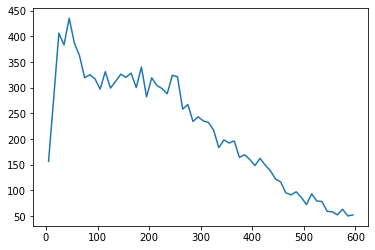

In [21]:
plt.plot(bin_centers,np.asarray(bin_n))

(0.0, 1.5)

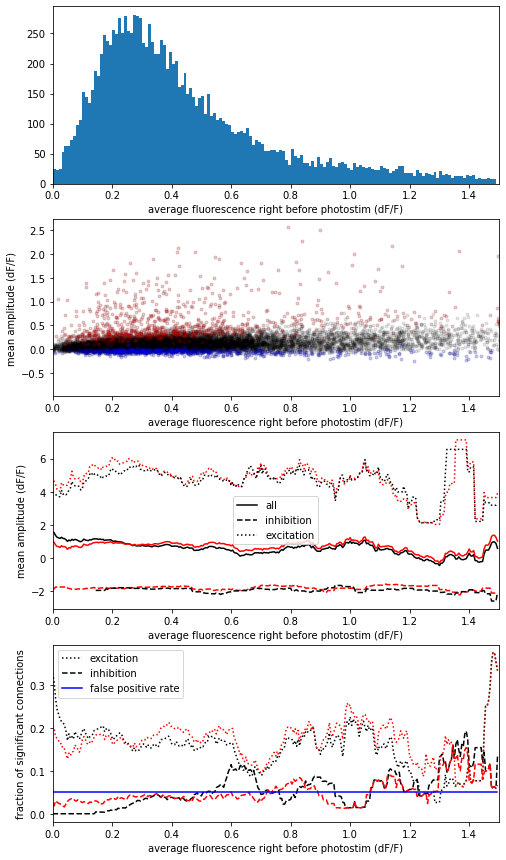

In [15]:


pval = .05

session = sessions[1]
to_show = 'mean_impact'#'mean_dspikes'#'mean_df'#mean_impact
x_values = 'mean_f_start'#mean_f_start,mean_min_df_corr,mean_spikes_start
min_dist = 0
max_dist = 100
if x_values == 'mean_min_df_corr':
    bin_step = .005
    bin_size = .05
    bin_start = -.8
    bin_end = 0
    x_label = 'maximum achivable inhibitory amplitude (dF/F)'
elif x_values == 'mean_f_start':
    bin_step = .005
    bin_size = .1
    bin_start = 0
    bin_end = 1.5
    x_label = 'average fluorescence right before photostim (dF/F)'
elif x_values == 'mean_spikes_start':
    bin_step = .05
    bin_size = .1
    bin_start = 0
    bin_end = 1.5
    x_label = 'average FR before photostim'
bin_centers = np.arange(bin_start,bin_end,bin_step)
perc = np.concatenate((photostim_data_dict[session]['percentile_corr']))
significant_inh = perc<.05
significant_exc = perc>.95
#plt.plot(np.concatenate((photostim_data_dict[session]['mean_min_df'])),np.concatenate((photostim_data_dict[session]['mean_df'])),'k.',alpha = .1)

distances_real   = np.asarray(distances_matrix).T.flatten()
needed = (distances_real<=max_dist)&(distances_real>=min_dist)

distances_flat = np.concatenate((photostim_data_dict[session][x_values]))[needed]
df_flat = np.asarray(photostim_data_dict[session][to_show]).flatten()[needed]#mean_df#mean_impact
try:
    df_corr_flat = np.asarray(photostim_data_dict[session][to_show+'_corr']).flatten()[needed]#mean_df_corr#mean_impact_corr
except:
    df_corr_flat = df_flat
percentiles_flat = np.asarray(photostim_data_dict[session]['percentile']).flatten()[needed]
percentiles_corr_flat = np.asarray(photostim_data_dict[session]['percentile_corr']).flatten()[needed]


bin_mean_df = []
bin_mean_df_exc = []
bin_mean_df_inh = []
bin_mean_df_corr = []
bin_mean_df_corr_exc = []
bin_mean_df_corr_inh = []

bin_n = []
bin_n_exc = []
bin_n_corr_exc = []
bin_n_inh = []
bin_n_corr_inh = []

significantly_inhibited = percentiles_flat<pval
significantly_inhibited_corr = percentiles_corr_flat<pval
significantly_excited = percentiles_flat>1-pval
significantly_excited_corr = percentiles_corr_flat>1-pval
for c in bin_centers:
    needed = (distances_flat<c+bin_size/2) &(distances_flat>c-bin_size/2)
    bin_mean_df.append(np.nanmean(df_flat[needed]))
    bin_mean_df_corr.append(np.nanmean(df_corr_flat[needed]))
    bin_mean_df_inh.append(np.nanmean(df_flat[needed&significantly_inhibited]))
    bin_mean_df_corr_inh.append(np.nanmean(df_corr_flat[needed&significantly_inhibited_corr]))
    bin_mean_df_exc.append(np.nanmean(df_flat[needed&significantly_excited]))
    bin_mean_df_corr_exc.append(np.nanmean(df_corr_flat[needed&significantly_excited_corr]))
    bin_n.append(sum(needed))
    bin_n_exc.append(sum(needed&significantly_excited))
    bin_n_inh.append(sum(needed&significantly_inhibited))
    bin_n_corr_exc.append(sum(needed&significantly_excited_corr))
    bin_n_corr_inh.append(sum(needed&significantly_inhibited_corr))
    
#r = np.corrcoef(np.concatenate((photostim_data_dict[session][x_values])),np.concatenate((photostim_data_dict[session]['mean_df_corr'])))
fig = plt.figure(figsize = [8,15])
ax_hist = fig.add_subplot(4,1,1)
ax_hist.hist(np.concatenate((photostim_data_dict[session][x_values])),np.arange(bin_start,bin_end,.01))
ax_hist.set_xlabel(x_label)



ax1 = fig.add_subplot(4,1,2,sharex = ax_hist)
ax1.plot(np.concatenate((photostim_data_dict[session][x_values])),np.concatenate((photostim_data_dict[session]['mean_df_corr'])),'k.',alpha = .1)
ax1.plot(np.concatenate((photostim_data_dict[session][x_values]))[significant_inh],np.concatenate((photostim_data_dict[session]['mean_df_corr']))[significant_inh],'b.',alpha = .1,label = 'significant inhibition')
ax1.plot(np.concatenate((photostim_data_dict[session][x_values]))[significant_exc],np.concatenate((photostim_data_dict[session]['mean_df_corr']))[significant_exc],'r.',alpha = .1,label = 'significant excitation')
ax1.set_xlabel(x_label)
ax1.set_ylabel('mean amplitude (dF/F)')

ax_means = fig.add_subplot(4,1,3,sharex = ax_hist)
ax_means.plot(bin_centers,bin_mean_df,'k-',label = 'all')
ax_means.plot(bin_centers,bin_mean_df_corr,'r-')
ax_means.plot(bin_centers,bin_mean_df_corr_inh,'r--')
ax_means.plot(bin_centers,bin_mean_df_inh,'k--',label = 'inhibition')
ax_means.plot(bin_centers,bin_mean_df_corr_exc,'r:')
ax_means.plot(bin_centers,bin_mean_df_exc,'k:',label = 'excitation')
#ax_means.set_xscale('log')
ax_means.set_xlabel(x_label)
ax_means.set_ylabel('mean amplitude (dF/F)')
ax_means.legend()

ax_n = fig.add_subplot(4,1,4,sharex = ax_hist)
ax_n.plot(bin_centers,np.asarray(bin_n_exc)/np.asarray(bin_n),'k:',label = 'excitation')
ax_n.plot(bin_centers,np.asarray(bin_n_inh)/np.asarray(bin_n),'k--',label = 'inhibition')
ax_n.plot(bin_centers,np.asarray(bin_n_corr_exc)/np.asarray(bin_n),'r:')
ax_n.plot(bin_centers,np.asarray(bin_n_corr_inh)/np.asarray(bin_n),'r--')
ax_n.plot(bin_centers,np.ones(len(bin_centers))*pval,'b-',label = 'false positive rate')

ax_n.legend()
#ax_n.set_yscale('log')
#ax_n.set_xscale('log')

ax_n.set_xlabel(x_label)
ax_n.set_ylabel('fraction of significant connections')
ax_n.set_xlim([bin_start,bin_end])
# ax1.set_ylim([-.5,.2])
# ax1.set_xlim([-.8,.0])

In [220]:
photostim_data_dict[session].keys()

dict_keys(['F0', 'fitted_f0', 'fitted_tau', 'cell_indices', 'F_start', 'dF', 'dF_vs_f0_corrcoef', 'dF_corr', 'min_dF', 'min_dF_corr', 'dF_corr_vs_f0_corrcoef', 'percentile', 'percentile_corr', 'cell_percentile_amplitudes_corrected_ALL', 'cell_percentile_amplitudes_ALL', 'cell_percentile_values', 'shuffled_mean_f0s', 'shuffled_mean_amplitudes', 'shuffled_mean_amplitudes_corrected', 'regression_coefficients', 'mean_df', 'mean_min_df', 'mean_min_df_corr', 'mean_impact', 'mean_df_1st_half', 'mean_df_2nd_half', 'mean_impact_1st_half', 'mean_impact_2nd_half', 'mean_df_corr', 'mean_impact_corr', 'mean_df_corr_1st_half', 'mean_df_corr_2nd_half', 'mean_impact_corr_1st_half', 'mean_impact_corr_2nd_half', 'mean_f_start', 'spikes_base', 'spikes_amplitudes', 'mean_spikes_start', 'mean_dspikes', 'mean_dspikes_1st_half', 'mean_dspikes_2nd_half'])

(-0.15, 0.15)

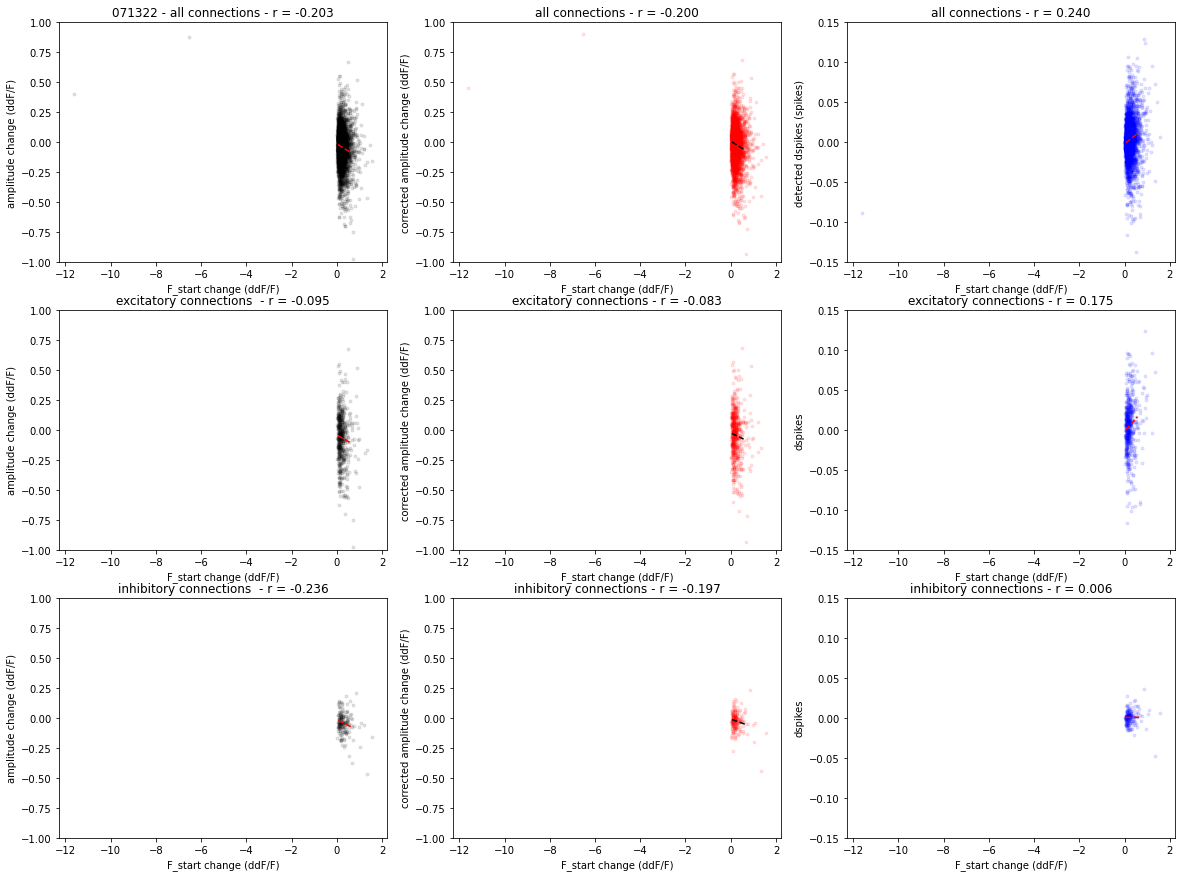

In [25]:
# check how much of the F0 changes explain amplitude changes within a day
f0_list = []
f0_list_raw_inh = []
f0_list_raw_exc = []
f0_list_corr_inh = []
f0_list_corr_exc = []
df_list = []
df_list_exc = []
df_list_inh = []
df_corr_list = []
df_corr_list_exc = []
df_corr_list_inh = []
dspikes_list = []
dspikes_list_exc = []
dspikes_list_inh = []
percentiles_list = []
percentiles_corr_list = []

min_dist = 0
max_dist = 120
pval = .05
distances_real   = np.asarray(distances_matrix).T.flatten()
session = sessions[0]
to_show = 'mean_df'
percentiles_list.append(np.asarray(photostim_data_dict[session]['percentile']).flatten())
percentiles_corr_list.append(np.asarray(photostim_data_dict[session]['percentile_corr']).flatten())

needed_all = (distances_real<=max_dist)&(distances_real>=min_dist)
needed_raw_inh = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmin(percentiles_list,0)<pval)
needed_raw_exc = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmax(percentiles_list,0)>1-pval)
needed_corr_inh = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmin(percentiles_corr_list,0)<pval)
needed_corr_exc = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmax(percentiles_corr_list,0)>1-pval)    
for part in ['_1st_half','_2nd_half']:
    
    baseline_text = 'mean_f_start'#'mean_spikes_start'#'mean_f_start'
    
    f0_list.append(np.concatenate((photostim_data_dict[session][baseline_text+part]))[needed_all])
    f0_list_raw_inh.append(np.concatenate((photostim_data_dict[session][baseline_text+part]))[needed_raw_inh])
    f0_list_raw_exc.append(np.concatenate((photostim_data_dict[session][baseline_text+part]))[needed_raw_exc])
    f0_list_corr_inh.append(np.concatenate((photostim_data_dict[session][baseline_text+part]))[needed_corr_inh])
    f0_list_corr_exc.append(np.concatenate((photostim_data_dict[session][baseline_text+part]))[needed_corr_exc])
    
    
    df_list.append(np.asarray(photostim_data_dict[session][to_show+part]).flatten()[needed_all])
    df_list_exc.append(np.asarray(photostim_data_dict[session][to_show+part]).flatten()[needed_raw_exc])
    df_list_inh.append(np.asarray(photostim_data_dict[session][to_show+part]).flatten()[needed_raw_inh])
    
    df_corr_list.append(np.asarray(photostim_data_dict[session][to_show+'_corr'+part]).flatten()[needed_all])
    df_corr_list_exc.append(np.asarray(photostim_data_dict[session][to_show+'_corr'+part]).flatten()[needed_corr_exc])
    df_corr_list_inh.append(np.asarray(photostim_data_dict[session][to_show+'_corr'+part]).flatten()[needed_corr_inh])
    
    dspikes_list.append((np.asarray(photostim_data_dict[session]['mean_dspikes'+part])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis]).flatten()[needed_all])
    dspikes_list_exc.append((np.asarray(photostim_data_dict[session]['mean_dspikes'+part])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis]).flatten()[needed_corr_exc])
    dspikes_list_inh.append((np.asarray(photostim_data_dict[session]['mean_dspikes'+part])/np.asarray(photostim_data_dict[session]['fitted_f0'])[:,np.newaxis]).flatten()[needed_corr_inh])
    
df0 = np.diff(np.asarray(f0_list),axis = 0).flatten()

df0_raw_inh = np.diff(np.asarray(f0_list_raw_inh),axis = 0).flatten()
df0_raw_exc = np.diff(np.asarray(f0_list_raw_exc),axis = 0).flatten()
df0_corr_inh = np.diff(np.asarray(f0_list_corr_inh),axis = 0).flatten()
df0_corr_exc = np.diff(np.asarray(f0_list_corr_exc),axis = 0).flatten()

ddf = np.diff(np.asarray(df_list),axis = 0).flatten()
ddf_inh = np.diff(np.asarray(df_list_inh),axis = 0).flatten()
ddf_exc = np.diff(np.asarray(df_list_exc),axis = 0).flatten()

ddf_corr = np.diff(np.asarray(df_corr_list),axis = 0).flatten()
ddf_corr_exc = np.diff(np.asarray(df_corr_list_exc),axis = 0).flatten()
ddf_corr_inh = np.diff(np.asarray(df_corr_list_inh),axis = 0).flatten()

ddspikes = np.diff(np.asarray(dspikes_list),axis = 0).flatten()
ddspikes_exc = np.diff(np.asarray(dspikes_list_exc),axis = 0).flatten()
ddspikes_inh = np.diff(np.asarray(dspikes_list_inh),axis = 0).flatten()

fig = plt.figure(figsize = [20,15])


ax1 = fig.add_subplot(3,3,1)
ax1.plot(df0,ddf,'k.',alpha = .1)
x = df0
y = ddf
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax1.plot(xx,yy,'r--')
ax1.set_title('{} - all connections - r = {:.3f}'.format(session, r[0][1]))
ax1.set_xlabel('F_start change (ddF/F)')
ax1.set_ylabel('amplitude change (ddF/F)')


ax2 = fig.add_subplot(3,3,2,sharex = ax1,sharey = ax1)
plt.plot(df0,ddf_corr,'r.',alpha = .1)

x = df0
y = ddf_corr
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax2.plot(xx,yy,'k--')
ax2.set_title('all connections - r = {:.3f}'.format(r[0][1]))
ax2.set_xlabel('F_start change (ddF/F)')
ax2.set_ylabel('corrected amplitude change (ddF/F)')


ax2_spikes = fig.add_subplot(3,3,3,sharex = ax1)
ax2_spikes.plot(df0,ddspikes,'b.',alpha = .1)
x = df0
y = ddspikes
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax2_spikes.plot(xx,yy,'r--')
ax2_spikes.set_title('all connections - r = {:.3f}'.format(r[0][1]))
ax2_spikes.set_xlabel('F_start change (ddF/F)')
ax2_spikes.set_ylabel('detected dspikes (spikes)')




ax3 = fig.add_subplot(3,3,4,sharex = ax1,sharey = ax2)
ax3.plot(df0_raw_exc,ddf_exc,'k.',alpha = .1)
x = df0_raw_exc
y = ddf_exc
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax3.plot(xx,yy,'r--')
ax3.set_title('excitatory connections  - r = {:.3f}'.format(r[0][1]))
ax3.set_xlabel('F_start change (ddF/F)')
ax3.set_ylabel('amplitude change (ddF/F)')



ax4 = fig.add_subplot(3,3,5,sharex = ax1,sharey = ax2)
plt.plot(df0_corr_exc,ddf_corr_exc,'r.',alpha = .1)
x = df0_corr_exc
y = ddf_corr_exc
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax4.plot(xx,yy,'k--')
ax4.set_title('excitatory connections - r = {:.3f}'.format(r[0][1]))
ax4.set_xlabel('F_start change (ddF/F)')
ax4.set_ylabel('corrected amplitude change (ddF/F)')

ax4_spikes = fig.add_subplot(3,3,6,sharex = ax1,sharey = ax2_spikes)
ax4_spikes.plot(df0_corr_exc,ddspikes_exc,'b.',alpha = .1)
x = df0_corr_exc
y = ddspikes_exc
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax4_spikes.plot(xx,yy,'r--')
ax4_spikes.set_title('excitatory connections - r = {:.3f}'.format(r[0][1]))
ax4_spikes.set_xlabel('F_start change (ddF/F)')
ax4_spikes.set_ylabel('dspikes')


ax5 = fig.add_subplot(3,3,7,sharex = ax1,sharey = ax2)
ax5.plot(df0_raw_inh,ddf_inh,'k.',alpha = .1)
x = df0_raw_inh
y = ddf_inh
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax5.plot(xx,yy,'r--')
ax5.set_title('inhibitory connections  - r = {:.3f}'.format(r[0][1]))
ax5.set_xlabel('F_start change (ddF/F)')
ax5.set_ylabel('amplitude change (ddF/F)')



ax6 = fig.add_subplot(3,3,8,sharex = ax1,sharey = ax2)
plt.plot(df0_corr_inh,ddf_corr_inh,'r.',alpha = .1)
x = df0_corr_inh
y = ddf_corr_inh
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax6.plot(xx,yy,'k--')
ax6.set_title('inhibitory connections - r = {:.3f}'.format(r[0][1]))
ax6.set_xlabel('F_start change (ddF/F)')
ax6.set_ylabel('corrected amplitude change (ddF/F)')
ax6.set_ylim([-1, 1])


ax6_spikes = fig.add_subplot(3,3,9,sharex = ax1,sharey = ax2_spikes)
ax6_spikes.plot(df0_corr_inh,ddspikes_inh,'b.',alpha = .1)
x = df0_corr_inh
y = ddspikes_inh
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax6_spikes.plot(xx,yy,'r--')
ax6_spikes.set_title('inhibitory connections - r = {:.3f}'.format(r[0][1]))
ax6_spikes.set_xlabel('F_start change (ddF/F)')
ax6_spikes.set_ylabel('dspikes')
ax6_spikes.set_ylim([-.15, .15])

(-1.0, 1.0)

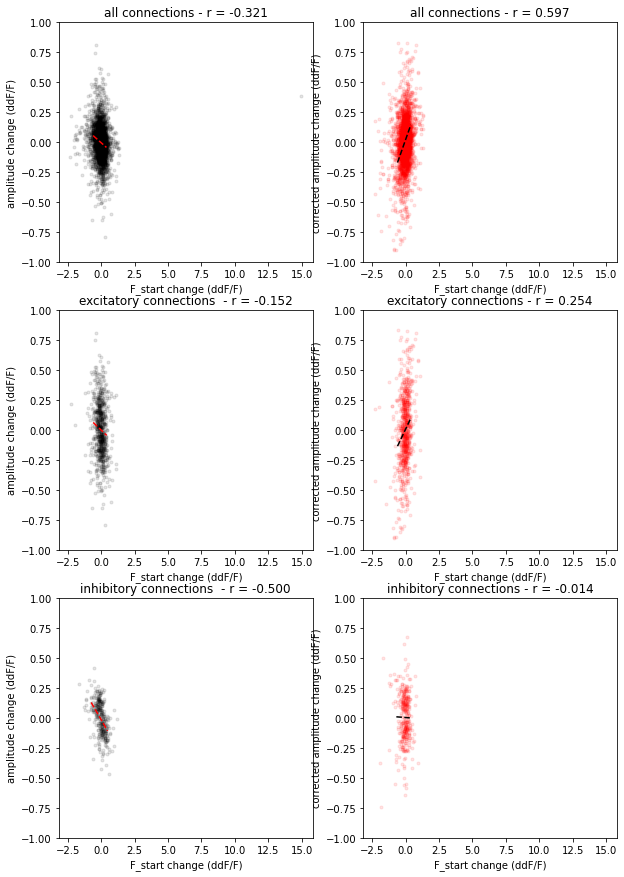

In [26]:
# check how much of the F0 changes explain amplitude changes between days
f0_list = []
f0_list_raw_inh = []
f0_list_raw_exc = []
f0_list_corr_inh = []
f0_list_corr_exc = []
df_list = []
df_list_exc = []
df_list_inh = []
df_corr_list = []
df_corr_list_exc = []
df_corr_list_inh = []
percentiles_list = []
percentiles_corr_list = []

min_dist = 0
max_dist = 120
pval = .05
match_f0_across_sessions = False
distances_real   = np.asarray(distances_matrix).T.flatten()
for session in sessions:
    percentiles_list.append(np.asarray(photostim_data_dict[session]['percentile']).flatten())
    percentiles_corr_list.append(np.asarray(photostim_data_dict[session]['percentile_corr']).flatten())
needed_all = (distances_real<=max_dist)&(distances_real>=min_dist)
needed_raw_inh = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmin(percentiles_list,0)<pval)
needed_raw_exc = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmax(percentiles_list,0)>1-pval)
needed_corr_inh = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmin(percentiles_corr_list,0)<pval)
needed_corr_exc = (distances_real<max_dist) &(distances_real>min_dist) & (np.nanmax(percentiles_corr_list,0)>1-pval)    
for session in sessions:
    if match_f0_across_sessions:
        txt = 'mean_f_start_matched'
    else:
        txt = 'mean_f_start'
        #txt = 'mean_spikes_start'
    f0_list.append(np.concatenate((photostim_data_dict[session][txt]))[needed_all])
    f0_list_raw_inh.append(np.concatenate((photostim_data_dict[session][txt]))[needed_raw_inh])
    f0_list_raw_exc.append(np.concatenate((photostim_data_dict[session][txt]))[needed_raw_exc])
    f0_list_corr_inh.append(np.concatenate((photostim_data_dict[session][txt]))[needed_corr_inh])
    f0_list_corr_exc.append(np.concatenate((photostim_data_dict[session][txt]))[needed_corr_exc])
    
    if match_f0_across_sessions:
        txt = 'mean_df_matched'
    else:
        txt = 'mean_df'
    
    df_list.append(np.asarray(photostim_data_dict[session][txt]).flatten()[needed_all])
    df_list_exc.append(np.asarray(photostim_data_dict[session][txt]).flatten()[needed_raw_exc])
    df_list_inh.append(np.asarray(photostim_data_dict[session][txt]).flatten()[needed_raw_inh])
    
    df_corr_list.append(np.asarray(photostim_data_dict[session][txt+'_corr']).flatten()[needed_all])
    df_corr_list_exc.append(np.asarray(photostim_data_dict[session][txt+'_corr']).flatten()[needed_corr_exc])
    df_corr_list_inh.append(np.asarray(photostim_data_dict[session][txt+'_corr']).flatten()[needed_corr_inh])
    
df0 = np.diff(np.asarray(f0_list),axis = 0).flatten()

df0_raw_inh = np.diff(np.asarray(f0_list_raw_inh),axis = 0).flatten()
df0_raw_exc = np.diff(np.asarray(f0_list_raw_exc),axis = 0).flatten()
df0_corr_inh = np.diff(np.asarray(f0_list_corr_inh),axis = 0).flatten()
df0_corr_exc = np.diff(np.asarray(f0_list_corr_exc),axis = 0).flatten()

ddf = np.diff(np.asarray(df_list),axis = 0).flatten()
ddf_inh = np.diff(np.asarray(df_list_inh),axis = 0).flatten()
ddf_exc = np.diff(np.asarray(df_list_exc),axis = 0).flatten()

ddf_corr = np.diff(np.asarray(df_corr_list),axis = 0).flatten()
ddf_corr_exc = np.diff(np.asarray(df_corr_list_exc),axis = 0).flatten()
ddf_corr_inh = np.diff(np.asarray(df_corr_list_inh),axis = 0).flatten()

fig = plt.figure(figsize = [10,15])


ax1 = fig.add_subplot(3,2,1)
ax1.plot(df0,ddf,'k.',alpha = .1)
x = df0
y = ddf
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax1.plot(xx,yy,'r--')
ax1.set_title('all connections - r = {:.3f}'.format(r[0][1]))
ax1.set_xlabel('F_start change (ddF/F)')
ax1.set_ylabel('amplitude change (ddF/F)')


ax2 = fig.add_subplot(3,2,2,sharex = ax1,sharey = ax1)
plt.plot(df0,ddf_corr,'r.',alpha = .1)

x = df0
y = ddf_corr
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax2.plot(xx,yy,'k--')
ax2.set_title('all connections - r = {:.3f}'.format(r[0][1]))
ax2.set_xlabel('F_start change (ddF/F)')
ax2.set_ylabel('corrected amplitude change (ddF/F)')



ax3 = fig.add_subplot(3,2,3,sharex = ax1,sharey = ax2)
ax3.plot(df0_raw_exc,ddf_exc,'k.',alpha = .1)
x = df0_raw_exc
y = ddf_exc
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax3.plot(xx,yy,'r--')
ax3.set_title('excitatory connections  - r = {:.3f}'.format(r[0][1]))
ax3.set_xlabel('F_start change (ddF/F)')
ax3.set_ylabel('amplitude change (ddF/F)')



ax4 = fig.add_subplot(3,2,4,sharex = ax1,sharey = ax2)
plt.plot(df0_corr_exc,ddf_corr_exc,'r.',alpha = .1)
x = df0_corr_exc
y = ddf_corr_exc
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax4.plot(xx,yy,'k--')
ax4.set_title('excitatory connections - r = {:.3f}'.format(r[0][1]))
ax4.set_xlabel('F_start change (ddF/F)')
ax4.set_ylabel('corrected amplitude change (ddF/F)')




ax5 = fig.add_subplot(3,2,5,sharex = ax1,sharey = ax2)
ax5.plot(df0_raw_inh,ddf_inh,'k.',alpha = .1)
x = df0_raw_inh
y = ddf_inh
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax5.plot(xx,yy,'r--')
ax5.set_title('inhibitory connections  - r = {:.3f}'.format(r[0][1]))
ax5.set_xlabel('F_start change (ddF/F)')
ax5.set_ylabel('amplitude change (ddF/F)')



ax6 = fig.add_subplot(3,2,6,sharex = ax1,sharey = ax2)
plt.plot(df0_corr_inh,ddf_corr_inh,'r.',alpha = .1)
x = df0_corr_inh
y = ddf_corr_inh
needed = (np.isnan(x)==False) & (np.isnan(y)==False)
x = x[needed]
y = y[needed]
r = np.corrcoef(x,y)
p = np.polyfit(x,y,1)
xx = np.percentile(x,[5,95])
yy = np.polyval(p,xx)
ax6.plot(xx,yy,'k--')
ax6.set_title('inhibitory connections - r = {:.3f}'.format(r[0][1]))
ax6.set_xlabel('F_start change (ddF/F)')
ax6.set_ylabel('corrected amplitude change (ddF/F)')
ax6.set_ylim([-1,1])

-0.019373080245346674

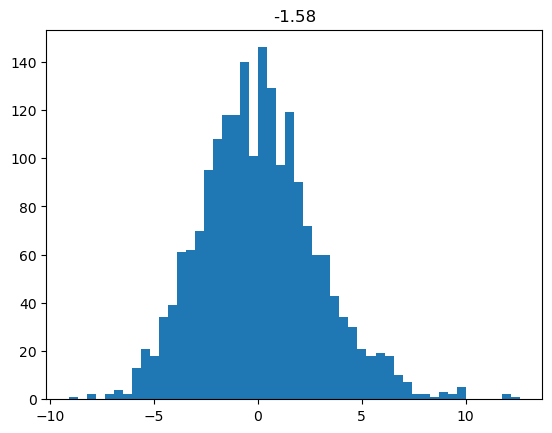

In [48]:
cell_idx =22
population = np.concatenate(photostim_data_dict[session]['shuffled_mean_amplitudes_corrected'][cell_idx])
modeval = scipy.stats.mode(np.round(population,2))
plt.hist(population,50)
plt.title(modeval.mode[0])
np.median(population)

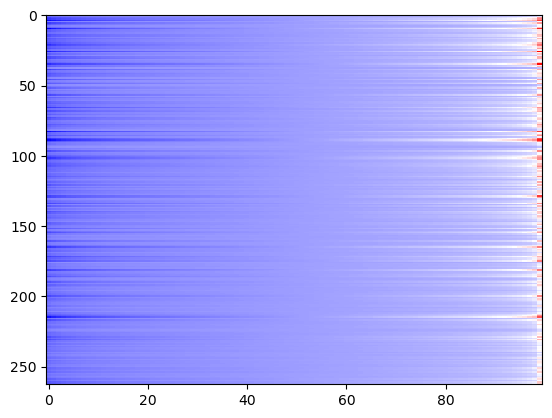

In [49]:

im = plt.imshow(np.asarray(photostim_data_dict[session]['cell_percentile_amplitudes_corrected_ALL']),aspect = 'auto',interpolation='none')
#im.set_clim([-5, 5])

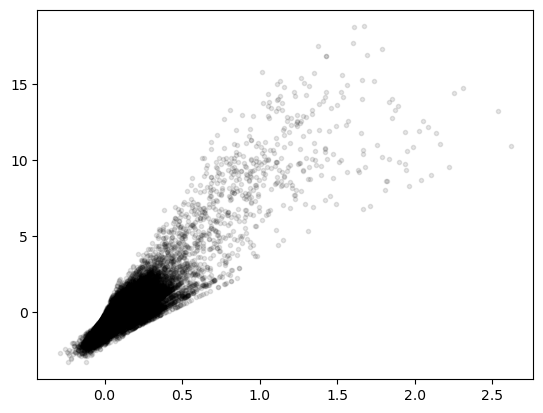

In [299]:
plt.plot(np.asarray(photostim_data_dict[session]['mean_df_corr']).flatten(),np.asarray(photostim_data_dict[session]['mean_impact_corr']).flatten(),'k.',alpha = .1)

Text(0.5, 1.0, '(-1.6621724021461182, 1.2504112013477557)')

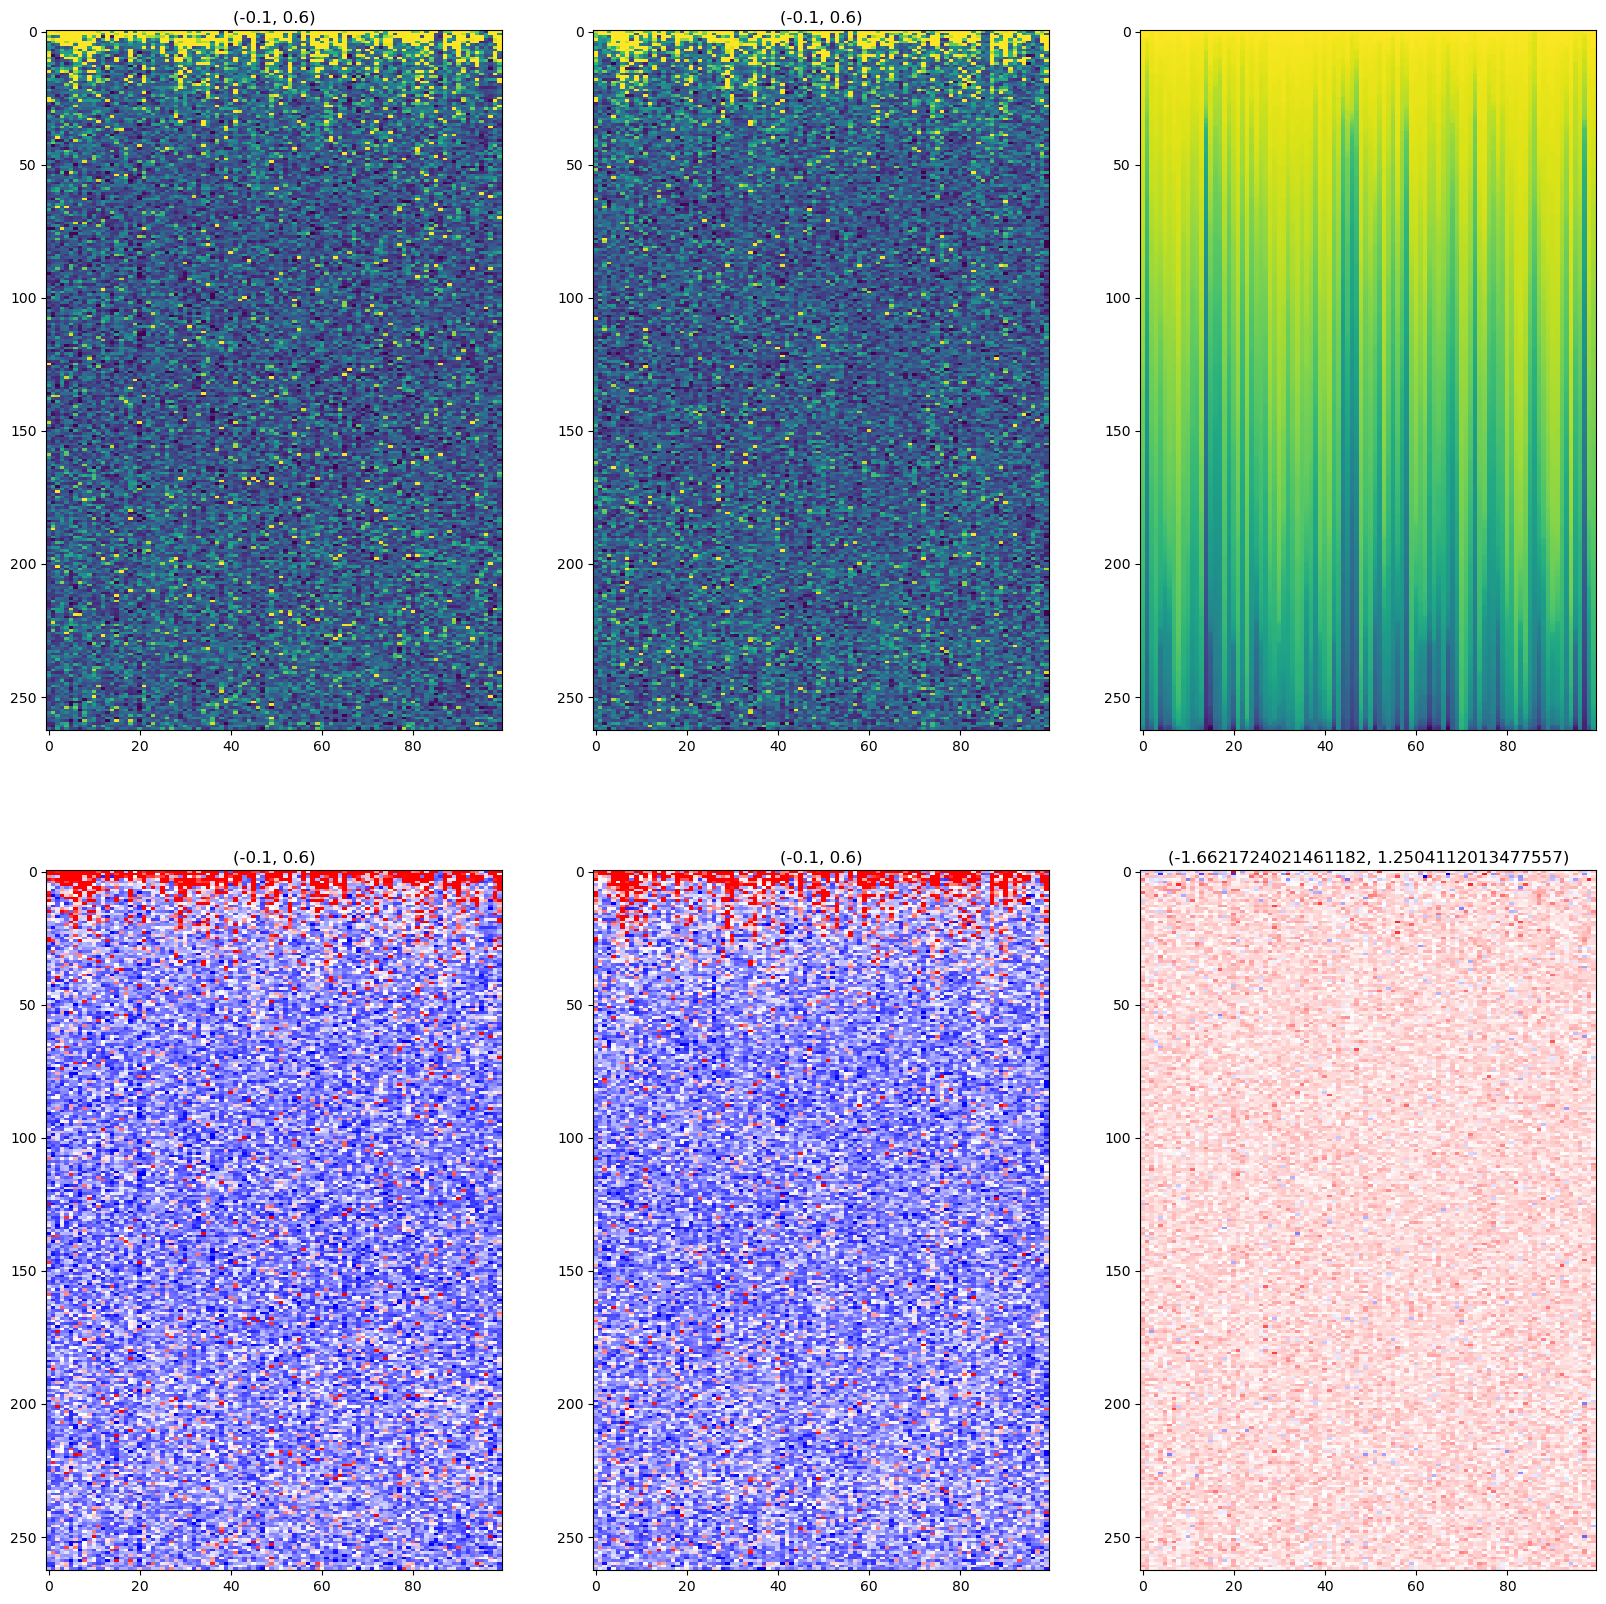

In [476]:
distance_offset = 1000
reorder_by_distance = True
value_to_plot = 'mean_df_corr'#'mean_df_bootstrapped_corr'#'mean_df_corr'#'mean_df'#'mean_impact'#'percentile_corr'#mean_impact_corr
dist_matrix = np.asarray(distances_matrix).copy()
dist_matrix[dist_matrix>distance_offset] = distance_offset
dist_matrix = distance_offset-dist_matrix
fig = plt.figure(figsize = [20,20])
dist_matrix_list = []
limits = [-.1,.6]
for i,session in enumerate(sessions):
    plt.set_cmap('viridis')
    ax = fig.add_subplot(2,3,1+i)
    if reorder_by_distance:
        matrix_to_plot = np.asarray(photostim_data_dict[session][value_to_plot])
        for group_i,group_dists in enumerate(np.asarray(distances_matrix)):
            order = np.argsort(group_dists)
            matrix_to_plot[:,group_i]=matrix_to_plot[order,group_i]

    else:
        matrix_to_plot = np.asarray(photostim_data_dict[session][value_to_plot])
    im = ax.imshow(matrix_to_plot,aspect = 'auto',interpolation='none')
    im.set_clim(limits)
    ax.set_title(im.get_clim())
    ax = fig.add_subplot(2,3,4+i)
    conns = np.asarray(photostim_data_dict[session][value_to_plot]).copy()
    conns[dist_matrix.T == 0 ] = np.nan
    if reorder_by_distance:
        matrix_to_plot = conns
        for group_i,group_dists in enumerate(np.asarray(distances_matrix)):
            order = np.argsort(group_dists)
            matrix_to_plot[:,group_i]=matrix_to_plot[order,group_i]
        conns = matrix_to_plot
    plt.set_cmap('bwr')
    im = ax.imshow(conns,aspect = 'auto',interpolation='none')
    im.set_clim(limits)
    dist_matrix_list.append(conns)
    ax.set_title(im.get_clim())
    
plt.set_cmap('viridis')  
ax_dist = fig.add_subplot(2,3,3)
if reorder_by_distance:
    matrix_to_plot = dist_matrix.T
    for group_i,group_dists in enumerate(np.asarray(distances_matrix)):
        order = np.argsort(group_dists)
        matrix_to_plot[:,group_i]=matrix_to_plot[order,group_i]
    conns = matrix_to_plot
ax_dist.imshow(matrix_to_plot,aspect = 'auto',interpolation='none')
plt.set_cmap('bwr')
ax_difi = fig.add_subplot(2,3,6)
dif_matrix = dist_matrix_list[1]-dist_matrix_list[0]
#dif_matrix[dist_matrix.T == 0 ] = np.nan
im = ax_difi.imshow(dif_matrix,aspect = 'auto',interpolation='none')
#im.set_clim([-1,1])
ax_difi.set_title(im.get_clim())

In [ ]:
min_dfs = []
for session in sessions:
    min_dfs.append(np.concatenate((photostim_data_dict[session]['mean_min_df_corr'])))
plt.plot()

In [61]:
sum(needed)

599

In [46]:
photostim_data_dict[session].keys()

dict_keys(['F0', 'fitted_f0', 'fitted_tau', 'cell_indices', 'F_start', 'dF', 'dF_vs_f0_corrcoef', 'dF_corr', 'min_dF', 'min_dF_corr', 'dF_corr_vs_f0_corrcoef', 'percentile', 'percentile_corr', 'cell_percentile_amplitudes_corrected_ALL', 'cell_percentile_amplitudes_ALL', 'cell_percentile_values', 'shuffled_mean_f0s', 'shuffled_mean_amplitudes', 'shuffled_mean_amplitudes_corrected', 'regression_coefficients', 'mean_df', 'mean_min_df', 'mean_min_df_corr', 'mean_impact', 'mean_df_1st_half', 'mean_df_2nd_half', 'mean_impact_1st_half', 'mean_impact_2nd_half', 'mean_df_corr', 'mean_impact_corr', 'mean_df_corr_1st_half', 'mean_df_corr_2nd_half', 'mean_impact_corr_1st_half', 'mean_impact_corr_2nd_half', 'mean_f_start'])

In [67]:
df_corr_list = []
f0_list = []
fmin_corr_list = []
df_list = []
fmin_list = []
for session in sessions:
    df_corr_list.append(np.concatenate(photostim_data_dict[session]['mean_df_corr']))
    df_list.append(np.concatenate(photostim_data_dict[session]['mean_df']))
    f0_list.append(np.concatenate(photostim_data_dict[session]['mean_f_start']))
    fmin_list.append(np.concatenate(photostim_data_dict[session]['mean_min_df']))
    fmin_corr_list.append(np.concatenate(photostim_data_dict[session]['mean_min_df_corr']))
#plt.plot(df_corr_list[0],df_corr_list[0]-df_corr_list[1],'k.',alpha = .1)
#plt.hist(df_corr_list[0]-df_corr_list[1],100)
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(2,2,1)
ax1.plot(fmin_list[0],df_list[0],'k.',alpha = .1)
ax1.plot(fmin_corr_list[0],df_corr_list[0],'r.',alpha = .1)
ax1.set_xlabel('achivable minimum amplitude')
ax1.set_ylabel('average amplitude')
ax1.set_title(sessions[0])

ax2 = fig.add_subplot(2,2,2,sharex = ax1, sharey = ax1)
ax2.plot(fmin_list[1],df_list[1],'k.',alpha = .1)
ax2.plot(fmin_corr_list[1],df_corr_list[1],'r.',alpha = .1)
ax2.set_xlabel('achivable minimum amplitude')
ax2.set_ylabel('average amplitude')
ax2.set_title(sessions[1])
# plt.xlim([-.5,0])
# plt.ylim([-.5,.5])

ax3 = fig.add_subplot(2,2,3)
ax3.plot(df_list[0]-fmin_list[0],df_list[1]-fmin_list[1],'k.',alpha = .1)
ax3.plot(df_corr_list[0]-fmin_corr_list[0],df_corr_list[1]-fmin_corr_list[1],'r.',alpha = .1)
ax3.set_xlabel('distance from fmin {}'.format(sessions[0]))
ax3.set_ylabel('distance from fmin {}'.format(sessions[1]))
ax4 = fig.add_subplot(2,2,4)
ax4.plot(df_list[0]-fmin_list[0],df_list[0],'k.',alpha = .1)
ax4.plot(df_corr_list[0]-fmin_corr_list[0],df_corr_list[0],'r.',alpha = .1)
#ax4.plot()

KeyError: 'mean_min_df'

(array([90.,  2.,  4.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.]),
 array([0.     , 0.01998, 0.03996, 0.05994, 0.07992, 0.0999 , 0.11988,
        0.13986, 0.15984, 0.17982, 0.1998 , 0.21978, 0.23976, 0.25974,
        0.27972, 0.2997 , 0.31968, 0.33966, 0.35964, 0.37962, 0.3996 ,
        0.41958, 0.43956, 0.45954, 0.47952, 0.4995 , 0.51948, 0.53946,
        0.55944, 0.57942, 0.5994 , 0.61938, 0.63936, 0.65934, 0.67932,
        0.6993 , 0.71928, 0.73926, 0.75924, 0.77922, 0.7992 , 0.81918,
        0.83916, 0.85914, 0.87912, 0.8991 , 0.91908, 0.93906, 0.95904,
        0.97902, 0.999  ]),
 <BarContainer object of 50 artists>)

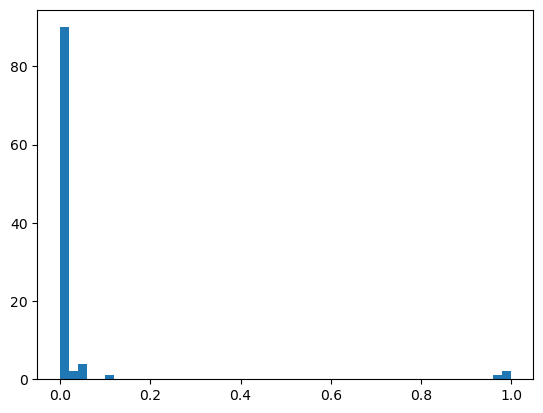

In [176]:
plt.hist(photostim_data_dict[session][value_to_plot][4],50)

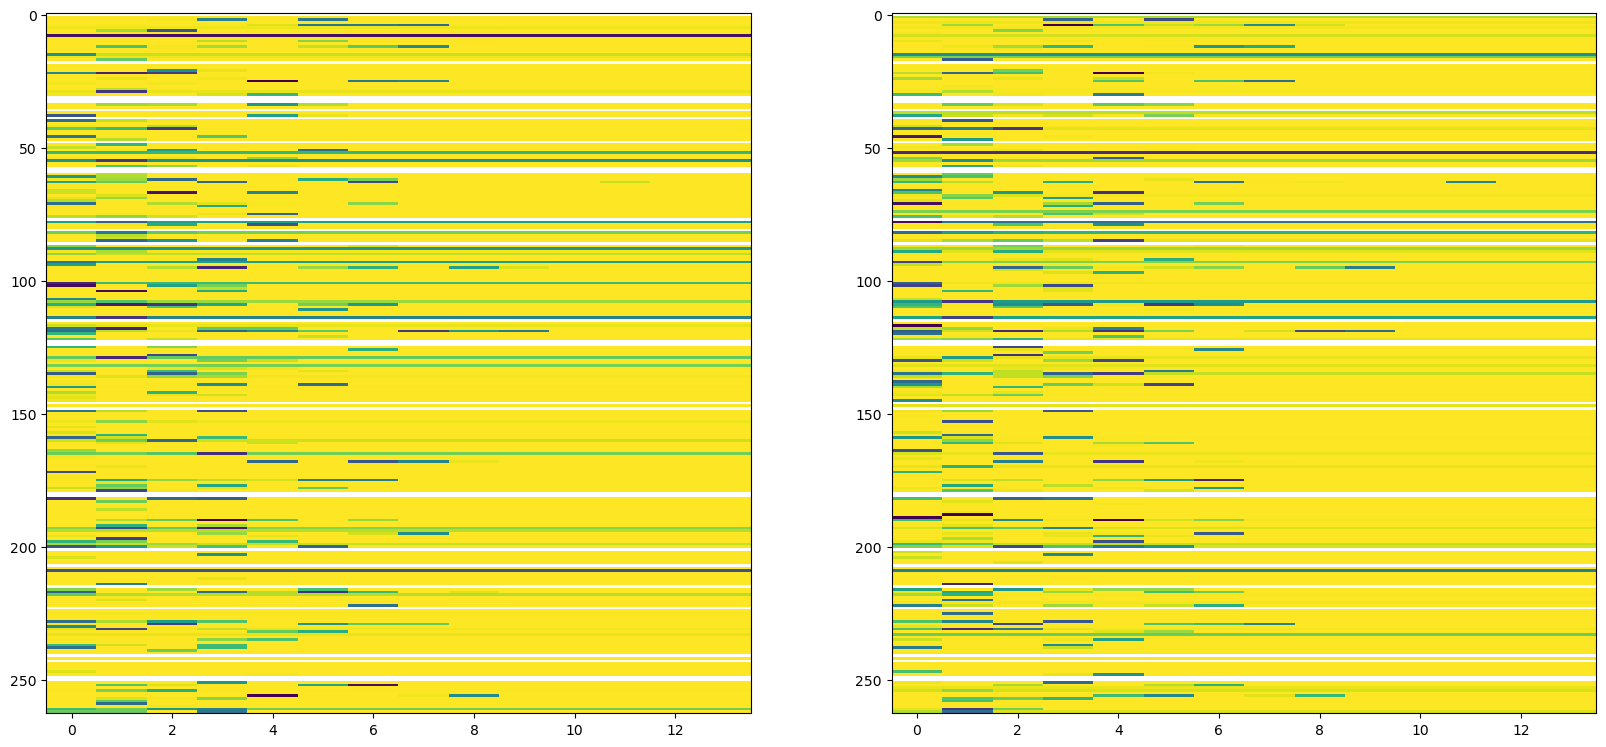

In [43]:
# collect all the direct photostim groups for each cell and look at the responses - is there a non-stimulatable cell?
distance_offset = 20
dist_matrix = np.asarray(distances_matrix).copy()
dist_matrix[dist_matrix>distance_offset] = distance_offset
dist_matrix = distance_offset-dist_matrix

fig = plt.figure(figsize = [20,20])
for i,session in enumerate(sessions):
    conns = np.asarray(photostim_data_dict[session]['percentile_corr']).T.copy()
    conns[dist_matrix == 0 ] = np.nan
    probs_per_cell = []
    non_nan_num = []
    for c in conns.T:
        non_nans = np.isnan(c)== False
        probs_per_cell.append(c[non_nans])
        non_nan_num.append(sum(non_nans))
    colnum = np.max(non_nan_num)+1
    stim_matrix = np.zeros([colnum,len(probs_per_cell)])*np.nan
    
    
    
    ax = fig.add_subplot(2,2,1+i)
    plt.set_cmap('viridis')
    for i,p in enumerate(probs_per_cell):
        stim_matrix[:len(p),i] = p
        try:
            stim_matrix[len(p):,i] = np.nanmax(p)
        except:
            pass
    
    
    
    
    im = ax.imshow(stim_matrix.T,aspect = 'auto',interpolation='none')
    im.set_clim([0,1])
   # adsa
    

In [39]:
x

array([ 36.5,  96. , 118. , 102.5,  71. ,  39. ,  30.5,  20. ,   7. ])

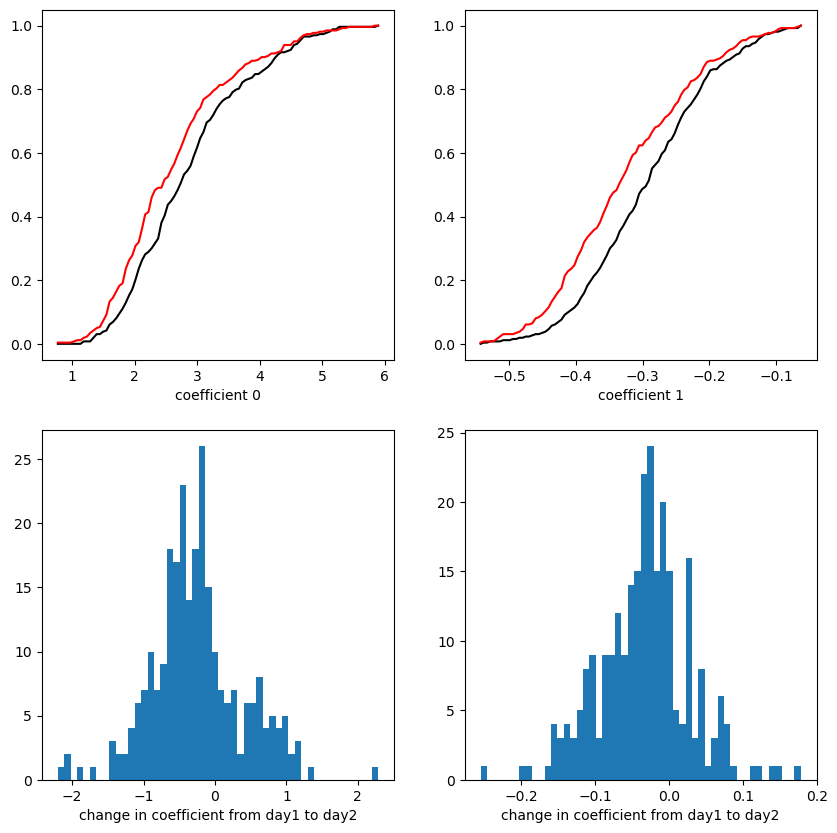

In [49]:
# how similar are the coefficients for regressions from day to day?
coefs_list = []
for session_i,session in enumerate(sessions):
    coefs_list.append(np.asarray(photostim_data_dict[session]['regression_coefficients']))
    
coefs_list = np.asarray(coefs_list).squeeze()
fig = plt.figure(figsize = [10,10])
for coef_i in range(coefs_list.shape[2]):
    ax_hist = fig.add_subplot(coefs_list.shape[2],2,coef_i+1)
    y,x_ = np.histogram(coefs_list[:,:,coef_i].flatten(),100)
    x = np.mean([x_[:-1],x_[1:]],0)
    y1,x_ = np.histogram(coefs_list[0,:,coef_i].flatten(),x_)
    y2,x_ = np.histogram(coefs_list[1,:,coef_i].flatten(),x_)
    pdf_y1 = np.cumsum(y1)/np.sum(y1)
    pdf_y2 = np.cumsum(y2)/np.sum(y2)
    ax_hist.plot(x,pdf_y1,'k-')
    ax_hist.plot(x,pdf_y2,'r-')
    ax_hist.set_xlabel('coefficient {}'.format(coef_i))
    
    ax_compare = fig.add_subplot(coefs_list.shape[2],2,coef_i+1+coefs_list.shape[2])
    ax_compare.hist(coefs_list[1,:,coef_i]-coefs_list[0,:,coef_i],50)
    ax_compare.set_xlabel('change in coefficient from day1 to day2')
#plt.hist(coefs_list[0,:,0])

/tmp/ipykernel_19131/2177812300.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ax_f0_diff.hist(np.asarray(f0_list[1])/np.asarray(f0_list[0]),np.arange(0,2,.05))
/tmp/ipykernel_19131/2177812300.py:23: RuntimeWarning: divide by zero encountered in true_divide
  ax_df0_dtau.plot(np.asarray(f0_list[1])/np.asarray(f0_list[0]),np.asarray(tau_list[1])/np.asarray(tau_list[0]),'k.')


ValueError: x and y must have same first dimension, but have shapes (7948,) and (263,)

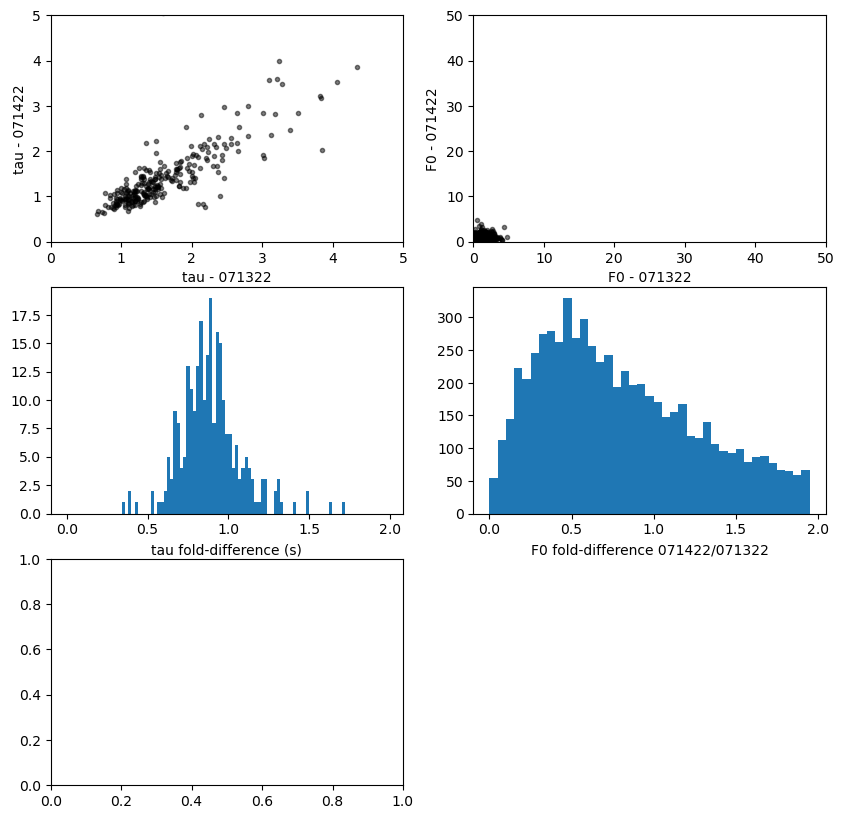

In [414]:
fig = plt.figure(figsize = [10,10])
ax_tau = fig.add_subplot(3,2,1)
ax_tau.plot(tau_list[0],tau_list[1],'k.',alpha = .5)
ax_tau.set_xlabel('tau - {}'.format(sessions_to_compare[0]))
ax_tau.set_ylabel('tau - {}'.format(sessions_to_compare[1]))
ax_tau.set_xlim([0,5])
ax_tau.set_ylim([0,5])
ax_tau_diff = fig.add_subplot(3,2,3)
ax_tau_diff.hist(np.asarray(tau_list[1])/np.asarray(tau_list[0]),np.arange(0,2,.02))
ax_tau_diff.set_xlabel('tau fold-difference (s)')

ax_f0 = fig.add_subplot(3,2,2)
ax_f0.plot(f0_list[0],f0_list[1],'k.',alpha = .5)
ax_f0.set_xlabel('F0 - {}'.format(sessions_to_compare[0]))
ax_f0.set_ylabel('F0 - {}'.format(sessions_to_compare[1]))
ax_f0.set_xlim([0,50])
ax_f0.set_ylim([0,50])
ax_f0_diff = fig.add_subplot(3,2,4)
ax_f0_diff.hist(np.asarray(f0_list[1])/np.asarray(f0_list[0]),np.arange(0,2,.05))
ax_f0_diff.set_xlabel('F0 fold-difference {}/{}'.format(sessions_to_compare[1],sessions_to_compare[0]))

ax_df0_dtau = fig.add_subplot(3,2,5)
ax_df0_dtau.plot(np.asarray(f0_list[1])/np.asarray(f0_list[0]),np.asarray(tau_list[1])/np.asarray(tau_list[0]),'k.')

In [48]:
np.argsort(np.asarray(tau_list[1])/np.asarray(tau_list[0]))

array([ 81, 104, 228,   1,  13, 177,  58,   8, 124,  29, 255, 151, 113,
       259,  65, 125,  52,  56, 223, 157, 240, 201, 193,  70, 120, 234,
        24,  38, 176, 224, 167,  64, 192, 221, 214, 100, 109, 159,  27,
       260,  79,   6, 129, 250,  78,  97,  77,  60,  46, 232,  90,  73,
       107, 230,  83, 246, 220, 171, 153, 154, 242,  39, 233, 245,  53,
       205, 150,  36, 249, 211, 168, 130,  85, 215,  63, 226, 101,  34,
        25, 110,  67, 225, 200, 102,  95, 121, 219, 117, 213,  19,  57,
        10, 222,  26,  96,  33, 243, 126, 118, 256,  72, 146,  62, 149,
       165, 181,  15, 128, 158, 235, 170,  71,  93, 160, 199,  76, 182,
        92, 212,  18, 185,  30, 156, 241, 142,  28,  35,  69, 139, 137,
       132, 229, 196, 227, 162, 253,  42, 191, 217,  40, 188,  94, 236,
        11, 179,  55,  87, 148, 206,  16,   9, 106,  12, 173,  54, 147,
       108, 194,  37, 138,  80, 204, 183, 216,  43, 258,  49, 105, 144,
       143,  91, 141, 114, 254,  31,  48,  61,  98,  88,  22,   

(-2.0, 2.0)

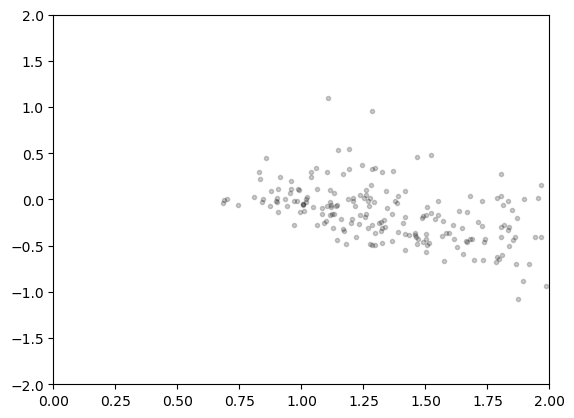

In [48]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.plot(np.asarray(tau_list[0]),np.asarray(tau_list[1])-np.asarray(tau_list[0]),'k.',alpha  = .2)
ax.set_xlim([0,2])
ax.set_ylim([-2,2])
# plt.yscale('log')
# plt.xscale('log')

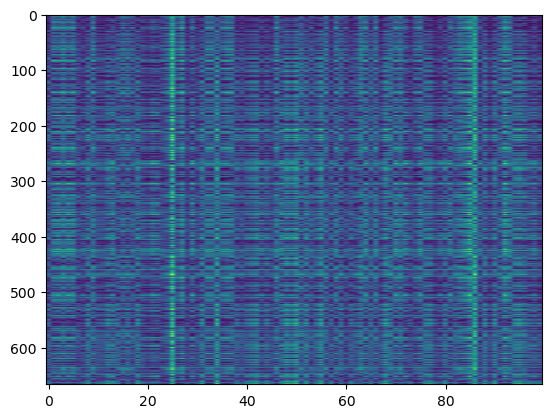

In [807]:
plt.imshow(np.asarray(distances_matrix).T,aspect = 'auto')

(-4.0, 8.0)

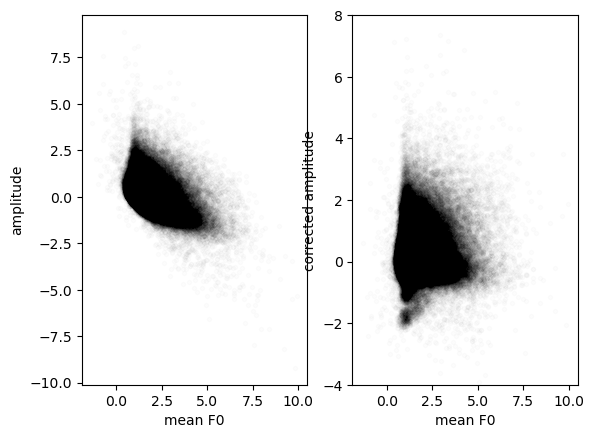

In [774]:
fig = plt.figure()
ax_ampl = fig.add_subplot(1,2,1)
ax_ampl.plot(np.concatenate(group_f0s_ALL),np.concatenate(group_amplitudes_ALL),'k.',alpha = .01)
ax_ampl.set_xlabel('mean F0')
ax_ampl.set_ylabel('amplitude')
ax_ampl_corr = fig.add_subplot(1,2,2)
ax_ampl_corr.plot(np.concatenate(group_f0s_ALL),np.concatenate(corrected_group_amplitudes_ALL),'k.',alpha = .01)
ax_ampl_corr.set_xlabel('mean F0')
ax_ampl_corr.set_ylabel('corrected amplitude')
ax_ampl_corr.set_ylim([-4,8])

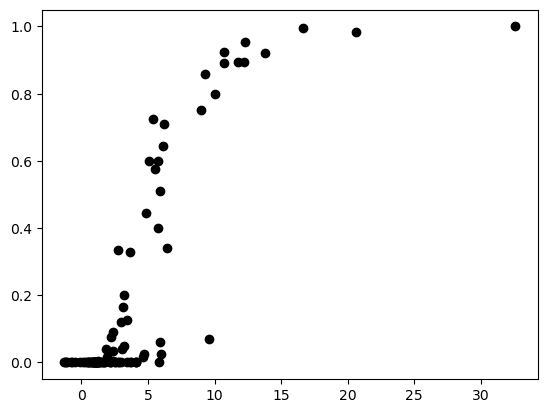

In [676]:

corrected_group_mean_amplitudes = []
for g in corrected_group_amplitudes_all:
    corrected_group_mean_amplitudes.append(np.nanmean(g))
plt.plot(corrected_group_mean_amplitudes,group_percentiles,'ko')

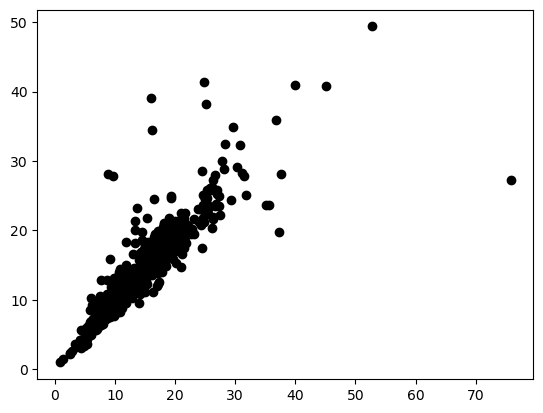

In [599]:
# calculated_taus_session = calculated_taus
# calculated_f0s_session = calculated_f0s
# calculated_taus_photostim = calculated_taus
# calculated_f0s_photostim = calculated_f0s
plt.plot(calculated_f0s_session,calculated_f0s_photostim,'ko')

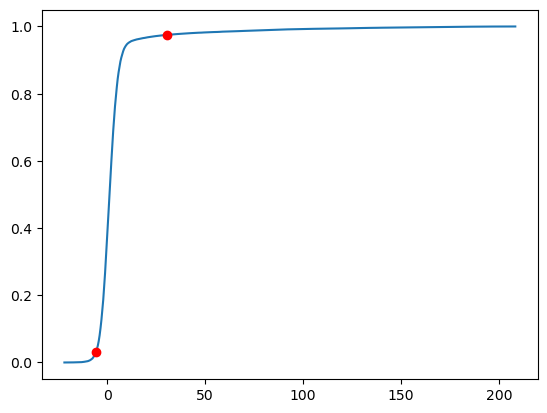

In [629]:
y,x = np.histogram(amplitudes_corrected,500)
x = np.mean([x[:-1],x[1:]],0)
pdf_y = np.cumsum(y)/np.sum(y)
idx_low = np.argmax(pdf_y>.025)
idx_high = np.argmax(pdf_y>.975)
plt.plot(x,pdf_y)
plt.plot(x[idx_low],pdf_y[idx_low],'ro')
plt.plot(x[idx_high],pdf_y[idx_high],'ro')

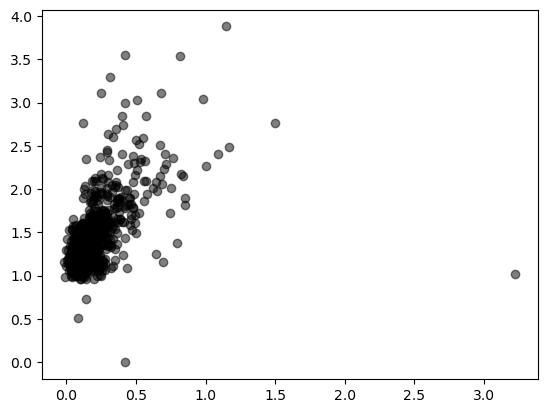

In [548]:
plt.plot(np.mean(dFF_photostim,1),calculated_taus,'ko',alpha = .5)

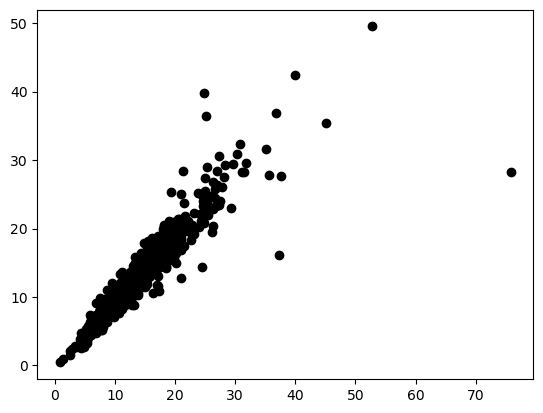

In [572]:
#plt.hist(1/np.asarray(calculated_taus),50)
plt.plot(calculated_f0s,F0_scalar_photostim,'ko')
#plt.plot(np.mean(dFF_photostim,1),-1*np.asarray(calculated_taus),'ko')

array([29,  3, 96, 17, 26, 57, 22,  0, 36, 27, 97, 47, 18, 43, 73, 99, 61,
       51, 62, 16, 76,  4, 11, 58, 52, 50, 24, 55, 87, 95, 83, 74, 77, 84,
       48, 98, 85,  8, 25, 67, 68, 81,  6, 66, 40, 63, 64, 90, 91, 33, 94,
       75, 37, 21, 49, 39, 72, 65, 38, 88, 89, 86, 70, 78, 80, 46, 59, 53,
       92, 71, 44, 28, 56, 41, 31, 54, 60, 20,  9, 12, 45, 13, 69, 79, 30,
        1, 35, 14, 82, 19, 34, 10,  5,  2, 42, 93, 15, 23, 32,  7])

In [122]:
cell_idx

206

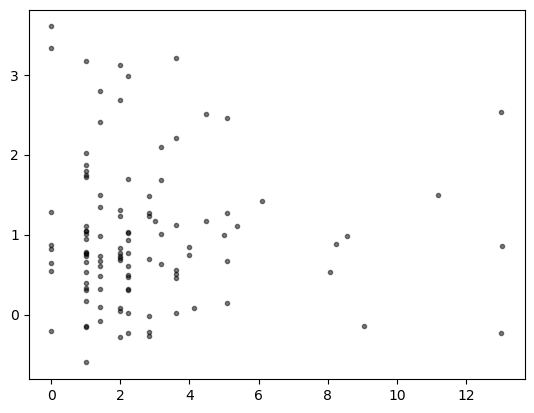

In [133]:
max_distance = 1 #pixels
offsets_list = []
amplitudes_list = []
for group_idx in np.argsort(offset_var)[-1:-20:-1]:
    distances = np.asarray(distances_matrix)[group_idx,:]
    offsets = xy_offset[photostim_indices[np.asarray(photostim_groups['group_order'])==group_idx]]
    cell_indices = distances<max_distance
    for cell_idx in np.where(cell_indices)[0]:
        cell_i = photostim_data_dict[session]['cell_indices'][cell_idx]
        F0 = photostim_data_dict[session]['F0'][cell_i]
        df_corr = photostim_data_dict[session]['dF_corr'][cell_idx][group_idx]
        offsets_list.append(offsets)
        amplitudes_list.append((df_corr/F0))

plt.plot(np.concatenate(offsets_list),np.concatenate(amplitudes_list),'k.',alpha = .5)

In [210]:
# where is the biggest offset??
offset_var = []
for group_idx in range(100):
    offsets = xy_offset[photostim_indices[np.asarray(photostim_groups['group_order'])==group_idx]]
    offset_var.append(np.var(offsets))
print('groups with increasing variance: {}'.format(np.argsort(offset_var)))
group_idx = 4
mean_df_list = []
for cell_idx in range(len(photostim_data_dict[session]['mean_df_corr'])):
    mean_df_list.append(photostim_data_dict[session]['mean_df_corr'][cell_idx][group_idx])
print('cells with increasing amplitude in group {} : \n{}'.format(group_idx,np.argsort(mean_df_list)))

groups with increasing variance: [29  3 96 17 26 57 22  0 36 27 97 47 18 43 73 99 61 51 62 16 76  4 11 58
 52 50 24 55 87 95 83 74 77 84 48 98 85  8 25 67 68 81  6 66 40 63 64 90
 91 33 94 75 37 21 49 39 72 65 38 88 89 86 70 78 80 46 59 53 92 71 44 28
 56 41 31 54 60 20  9 12 45 13 69 79 30  1 35 14 82 19 34 10  5  2 42 93
 15 23 32  7]
cells with increasing amplitude in group 4 : 
[ 57 109  28  19 125  12 232 208  22  67  29  91 121 104 151   2  24  33
 152 203 222 141 206 234 240 136 199 216 168  76 251 212 252  89 161 163
  17  23  63 177  42 205  98  94 166 233 132  20  25  18 220 188  62 241
  45 187 248  64 201   7 227 228  82 175 133 124  36 176 156  65 226  70
 213 160  87 204  69  90 256 190 254 197 235 236 113 249 193  95 191 149
 110 142 120  96   6 214 192  72  37 195 210 246 180 202 230 171 250 122
 150 243  77  46 167 244 229 260  49 107 154 194  27 221  11  35   1   5
  81  34  85  47  44 153 119 262 224 123 217 196 158  73  13 253 114 147
  54 138  68   4 182 211 189  3

In [273]:
np.argsort(photostim_data_dict[session]['mean_df_corr'][cell_idx])

array([78, 72, 99, 85, 18, 92, 17, 33, 63, 75, 90, 79, 60, 36, 68, 57, 88,
       93, 12, 69, 32, 94, 15, 26, 89, 65,  8, 22, 96, 52, 54, 56, 58, 71,
        3, 25,  1, 40, 74, 24, 82, 77, 97, 44, 67, 14, 87,  7, 81, 70,  6,
       66, 34, 53, 38, 37, 35, 51, 41, 28, 45, 86, 16, 55,  5, 19, 59, 76,
       98, 13, 27, 39, 23, 21, 91, 48, 31, 42, 43, 10, 30,  0,  9, 29, 84,
       64, 50, 80, 73, 95, 46, 11,  2, 62, 47, 20, 83, 61,  4, 49])

In [271]:
step_back_plot-step_back

30

photostim offset from trial start is 0 frames


(-0.394083295476251, 8.27574920500127)

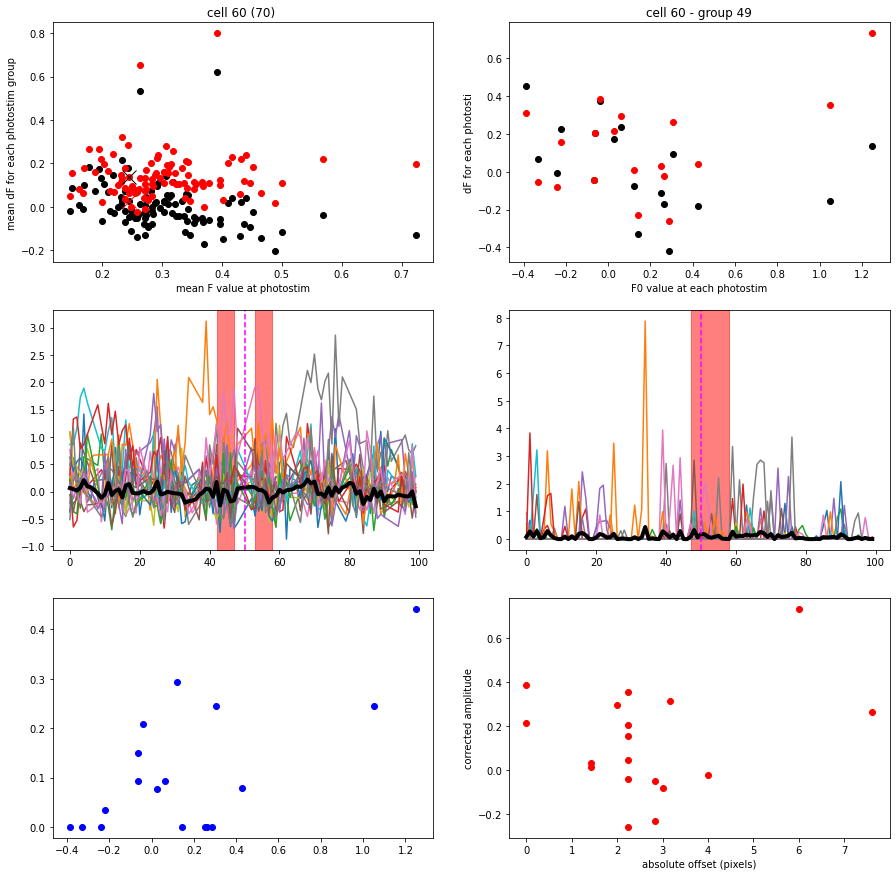

In [13]:
# show the F0 distribution of a given cell for different photostim groups
session_i = 1
session = sessions[session_i]

cell_idx_to_plot = 60#2

cell_idx = cell_idx_to_plot#2#16
cell_i = photostim_data_dict[session]['cell_indices'][cell_idx]
group_idx = 49

step_back_plot = 50
step_forward_plot = 50
session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
xoff = ops['xoff']-np.median(ops['xoff'])
yoff = ops['yoff']-np.median(ops['yoff'])
xy_offset = np.sqrt(xoff**2 + yoff**2)
photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                    scalar_f0 = scalar_f0,
                                                                                    photostim = True,
                                                                                    correct_offset = correct_offset)

F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                   photostim_indices,
                                                                   step_back_plot,#step_back,
                                                                   step_forward_plot)#step_forward)

F_now = F_photostim_aligned[:,cell_i,np.asarray(photostim_groups['group_order'])==group_idx] # this has to be generated beforehand - 


offsets = xy_offset[photostim_indices[np.asarray(photostim_groups['group_order'])==group_idx]]

mean_f0 = photostim_data_dict[session]['mean_f_start'][cell_idx]
mean_df = photostim_data_dict[session]['mean_df'][cell_idx]
mean_df_corr = photostim_data_dict[session]['mean_df_corr'][cell_idx]
f0 = photostim_data_dict[session]['F_start'][cell_idx][group_idx]
df = photostim_data_dict[session]['dF'][cell_idx][group_idx]
df_corr = photostim_data_dict[session]['dF_corr'][cell_idx][group_idx]
F0 = photostim_data_dict[session]['F0'][cell_i]
dspikes = photostim_data_dict[session]['spikes_amplitudes'][cell_idx][group_idx]


fig = plt.figure(figsize = [15,15])
ax=fig.add_subplot(3,2,1)
ax_group=fig.add_subplot(3,2,2)
ax_group_traces = fig.add_subplot(3,2,3)
ax_spikes = fig.add_subplot(3,2,4)
ax_spikes_vs_f0 = fig.add_subplot(3,2,5)
ax_ampl_vs_dislocation = fig.add_subplot(3,2,6)

F_norm = (F_now-F0)/F0
for F0_,F in zip((f0-F0)/F0,F_norm.T):#(F_norm -np.mean(F_norm[baseline_offset:baseline_offset+baseline_length,:],0)).T:
    if F0_>-.4:
        #ax_group_traces.plot(BCI_analysis.pipeline_utils.rollingfun(F,5))
        ax_group_traces.plot(F)
traces_ylim = ax_group_traces.get_ylim()
ax_group_traces.plot(np.nanmean(F_norm -np.nanmean(F_norm[baseline_offset:baseline_offset+baseline_length,:],0),1),'k-',linewidth = 4)
ax_group_traces.fill_between([step_back_plot+peak_offset,step_back_plot+peak_offset+peak_length], [traces_ylim[0]]*2, [traces_ylim[1]]*2,color = 'red',alpha = .5)
ax_group_traces.fill_between([baseline_offset+step_back_plot-step_back,baseline_offset+baseline_length+step_back_plot-step_back], [traces_ylim[0]]*2, [traces_ylim[1]]*2,color = 'red',alpha = .5)
ax_group_traces.vlines(step_back_plot,traces_ylim[0],traces_ylim[1],linestyles = 'dashed',colors = 'magenta')
ax_group_traces.set_ylim(traces_ylim)
ax.plot(mean_f0,mean_df,'ko')
ax.plot(mean_f0,mean_df_corr,'ro')



ax.set_xlabel('mean F value at photostim')
ax.set_ylabel('mean dF for each photostim group')
ax.set_title('cell {} ({}) '.format(cell_idx,cell_i))
ax.plot(mean_f0[group_idx],mean_df[group_idx],'rx',ms = 14,linewidth =6)
ax.plot(mean_f0[group_idx],mean_df_corr[group_idx],'kx',ms = 14,linewidth =6)

ax_group.plot((f0-F0)/F0,df/F0,'ko')
ax_group.plot((f0-F0)/F0,df_corr/F0,'ro')


ax_group.set_xlabel('F0 value at each photostim')
ax_group.set_ylabel('dF for each photosti')
ax_group.set_title('cell {} - group {}'.format(cell_idx,group_idx))


#ax_ampl_vs_dislocation.plot(offsets,df/F0,'ko')
ax_ampl_vs_dislocation.plot(offsets,df_corr/F0,'ro')
ax_ampl_vs_dislocation.set_xlabel('absolute offset (pixels)')
ax_ampl_vs_dislocation.set_ylabel('corrected amplitude')

ax_spikes_vs_f0.plot((f0-F0)/F0,dspikes,'bo')
spikes_aligned = BCI_analysis.io_suite2p.align_trace_to_event(np.asarray(spikes_matrix_ALL[session_i]),
                                                              photostim_indices,
                                                              step_back_plot,#step_back,
                                                              step_forward_plot)#step_forward

F_now = spikes_aligned[:,cell_i,np.asarray(photostim_groups['group_order'])==group_idx]
for F0_,F in zip((f0-F0)/F0,(F_now).T):#-np.mean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)
    if F0_>-.4:
        #ax_spikes.plot(BCI_analysis.pipeline_utils.rollingfun(F,5))
        ax_spikes.plot(F)
spikes_ylim = ax_spikes.get_ylim()

ax_spikes.fill_between([step_back_plot-peak_offset,step_back_plot+peak_offset+peak_length], [spikes_ylim[0]]*2, [spikes_ylim[1]]*2,color = 'red',alpha = .5)
ax_spikes.plot(np.nanmean(F_now,1),'k-',linewidth = 4)#-np.mean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)
ax_spikes.vlines(step_back_plot,spikes_ylim[0],spikes_ylim[1],linestyles = 'dashed',colors = 'magenta')
ax_spikes.set_ylim(spikes_ylim)

In [242]:


# F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
#                                                                    photostim_indices,
#                                                                    50,#step_back,
#                                                                    50)#step_forward)


photostim offset from trial start is 0 frames


[]

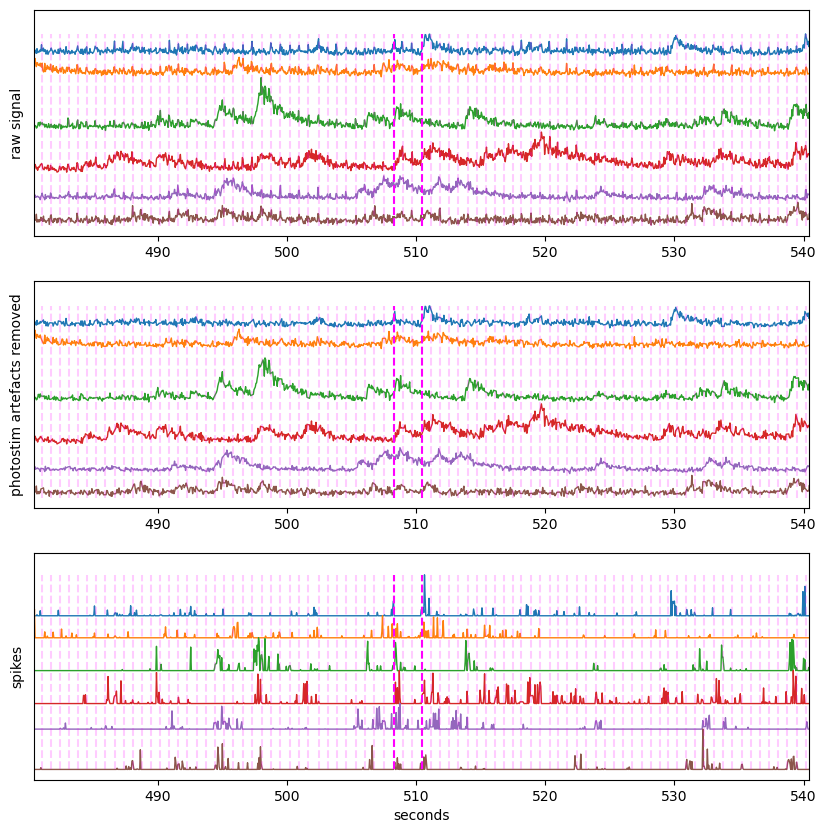

In [250]:

session_i = 1
session = sessions[session_i]

group_idx =4
max_distance_from_photostim = 10

session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
xoff = ops['xoff']-np.median(ops['xoff'])
yoff = ops['yoff']-np.median(ops['yoff'])
xy_offset = np.sqrt(xoff**2 + yoff**2)
photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                    scalar_f0 = False,
                                                                                    photostim = False,
                                                                                    correct_offset = False)
dFF_photostim_denoised,F_photostim_denoised,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                    scalar_f0 = False,
                                                                                    photostim = True,
                                                                                    correct_offset = False)


# mean_df_list = []
# for cell_idx in range(len(photostim_data_dict[session]['mean_df_corr'])):
#     mean_df_list.append(photostim_data_dict[session]['mean_df_corr'][cell_idx][group_idx])
# cells_to_plot= np.argsort(mean_df_list)[-5:] # cells_to_plot =[12,  28,  31, 210,  92, 235,  64, 123,   4,  66, 126]# [3,22,15,16,17]
cells_to_plot = np.where(np.asarray(distances_matrix)[group_idx,:]<max_distance_from_photostim)[0]
#cells_to_plot = np.asarray([0,1,2,3,4,5])+150
midx = 1+np.argmin(np.diff(photostim_indices[np.where(np.asarray(photostim_groups['group_order'])==group_idx)[0]]))
trange = [-30,30]+photostim_indices[np.where(np.asarray(photostim_groups['group_order'])==group_idx)[0]][midx]/20
#trange = [0,60]#+photostim_indices[np.where(np.asarray(photostim_groups['group_order'])==group_idx)[0]][0]/20
linewidth = 1
fig = plt.figure(figsize = [10,10])
ax_sample_not_corrected = fig.add_subplot(3,1,1)
ax_sample_corrected = fig.add_subplot(3,1,2,sharex = ax_sample_not_corrected, sharey = ax_sample_not_corrected)
ax_spikes = fig.add_subplot(3,1,3,sharex = ax_sample_not_corrected)

offset = 0
offset_spikes = 0
time = np.arange(dFF_photostim.shape[1])/20
range_idx = [np.argmax(time>trange[0]),np.argmax(time>trange[-1])]
select_photostim_indices = []
for cell_idx in cells_to_plot:
    cell = photostim_data_dict[session]['cell_indices'][cell_idx]
    dff = F_photostim[cell,:]
    spikes = spikes_matrix_ALL[session_i][cell]
    offset -= np.max(dff[range_idx[0]:range_idx[-1]])
    offset_spikes -= np.max(spikes[range_idx[0]:range_idx[-1]])
    ax_sample_not_corrected.plot(time,dff+offset,linewidth = linewidth)
    ax_sample_corrected.plot(time,F_photostim_denoised[cell,:]+offset,linewidth = linewidth)
    ax_spikes.plot(time,spikes+offset_spikes,linewidth = linewidth)
    
ax_sample_not_corrected.set_xlim([trange[0],trange[-1]])
ax_sample_not_corrected.vlines(photostim_indices/20,offset,0,linestyles = 'dashed',colors = 'magenta',alpha = .2)
ax_sample_corrected.vlines(photostim_indices/20,offset,0,linestyles = 'dashed',colors = 'magenta',alpha = .2)
ax_spikes.vlines(photostim_indices/20,offset_spikes,0,linestyles = 'dashed',colors = 'magenta',alpha = .2)

select_photostim_indices = photostim_indices[np.where(np.asarray(photostim_groups['group_order'])==group_idx)[0]]

ax_sample_not_corrected.vlines(select_photostim_indices/20,offset,0,linestyles = 'dashed',colors = 'magenta',alpha = 1)
ax_sample_corrected.vlines(select_photostim_indices/20,offset,0,linestyles = 'dashed',colors = 'magenta',alpha = 1)
ax_spikes.vlines(select_photostim_indices/20,offset_spikes,0,linestyles = 'dashed',colors = 'magenta',alpha = 1) 


ax_sample_not_corrected.set_ylabel('raw signal')
ax_sample_corrected.set_ylabel('photostim artefacts removed')
ax_spikes.set_ylabel('spikes')


ax_spikes.set_xlabel('seconds')
ax_sample_corrected.set_yticks([])
ax_spikes.set_yticks([])


In [100]:
cell_idx_to_plot = 12

cell_idx = cell_idx_to_plot#2#16
cell_i = photostim_data_dict[session]['cell_indices'][cell_idx]
session = '071322'


session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()

photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                                    scalar_f0 = scalar_f0,
                                                                                    photostim = True,
                                                                                    correct_offset = correct_offset)

F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                   photostim_indices,
                                                                   step_back,
                                                                   step_forward)
slope_list = []
amplitude_list = []
f0_list = []
for group_idx in range(100):

    F_now = F_photostim_aligned[:,cell_i,np.asarray(photostim_groups['group_order'])==group_idx] # this has to be generated beforehand - 



    mean_f0 = photostim_data_dict[session]['mean_f_start'][cell_idx]
    mean_df = photostim_data_dict[session]['mean_df'][cell_idx]
    mean_df_corr = photostim_data_dict[session]['mean_df_corr'][cell_idx]
    f0 = photostim_data_dict[session]['F_start'][cell_idx][group_idx]
    df = photostim_data_dict[session]['dF'][cell_idx][group_idx]
    df_corr = photostim_data_dict[session]['dF_corr'][cell_idx][group_idx]
    F0 = photostim_data_dict[session]['F0'][cell_i]
    needed = (np.isnan(f0)==False) & (np.isnan(df_corr)==False)
    p = np.polyfit(f0[needed],df_corr[needed],1)
    slope_list.append(p[0])
    amplitude_list.append(np.nanmean(df_corr))
    f0_list.append(np.nanmean(f0))


photostim offset from trial start is 0 frames


In [53]:
np.argsort(slope_list)

array([44, 31,  3, 85, 45, 72, 47, 77,  8, 19, 53, 74, 36, 80, 49,  5,  0,
       58, 22, 34,  6, 35, 52, 87, 24, 66,  1, 84, 70, 10,  9, 43, 93, 37,
       76, 91, 79, 32, 46, 98, 30, 89, 42, 69, 99, 25, 57, 60, 95, 83, 78,
       51, 73, 12, 50, 62, 96, 94, 20, 27, 68,  7, 88, 29, 21,  4, 65, 55,
       90, 71, 61, 15, 38, 63, 39, 14, 86, 75, 26,  2, 64, 13, 17, 54, 97,
       67, 33, 82, 28, 56, 11, 40, 48, 59, 16, 41, 92, 81, 18, 23])

(array([ 8., 26., 27., 19., 13.,  2.,  0.,  1.,  2.,  2.]),
 array([-3.18291884, -1.15461396,  0.87369092,  2.90199581,  4.93030069,
         6.95860558,  8.98691046, 11.01521535, 13.04352023, 15.07182511,
        17.10013   ]),
 <BarContainer object of 10 artists>)

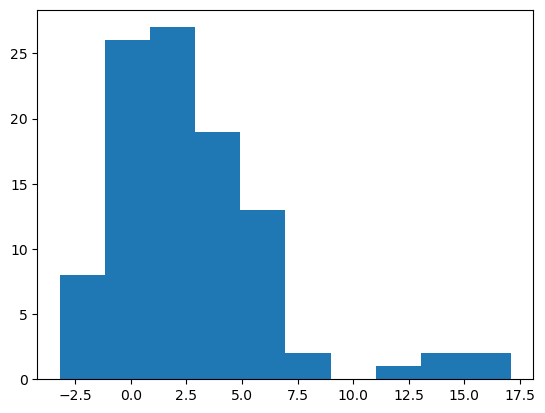

In [58]:
plt.hist(amplitude_list)

Text(0, 0.5, 'mean amplitude')

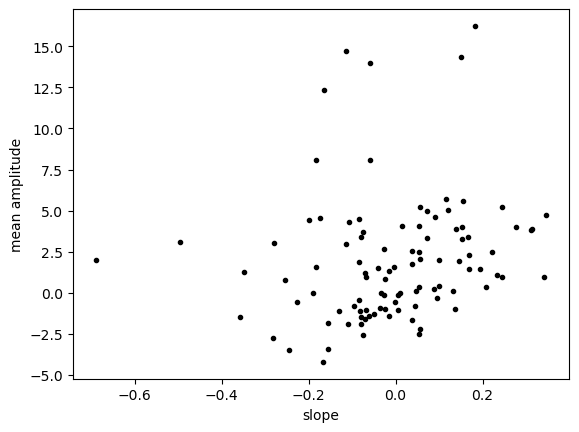

In [101]:
plt.plot(slope_list,amplitude_list,'k.')
plt.xlabel('slope')
plt.ylabel('mean amplitude')

# trying to find the best fitting method

In [ ]:
# linear regression only on f0 -  with removing big amplitude events by looking at amplitude distribution
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.decomposition import PCA

parts_of_trace_to_predict = 10

correct_slow_drift = False

session = sessions[0]

scalar_f0 = False
correct_offset = False
sample_only_at_photostim = False
n_random_groups_per_stimgroup_per_cell  = 50
session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
photostim_group_order = np.asarray(photostim_groups['group_order'])
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                        scalar_f0 = scalar_f0,
                                                                        photostim = True,
                                                                        correct_offset = correct_offset)
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]


F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                   photostim_indices,
                                                                   step_back,
                                                                   step_forward)


cell_to_predict = 17
fitted_f0  = F0s[cell_to_predict]

F_matrix = F_photostim[needed_cells_with_activity,:]
F0s = np.asarray(photostim_data_dict[session]['fitted_f0'])

F_photostim_aligned = F_photostim_aligned[:,needed_cells_with_activity,:] - F0s[np.newaxis,:,np.newaxis]


f = F_matrix[cell_to_predict,:]
if correct_slow_drift:
    x = np.arange(len(np.mean(F0_photostim,0)))
    y_nonnorm = np.mean(F0_photostim,0)
    y = y_nonnorm/np.mean(y_nonnorm[0:1000])
    p_slow_drif = np.polyfit(x,y,1)
    print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))
    correction = x*(p_slow_drif[0])*f
    f -= correction
f_start = np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same')[:-offset]
f_peak = np.convolve(f,np.ones([peak_length])/peak_length,mode = 'same')[offset:]
f_slope_matrix = BCI_analysis.io_suite2p.align_trace_to_event(np.asarray([f,f]),
                                                               np.arange(len(f)),
                                                               int(slope_length/2),
                                                               int(slope_length/2))
amplitudes = f_peak-f_start
f0s = f_start-F0s[cell_to_predict]

Y_slopes = f_slope_matrix[:,0,:-offset].T
X_slopes = np.arange(slope_length)[np.newaxis,:]

slopes = (  np.nanmean(X_slopes*Y_slopes,axis=1) - np.nanmean(X_slopes)*np.nanmean(Y_slopes,axis=1)  ) / ((X_slopes**2).mean() - (X_slopes.mean())**2)


###### IDE JON AZ UJITAS!!
import scipy

fitted_f0  = F0s[cell_to_predict]/2
minimum_bin_n = 500
dff_range = [0,10]
minimum_dff_max = 2
corrcoeff = 0
diff_max_offset =0

x_range = np.percentile(f0s,[1,99])
# x_range[0] = np.max([F0*(dff_range[0]+1),x_range[0]])
# x_range[1] = np.min([F0*(dff_range[1]+1),x_range[1]])
bin_num = int(np.diff(x_range)/fitted_f0)
f0s_used = f0s[(f0s>x_range[0])&(f0s<x_range[1])]

bin_start = []
bin_end = []
bin_center = []
bin_n = []
bin_max_amplitude = []
for bin_i in np.arange(bin_num):
    min_x_val = x_range[0]+bin_i*np.diff(x_range)/bin_num
    max_x_val = x_range[0]+(bin_i+1)*np.diff(x_range)/bin_num
    # min_x_val = np.percentile(f0s_used,lower_percentiles[bin_i])
    # max_x_val = np.percentile(f0s_used,upper_percentiles[bin_i])


    needed_idx = (f0s>min_x_val) & (f0s<max_x_val)
    f0_now = f0s[needed_idx]
    amplitudes_now = amplitudes[needed_idx]
    amplitudes_now = amplitudes_now[np.isnan(amplitudes_now)==False]
    modeval = scipy.stats.mode(np.round(amplitudes_now,0)).mode[0]

    min_amplitude = np.percentile(amplitudes_now,1)
    max_amplitude = modeval + (modeval-min_amplitude)
    
    #adas
    
    n = len(amplitudes_now)
    bin_center.append(np.nanmean(f0_now))
    bin_start.append(min_x_val)
    bin_end.append(max_x_val)
    bin_max_amplitude.append(max_amplitude)
    bin_n.append(n)
            

        
needed_bin = (np.isnan(bin_center) == False) & (np.asarray(bin_n)>minimum_bin_n)
bin_n = np.asarray(bin_n)[needed_bin]
bin_center = np.asarray(bin_center)[needed_bin]
bin_start = np.asarray(bin_start)[needed_bin]
bin_end = np.asarray(bin_end)[needed_bin]
bin_max_amplitude = np.asarray(bin_max_amplitude)[needed_bin]
p = np.polyfit(bin_center,bin_max_amplitude,1)

needed = amplitudes <= np.polyval(p,f0s)
###### IDE JON AZ UJITAS!!
amplitudes_to_fit = amplitudes[needed]
f0s_to_fit = f0s[needed]



X = np.asarray([f0s_to_fit,np.ones(f0s_to_fit.shape)]).T#,
y = amplitudes_to_fit

part_coefs_all = []
for part_i in range(parts_of_trace_to_predict):
    start_idx = int(len(f0s_to_fit)/parts_of_trace_to_predict)*part_i
    end_idx  = int(len(f0s_to_fit)/parts_of_trace_to_predict)*(part_i+1)
    clf_ = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X[start_idx:end_idx,:], y[start_idx:end_idx])
    part_coefs_all.append(clf_.coef_)

clf = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X, y)



X = np.asarray([f0s,np.ones(f0s.shape)]).T
y = amplitudes


amplitudes_pred_ridge = clf.predict(X)

amplitudes_corr_ridge = amplitudes-amplitudes_pred_ridge

corrected_group_amplitudes_all_ridge  = []
group_amplitudes_all= []
group_f0s_all= []

mean_corrected_group_amplitudes_all_ridge  = []
mean_group_amplitudes_all= []
mean_group_f0s_all= []


group_mean_amplitudes_random_corrected_ridge= []
group_mean_amplitudes_random= []
group_mean_f0s_random= []

clf.score(X, y)



for group_idx in range(len(photostim_groups['groups'])):
    F_now = F_photostim_aligned[:,cell_to_predict,photostim_group_order==group_idx]
    repeats = F_now.shape[1]
    group_stim_F0s = np.nanmean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)#  +  F0s[cell_to_predict]
    group_stim_Fpeaks = np.nanmean(F_now[step_back+peak_offset:step_back+peak_offset+peak_length,:],0)# +  F0s[cell_to_predict]
    group_amplitudes = group_stim_Fpeaks-group_stim_F0s
    
    group_stim_F0s[np.isnan(group_stim_F0s)] = np.nanmean(group_stim_F0s)
    
    group_correction_ridge = -1*clf.predict(np.asarray([group_stim_F0s,np.ones(group_stim_F0s.shape)]).T)
    corrected_group_amplitudes_ridge = group_correction_ridge+ group_amplitudes
    corrected_group_amplitudes_all_ridge.append(corrected_group_amplitudes_ridge)
    
    group_amplitudes_all.append(group_amplitudes)
    group_f0s_all.append(group_stim_F0s)
    
    mean_corrected_group_amplitudes_all_ridge.append(np.nanmean(corrected_group_amplitudes_ridge))
    
    mean_group_amplitudes_all.append(np.nanmean(group_amplitudes))
    mean_group_f0s_all.append(np.nanmean(group_stim_F0s))
    


for group_idx in range(len(photostim_groups['groups'])):# sample photostim amplitudes for the mock distribution of amplitudes
    repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
    mean_amplitudes_corrected_ridge = []
    mean_amplitudes_corrected_lasso = []
    mean_amplitudes = []
    mean_f0s = []

    gaa = np.concatenate(group_amplitudes_all)
    cgaar = np.concatenate(corrected_group_amplitudes_all_ridge)
    cgaal = np.concatenate(corrected_group_amplitudes_all_lasso)
    gf0 = np.concatenate(group_f0s_all)
    for i in range(n_random_groups_per_stimgroup_per_cell):
        if sample_only_at_photostim:
            random_indices = np.random.choice(range(len(gaa)),repeats)
            
            mean_amplitudes_corrected_ridge.append(np.nanmean(cgaar[random_indices]))
            
            mean_amplitudes.append(np.nanmean(gaa[random_indices]))
            mean_f0s.append(np.nanmean(gf0[random_indices]))
        else:
            random_indices = np.random.choice(range(len(amplitudes)),repeats)
            
            mean_amplitudes_corrected_ridge.append(np.nanmean(amplitudes_corr_ridge[random_indices]))
            
            mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
            mean_f0s.append(np.nanmean(f0s[random_indices]))

    group_mean_amplitudes_random_corrected_ridge.append(mean_amplitudes_corrected_ridge)
    group_mean_amplitudes_random.append(mean_amplitudes)
    group_mean_f0s_random.append(mean_f0s)









In [138]:
reg.intercept_/reg.coef_[1]


-6.504977136901368

In [134]:
reg.coef_

array([ 0.        , -0.19036619,  0.        ])

In [130]:
part_intercepts_all

[]

In [143]:
np.asarray(part_coefs_all)[:,1]


array([-0.32328724, -0.33912953, -0.38898711, -0.34176502, -0.34731676,
       -0.34123555, -0.36532406, -0.37997921, -0.33986048, -0.35798696])

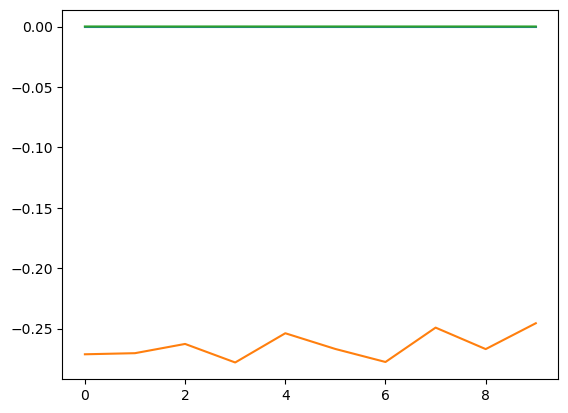

In [432]:

plt.plot(part_coefs_all)
#part_coefs_all
plt.plot(np.asarray(part_intercepts_all)/np.asarray(part_coefs_all)[:,1],'k.')

In [110]:
reg.score(X,y)

-0.17951470265769198

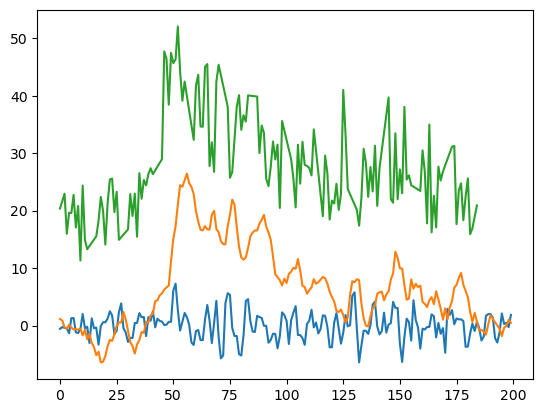

In [504]:
plt.plot(slopes[:200])
plt.plot((f0s)[:200])
plt.plot(f[15:200])

In [538]:
# linear regression on the slope and F0 of only the postsynaptic cell to try to predict the amplitude
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.decomposition import PCA

parts_of_trace_to_predict = 10

correct_slow_drift = False

slope_length  = baseline_length
slope_offset = baseline_offset

session = sessions[1]
scalar_f0 = False
correct_offset = False
sample_only_at_photostim = False
n_random_groups_per_stimgroup_per_cell  = 50
session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
photostim_group_order = np.asarray(photostim_groups['group_order'])
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                        scalar_f0 = scalar_f0,
                                                                        photostim = True,
                                                                        correct_offset = correct_offset)
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]


F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                   photostim_indices,
                                                                   step_back,
                                                                   step_forward)


cell_to_predict = 55


F_matrix = F_photostim[needed_cells_with_activity,:]
F0s = np.asarray(photostim_data_dict[session]['fitted_f0'])
#####F0s[cell_to_predict] -=10
F_photostim_aligned = F_photostim_aligned[:,needed_cells_with_activity,:] - F0s[np.newaxis,:,np.newaxis]


f = F_matrix[cell_to_predict,:]
if correct_slow_drift:
    x = np.arange(len(np.mean(F0_photostim,0)))
    y_nonnorm = np.mean(F0_photostim,0)
    y = y_nonnorm/np.mean(y_nonnorm[0:1000])
    p_slow_drif = np.polyfit(x,y,1)
    print('slow decay is {:.3f}% per minute'.format(p_slow_drif[0]*20*60*100))
    correction = x*(p_slow_drif[0])*f
    f -= correction
f_start = np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same')[:-offset]
f_peak = np.convolve(f,np.ones([peak_length])/peak_length,mode = 'same')[offset:]
f_slope_matrix = BCI_analysis.io_suite2p.align_trace_to_event(np.asarray([f,f]),
                                                               np.arange(len(f)),
                                                              0,
                                                              slope_length)
                                                               # int(slope_length/2),
                                                               # int(slope_length/2))
Y_slopes = f_slope_matrix[:,0,:-offset].T
X_slopes = np.arange(slope_length)[np.newaxis,:]

slopes_all = (  np.nanmean(X_slopes*Y_slopes,axis=1) - np.nanmean(X_slopes)*np.nanmean(Y_slopes,axis=1)  ) / ((X_slopes**2).mean() - (X_slopes.mean())**2)
slopes_down = slopes_all.copy()
slopes_down[slopes_down>-10000] = 0
slopes_up = slopes_all.copy()
slopes_up[slopes_up<-10000] = 0
amplitudes = f_peak-f_start
f0s = f_start-F0s[cell_to_predict]


slopes = slopes_all[10:]
slopes_up = slopes_up[10:]
slopes_down = slopes_down[10:]
amplitudes = amplitudes[10:]
f0s = f0s[10:]

df_corr_mode = -100
percentile_to_use = 100
amplitudes_corr_ridge = amplitudes


spikes_trace = np.asarray(spikes_matrix_ALL[session_i])[cell_idx,:]
spikes_base = BCI_analysis.pipeline_utils.rollingfun(spikes_trace,baseline_length,'mean')
spikes_peak = BCI_analysis.pipeline_utils.rollingfun(spikes_trace,peak_length)
spike_amplitudes = spikes_peak[offset:]#-spikes_base[:-offset]
spikes_base = spikes_base[:-offset]
spikes_base = spikes_base[10:]
spike_amplitudes = spike_amplitudes[10:]

while df_corr_mode<0:
    percentile_to_use -= 1
    needed = amplitudes_corr_ridge <= np.percentile(amplitudes_corr_ridge,percentile_to_use)
    slopes_to_fit = slopes[needed]
    slopes_up_to_fit = slopes_up[needed]
    slopes_down_to_fit = slopes_down[needed]
    amplitudes_to_fit = amplitudes[needed]
    f0s_to_fit = f0s[needed]



    X = np.asarray([f0s_to_fit,slopes_up_to_fit,f0s_to_fit**2]).T#,np.ones(f0s.shape)
    #X = np.asarray([f0s_to_fit*0,f0s_to_fit,f0s_to_fit**3]).T#,np.ones(f0s.shape)

    y = amplitudes_to_fit

    
    part_coefs_all = []
    part_intercepts_all = []
    for part_i in range(parts_of_trace_to_predict):
        start_idx = int(len(f0s_to_fit)/parts_of_trace_to_predict)*part_i
        end_idx  = int(len(f0s_to_fit)/parts_of_trace_to_predict)*(part_i+1)
        clf_ = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X[start_idx:end_idx,:], y[start_idx:end_idx])
        part_coefs_all.append(clf_.coef_)
        part_intercepts_all.append(clf_.intercept_)



    reg = LassoCV(cv=5, random_state=0).fit(X, y)
    clf = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X, y)



    X = np.asarray([f0s,slopes_up,f0s**2]).T#,np.ones(f0s.shape)
    #X = np.asarray([f0s*0,f0s,f0s**3]).T#,np.ones(f0s.shape)

    y = amplitudes


    amplitudes_pred_ridge = clf.predict(X)
    amplitudes_pred_lasso = reg.predict(X)

    amplitudes_corr_ridge = amplitudes-amplitudes_pred_ridge
    amplitudes_corr_lasso = amplitudes-amplitudes_pred_lasso

    modeval = scipy.stats.mode(np.round(amplitudes_corr_ridge,1))
    df_corr_mode = modeval.mode[0]



corrected_group_amplitudes_all_ridge  = []
corrected_group_amplitudes_all_lasso  = []
group_amplitudes_all= []
group_f0s_all= []

mean_corrected_group_amplitudes_all_ridge  = []
mean_corrected_group_amplitudes_all_lasso  = []
mean_group_amplitudes_all= []
mean_group_f0s_all= []


group_mean_amplitudes_random_corrected_ridge= []
group_mean_amplitudes_random_corrected_lasso= []
group_mean_amplitudes_random= []
group_mean_f0s_random= []



clf.score(X, y)



for group_idx in range(len(photostim_groups['groups'])):
    F_now = F_photostim_aligned[:,cell_to_predict,photostim_group_order==group_idx]
    repeats = F_now.shape[1]
    group_stim_F0s = np.nanmean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)#  +  F0s[cell_to_predict]
    group_stim_Fpeaks = np.nanmean(F_now[step_back+peak_offset:step_back+peak_offset+peak_length,:],0)# +  F0s[cell_to_predict]
    group_amplitudes = group_stim_Fpeaks-group_stim_F0s
    Y_slopes = F_now[slope_offset:slope_offset+slope_length,:].T
    X_slopes = np.arange(slope_length)[np.newaxis,:]
    group_stim_slopes = (  np.nanmean(X_slopes*Y_slopes,axis=1) - np.nanmean(X_slopes)*np.nanmean(Y_slopes,axis=1)  ) / ((X_slopes**2).mean() - (X_slopes.mean())**2)
    
    group_stim_F0s[np.isnan(group_stim_F0s)] = np.nanmean(group_stim_F0s)
    group_stim_slopes[np.isnan(group_stim_slopes)] = np.nanmean(group_stim_slopes)
    group_stim_slopes_up = group_stim_slopes.copy()
    group_stim_slopes_down = group_stim_slopes.copy()
    group_stim_slopes_up[group_stim_slopes_up<-10000] = 0
    group_stim_slopes_down[group_stim_slopes_down>-10000] = 0
    
    group_correction_ridge = -1*clf.predict(np.asarray([group_stim_F0s,group_stim_slopes_up,group_stim_F0s**2]).T)#,np.ones(group_stim_F0s.shape)
    group_correction_lasso = -1*reg.predict(np.asarray([group_stim_F0s,group_stim_slopes_up,group_stim_F0s**2]).T)#,np.ones(group_stim_F0s.shape)
    #group_correction_ridge = -1*clf.predict(np.asarray([group_stim_F0s*0,group_stim_F0s,group_stim_F0s**3]).T)#,np.ones(group_stim_F0s.shape)
    #group_correction_lasso = -1*reg.predict(np.asarray([group_stim_F0s*0,group_stim_F0s,group_stim_F0s**3]).T)#,np.ones(group_stim_F0s.shape)

    #(group_stim_F0s-p[1])/timeConstant*(offset_photostim/offset) #

    corrected_group_amplitudes_ridge = group_correction_ridge+ group_amplitudes
    corrected_group_amplitudes_lasso = group_correction_lasso+ group_amplitudes
    
    corrected_group_amplitudes_all_lasso.append(corrected_group_amplitudes_lasso)
    corrected_group_amplitudes_all_ridge.append(corrected_group_amplitudes_ridge)
    
    group_amplitudes_all.append(group_amplitudes)
    group_f0s_all.append(group_stim_F0s)
    
    
    mean_corrected_group_amplitudes_all_lasso.append(np.nanmean(corrected_group_amplitudes_lasso))
    mean_corrected_group_amplitudes_all_ridge.append(np.nanmean(corrected_group_amplitudes_ridge))
    
    mean_group_amplitudes_all.append(np.nanmean(group_amplitudes))
    mean_group_f0s_all.append(np.nanmean(group_stim_F0s))
    


for group_idx in range(len(photostim_groups['groups'])):# sample photostim amplitudes for the mock distribution of amplitudes
    repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
    mean_amplitudes_corrected_ridge = []
    mean_amplitudes_corrected_lasso = []
    mean_amplitudes = []
    mean_f0s = []

    gaa = np.concatenate(group_amplitudes_all)
    cgaar = np.concatenate(corrected_group_amplitudes_all_ridge)
    cgaal = np.concatenate(corrected_group_amplitudes_all_lasso)
    gf0 = np.concatenate(group_f0s_all)
    for i in range(n_random_groups_per_stimgroup_per_cell):
        if sample_only_at_photostim:
            random_indices = np.random.choice(range(len(gaa)),repeats)
            
            mean_amplitudes_corrected_ridge.append(np.nanmean(cgaar[random_indices]))
            mean_amplitudes_corrected_lasso.append(np.nanmean(cgaal[random_indices]))
            
            mean_amplitudes.append(np.nanmean(gaa[random_indices]))
            mean_f0s.append(np.nanmean(gf0[random_indices]))
        else:
            random_indices = np.random.choice(range(len(amplitudes)),repeats)
            
            mean_amplitudes_corrected_ridge.append(np.nanmean(amplitudes_corr_ridge[random_indices]))
            mean_amplitudes_corrected_lasso.append(np.nanmean(amplitudes_corr_lasso[random_indices]))
            
            mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
            mean_f0s.append(np.nanmean(f0s[random_indices]))

    group_mean_amplitudes_random_corrected_ridge.append(mean_amplitudes_corrected_ridge)
    group_mean_amplitudes_random_corrected_lasso.append(mean_amplitudes_corrected_lasso)
    group_mean_amplitudes_random.append(mean_amplitudes)
    group_mean_f0s_random.append(mean_f0s)


photostim offset from trial start is 0 frames


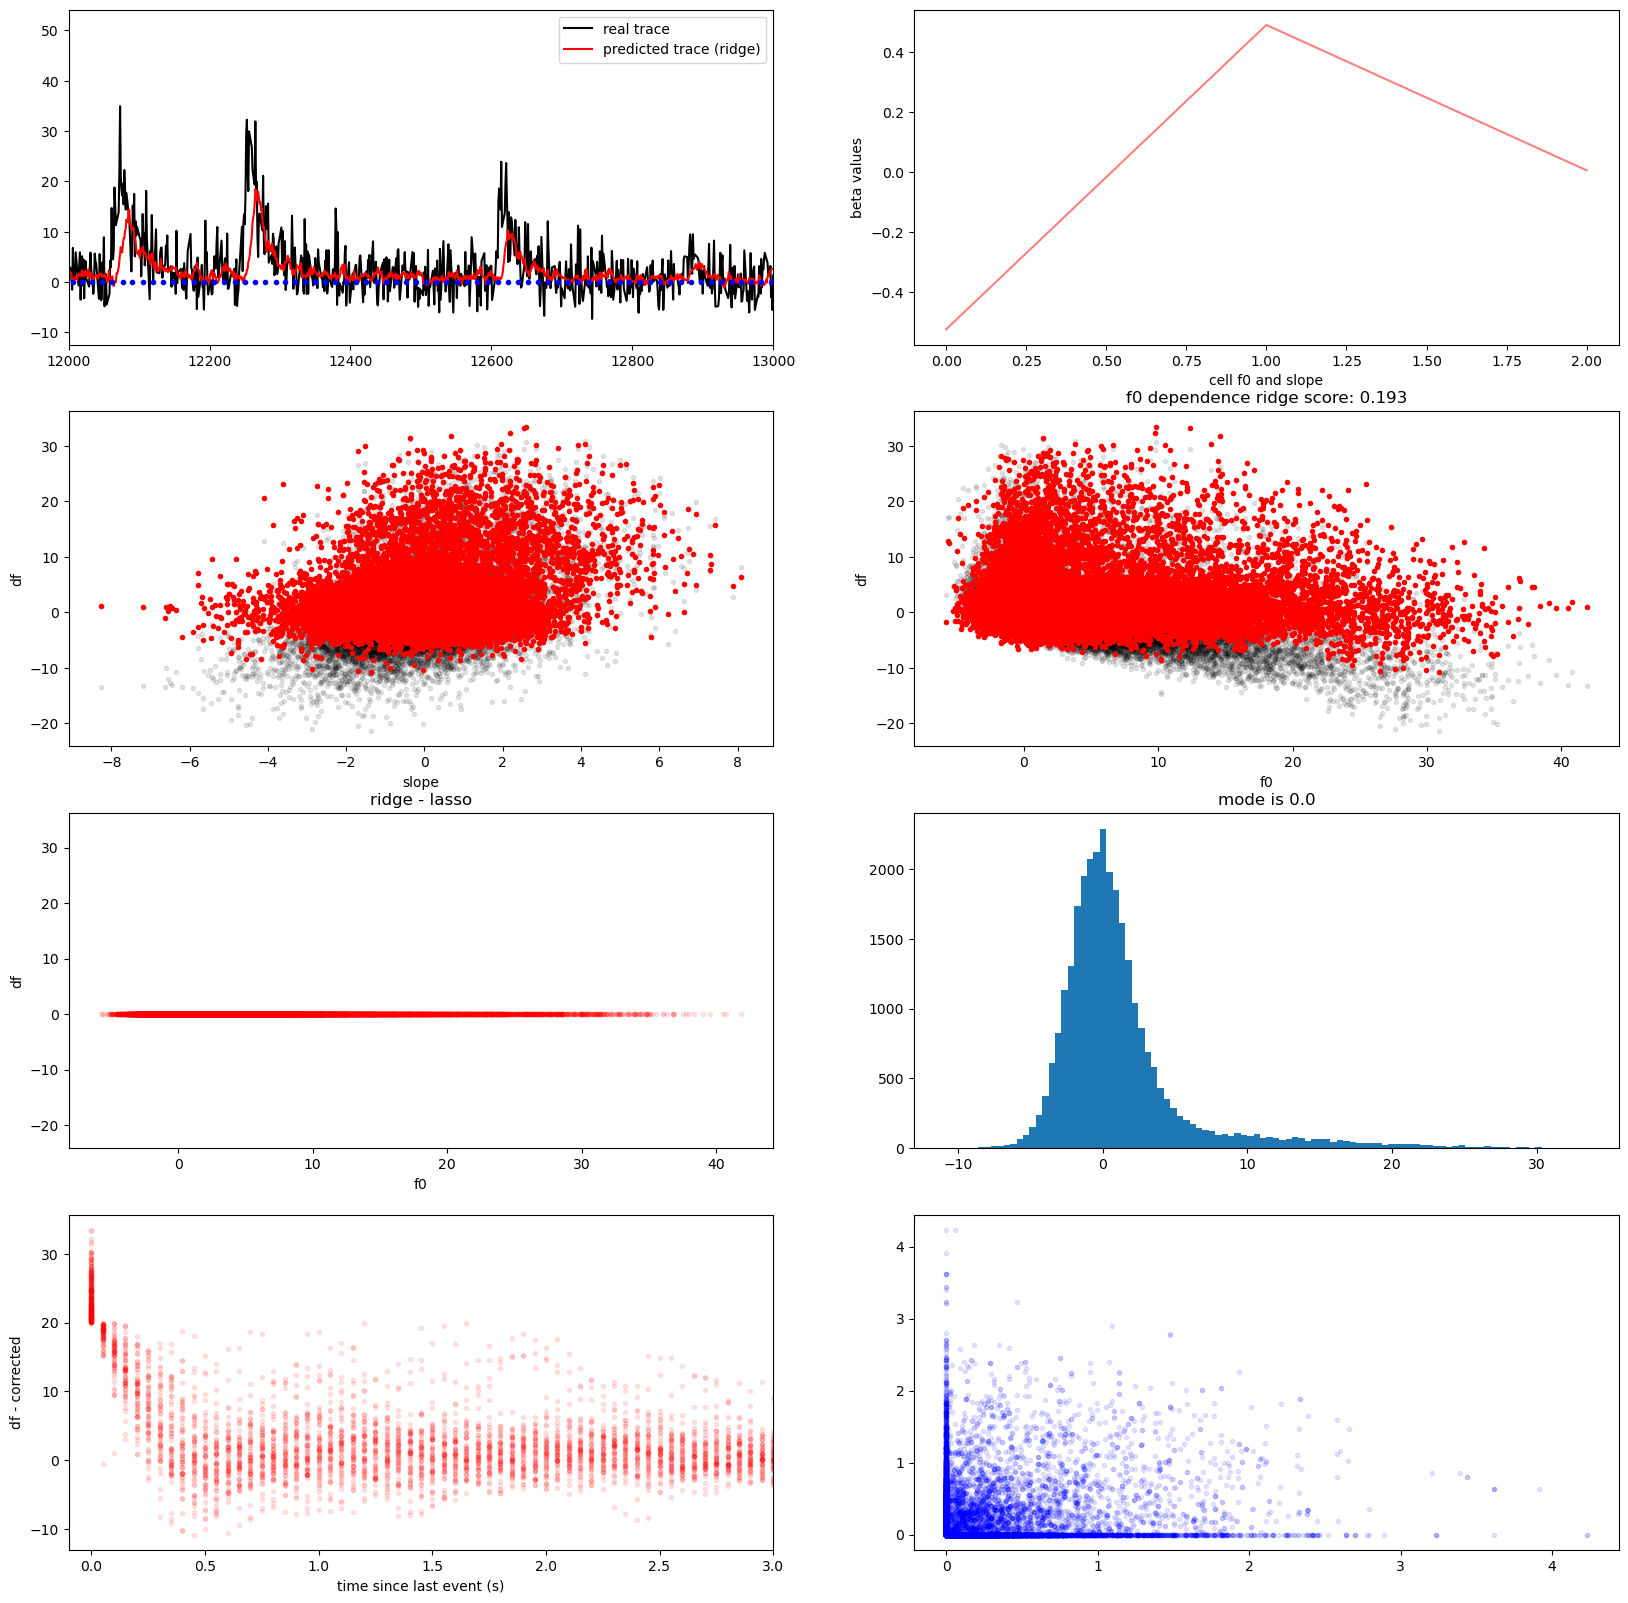

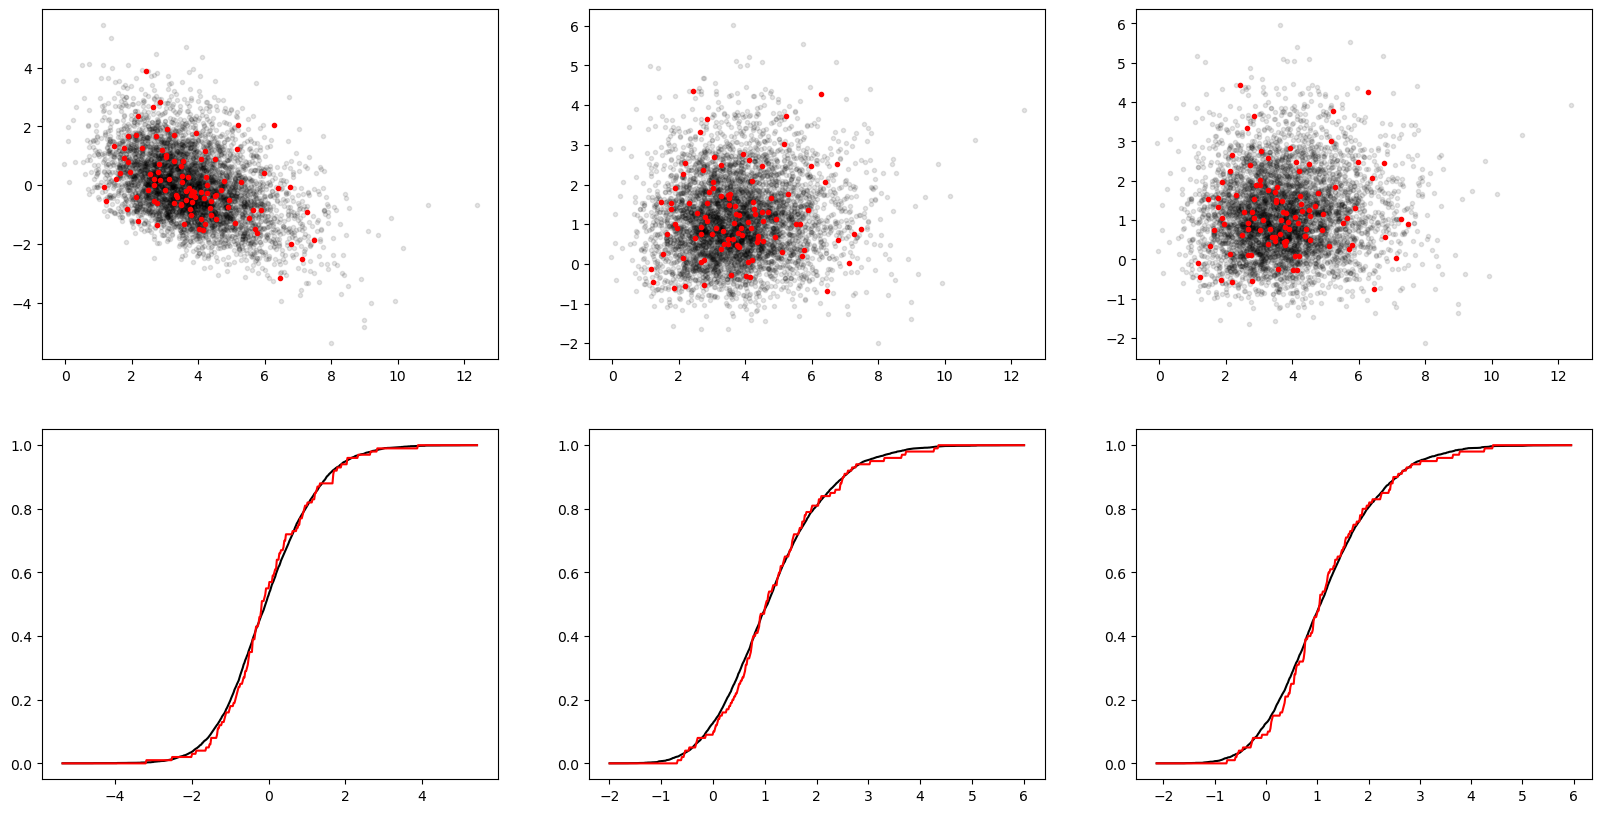

In [539]:
#plot fit with slope

frames_since_last_spike = []
s_last = 0
for s in amplitudes_corr_ridge>20:
    if s:
        s_last = 0
    else:
        s_last +=1
    frames_since_last_spike.append(s_last)

to_highlight = np.asarray(frames_since_last_spike)<5

import scipy
fig = plt.figure(figsize = [20,20])
ax_trace = fig.add_subplot(4,2,1)
#ax_trace.plot(f0s+amplitudes,'k-',label = 'real trace')
ax_trace.plot(f[10+offset:]-F0s[cell_to_predict],'k-',label = 'real trace')
#ax_trace.plot(f0s+amplitudes_pred_lasso,'c--',label = 'predicted trace (lasso)',alpha = .5)
ax_trace.plot(f0s+amplitudes_pred_ridge,'r-',label = 'predicted trace (ridge)',alpha = 1)
ax_trace.plot(photostim_indices,np.zeros_like(photostim_indices),'b.')
ax_trace.set_xlim([12000,13000])
ax_trace.legend()


ax_coef = fig.add_subplot(4,2,2)
# try:
#     #ax_coef.plot(reg.coef_/np.asarray(photostim_data_dict[session]['fitted_f0']*2),'c.',alpha = .5)#*2
#     ax_coef.plot(clf.coef_/np.asarray(photostim_data_dict[session]['fitted_f0']*2),'r-',alpha = .5)#*2
# except:
    #ax_coef.plot(reg.coef_,'c.',alpha = .5)#/np.asarray(photostim_data_dict[session]['fitted_f0'])
ax_coef.plot(clf.coef_,'r-',alpha = .5)#/np.asarray(photostim_data_dict[session]['fitted_f0'])
ax_coef.set_xlabel('cell f0 and slope')
ax_coef.set_ylabel('beta values')

#plt.plot(amplitudes,amplitudes_pred,'k.',alpha = .2)

ax_amplitude_vs_f0 = fig.add_subplot(4,2,3)
ax_amplitude_vs_f0.plot(slopes,amplitudes,'k.',alpha = .1)
ax_amplitude_vs_f0.plot(slopes,amplitudes-amplitudes_pred_ridge,'r.' ,alpha = 1)
# ax_amplitude_vs_f0.plot(slopes[to_highlight],amplitudes[to_highlight],'kx',alpha = .5)
# ax_amplitude_vs_f0.plot(slopes[to_highlight],amplitudes[to_highlight]-amplitudes_pred_ridge[to_highlight],'rx' ,alpha = .5)
ax_amplitude_vs_f0.set_xlabel('slope')
ax_amplitude_vs_f0.set_ylabel('df')
#ax_amplitude_vs_f0.set_title('slope dependence ridge score: {:.3f}'.format(reg.score(X,y)))

ax_amplitude_vs_f0 = fig.add_subplot(4,2,4)
ax_amplitude_vs_f0.plot(f0s,amplitudes,'k.',alpha = .1)
ax_amplitude_vs_f0.plot(f0s,amplitudes-amplitudes_pred_ridge,'r.',alpha = 1)
# ax_amplitude_vs_f0.plot(f0s[to_highlight],amplitudes[to_highlight],'kx',alpha = .5)
# ax_amplitude_vs_f0.plot(f0s[to_highlight],amplitudes[to_highlight]-amplitudes_pred_ridge[to_highlight],'rx',alpha = .5)
ax_amplitude_vs_f0.set_xlabel('f0')
ax_amplitude_vs_f0.set_ylabel('df')
ax_amplitude_vs_f0.set_title('f0 dependence ridge score: {:.3f}'.format(clf.score(X,y)))

ax_amplitude_vs_f0 = fig.add_subplot(4,2,5,sharex = ax_amplitude_vs_f0, sharey = ax_amplitude_vs_f0)

ax_amplitude_vs_f0.plot(f0s,amplitudes-amplitudes_pred_ridge-(amplitudes-amplitudes_pred_ridge),'r.',alpha = .1)
ax_amplitude_vs_f0.set_xlabel('f0')
ax_amplitude_vs_f0.set_ylabel('df')
ax_amplitude_vs_f0.set_title('ridge - lasso')

ax_hist = fig.add_subplot(4,2,6)
ax_hist.hist(amplitudes_corr_ridge,100)
modeval = scipy.stats.mode(np.round(amplitudes_corr_ridge,1))
ax_hist.set_title('mode is {}'.format(modeval.mode[0]))

ax_nonlinearity = fig.add_subplot(4,2,7)
ax_nonlinearity.plot(np.asarray(frames_since_last_spike)/20,amplitudes_corr_ridge,'r.',alpha = .1)
ax_nonlinearity.set_xlabel('time since last event (s)')
ax_nonlinearity.set_ylabel('df - corrected')
ax_nonlinearity.set_xlim([-.1,3])


ax_basespikes = fig.add_subplot(4,2,8)
ax_basespikes.plot(spikes_base,spike_amplitudes,'b.',alpha = .1) #amplitudes-amplitudes_pred_ridge

fig = plt.figure(figsize = [20,10])
ax_mean_amplitudes_uncorrected = fig.add_subplot(2,3,1)
ax_mean_amplitudes_uncorrected.plot(np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random),'k.',alpha = .1)
ax_mean_amplitudes_uncorrected.plot(mean_group_f0s_all,mean_group_amplitudes_all,'r.',alpha = 1)

ax_mean_amplitudes_ridge = fig.add_subplot(2,3,2)
ax_mean_amplitudes_ridge.plot(np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected_ridge),'k.',alpha = .1)
ax_mean_amplitudes_ridge.plot(mean_group_f0s_all,mean_corrected_group_amplitudes_all_ridge,'r.',alpha = 1)


ax_mean_amplitudes_lasso = fig.add_subplot(2,3,3)
ax_mean_amplitudes_lasso.plot(np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected_lasso),'k.',alpha = .1)
ax_mean_amplitudes_lasso.plot(mean_group_f0s_all,mean_corrected_group_amplitudes_all_lasso,'r.',alpha = 1)

ax_mean_amplitudes_uncorrected_hist = fig.add_subplot(2,3,4)
hist_range = [np.nanmin(np.concatenate([np.concatenate(group_mean_amplitudes_random),mean_group_amplitudes_all])),
                  np.nanmax(np.concatenate([np.concatenate(group_mean_amplitudes_random),mean_group_amplitudes_all]))]
y_,x_ = np.histogram(np.concatenate(group_mean_amplitudes_random),bins = 500,range = hist_range)
y_stim,xx = np.histogram(mean_group_amplitudes_all,x_)
x_ = np.mean([x_[:-1],x_[1:]],0)
pdf_y = np.cumsum(y_)/np.sum(y_)

pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
# ax_hist_2 = ax_hist.twinx()
# ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
ax_mean_amplitudes_uncorrected_hist.plot(x_,pdf_y,'k-')
ax_mean_amplitudes_uncorrected_hist.plot(x_,pdf_y_stim,'r-')



ax_mean_amplitudes_ridge_hist = fig.add_subplot(2,3,5)
hist_range = [np.nanmin(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_ridge),mean_corrected_group_amplitudes_all_ridge])),
                  np.nanmax(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_ridge),mean_corrected_group_amplitudes_all_ridge]))]
y_,x_ = np.histogram(np.concatenate(group_mean_amplitudes_random_corrected_ridge),bins = 500,range = hist_range)
y_stim,xx_ = np.histogram(mean_corrected_group_amplitudes_all_ridge,x_)
x_ = np.mean([x_[:-1],x_[1:]],0)
pdf_y = np.cumsum(y_)/np.sum(y_)

pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
# ax_hist_2 = ax_hist.twinx()
# ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
ax_mean_amplitudes_ridge_hist.plot(x_,pdf_y,'k-')
ax_mean_amplitudes_ridge_hist.plot(x_,pdf_y_stim,'r-')


ax_mean_amplitudes_lasso_hist = fig.add_subplot(2,3,6)
hist_range = [np.nanmin(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_lasso),mean_corrected_group_amplitudes_all_lasso])),
                  np.nanmax(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_lasso),mean_corrected_group_amplitudes_all_lasso]))]
y_,x_ = np.histogram(np.concatenate(group_mean_amplitudes_random_corrected_lasso),bins = 500,range = hist_range)
y_stim,xx_ = np.histogram(mean_corrected_group_amplitudes_all_lasso,x_)
x_ = np.mean([x_[:-1],x_[1:]],0)
pdf_y = np.cumsum(y_)/np.sum(y_)

pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
# ax_hist_2 = ax_hist.twinx()
# ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
ax_mean_amplitudes_lasso_hist.plot(x_,pdf_y,'k-')
ax_mean_amplitudes_lasso_hist.plot(x_,pdf_y_stim,'r-')


# ax_mean_amplitudes_uncorrected_hist.hist(np.concatenate(group_mean_amplitudes_random),100)
# ax_mean_amplitudes_uncorrected_hist.hist(mean_group_amplitudes_all,100)

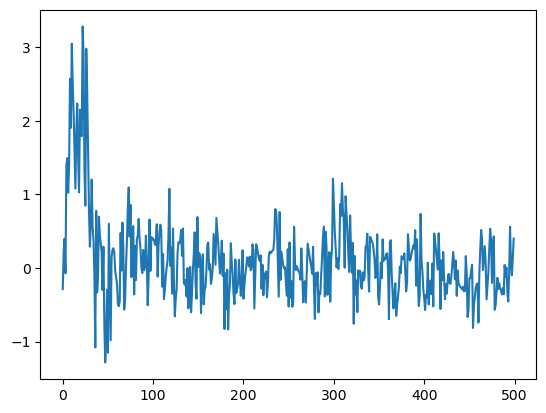

In [537]:
plt.plot(f[10000:10500])

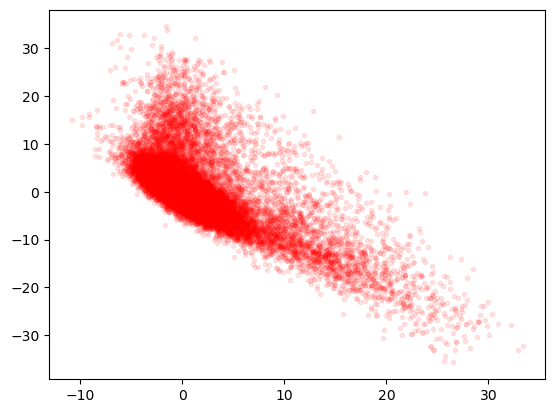

In [542]:

#f = (f[10+offset:]-F0s[cell_to_predict]- (f0s+amplitudes_pred_ridge))#/F0s[cell_to_predict]
f_start = np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same')[:-offset]
f_peak = np.convolve(f,np.ones([peak_length])/peak_length,mode = 'same')[offset:]
f_slope_matrix = BCI_analysis.io_suite2p.align_trace_to_event(np.asarray([f,f]),
                                                               np.arange(len(f)),
                                                              0,
                                                              slope_length)
                                                               # int(slope_length/2),
                                                               # int(slope_length/2))
Y_slopes = f_slope_matrix[:,0,:-offset].T
X_slopes = np.arange(slope_length)[np.newaxis,:]

slopes_all = (  np.nanmean(X_slopes*Y_slopes,axis=1) - np.nanmean(X_slopes)*np.nanmean(Y_slopes,axis=1)  ) / ((X_slopes**2).mean() - (X_slopes.mean())**2)
slopes_down = slopes_all.copy()
slopes_down[slopes_down>-10000] = 0
slopes_up = slopes_all.copy()
slopes_up[slopes_up<-10000] = 0
amplitudes = f_peak-f_start
f0s = f_start#-F0s[cell_to_predict]


slopes = slopes_all[10:]
slopes_up = slopes_up[10:]
slopes_down = slopes_down[10:]
amplitudes = amplitudes[10:]
f0s = f0s[10:]
plt.plot(f0s,amplitudes,'r.',alpha = .1)

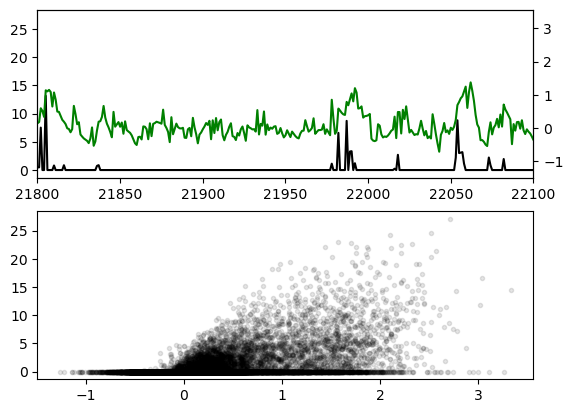

In [421]:
# compare oasis and my method
residual_trace = (f[10+offset:]-F0s[cell_to_predict]- (f0s+amplitudes_pred_ridge))/F0s[cell_to_predict]




spikes = spikes_matrix_ALL[session_i][needed_cells_with_activity[cell_to_predict]][10+offset:]

fig = plt.figure()
ax_spikes = fig.add_subplot(2,1,1)
ax_trace =  ax_spikes.twinx()
ax_spikes.plot(spikes,'k-')
ax_trace.plot(residual_trace,'g-')
ax_trace.set_xlim([21800,22100])

ax_corr = fig.add_subplot(2,1,2)
ax_corr.plot(residual_trace,spikes,'k.',alpha = .1)

(array([552., 358., 297., 201., 206., 145., 104.,  95.,  78.,  69.,  54.,
         49.,  38.,  24.,  29.,  32.,  26.,  15.,  19.,  10.,  14.,   7.,
          6.,  13.,  10.,   6.,   6.,   2.,   2.,   2.,   2.,   1.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75

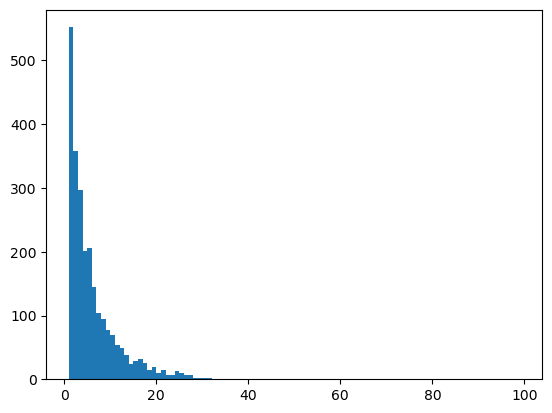

In [194]:
plt.hist(spikes,np.arange(1,100))

In [ ]:
# linear regression on the F0 of all cells to predict df of a selected cell
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.decomposition import PCA

session = sessions[0]
scalar_f0 = False
correct_offset = False
sample_only_at_photostim = False
n_random_groups_per_stimgroup_per_cell  = 50
session_dir = os.path.join(suite2p_dir_base,setup,subject,fov,session)
photostim_dir = os.path.join(session_dir,'photostim')
photostim_groups = np.load(os.path.join(photostim_dir,'photostim_groups.npy'),allow_pickle=True).tolist()
photostim_group_order = np.asarray(photostim_groups['group_order'])
dFF_photostim,F_photostim,F0_photostim,F0_scalar_photostim,Fneu_photostim = load_and_calculate_dff(photostim_dir,
                                                                        scalar_f0 = scalar_f0,
                                                                        photostim = True,
                                                                        correct_offset = correct_offset)
ops =  np.load(os.path.join(photostim_dir,'ops.npy'),allow_pickle = True).tolist()
photostim_indices = np.concatenate([[0],np.cumsum(ops['frames_per_file'])])[:-1]


F_photostim_aligned = BCI_analysis.io_suite2p.align_trace_to_event(F_photostim,
                                                                   photostim_indices,
                                                                   step_back,
                                                                   step_forward)




cell_to_predict = 14#33

slope_len = 3

F_matrix = F_photostim[needed_cells_with_activity,:]
F0s = np.asarray(photostim_data_dict[session]['fitted_f0'])
#####F0s[cell_to_predict] -=10
F_photostim_aligned = F_photostim_aligned[:,needed_cells_with_activity,:] - F0s[np.newaxis,:,np.newaxis]
F_start_matrix = []
F_peak_matrix = []
F_slope_matrix = []
for f in F_matrix:
    F_start_matrix.append(np.convolve(f,np.ones([baseline_length])/baseline_length,mode = 'same'))
    F_peak_matrix.append(np.convolve(f,np.ones([baseline_length])/peak_length,mode = 'same'))
    
    f_for_slope = np.convolve(f,np.ones([slope_len])/slope_len,mode = 'same')
    f_for_slope = np.concatenate([[f_for_slope[0]],f_for_slope,[f_for_slope[-1]]])
    f_slope = np.zeros_like(f)
    f_slope[0::2] = np.diff(f_for_slope[0::2])
    f_slope[1::2] = np.diff(f_for_slope[1::2])
    F_slope_matrix.append(f_slope)
    
F_start_matrix = np.asarray(F_start_matrix)
F_peak_matrix = np.asarray(F_peak_matrix)
F_slope_matrix = np.asarray(F_slope_matrix)                          
                      
f0_matrix = F_start_matrix[:,:-offset]
f_slope_matrix = F_slope_matrix[:,:-offset]
f1_matrix = F_start_matrix[:,offset:]
amplitudes_matrix = f1_matrix-f0_matrix
amplitudes = amplitudes_matrix[cell_to_predict,:]
f0s = f0_matrix[cell_to_predict,:]
f0_matrix =  f0_matrix -F0s[:,np.newaxis]


X = f0_matrix.T#np.concatenate([f0_matrix,f_slope_matrix]).T #f0_matrix.T

y = amplitudes


# clf = Ridge(alpha=1.0)
# clf.fit(f0_matrix.T, amplitudes)
reg = LassoCV(cv=5, random_state=0).fit(X, y)
reg.score(X,y)

clf = RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X, y)
clf.score(X, y)




amplitudes_pred_ridge = clf.predict(X)
amplitudes_pred_lasso = reg.predict(X)

amplitudes_corr_ridge = amplitudes-amplitudes_pred_ridge
amplitudes_corr_lasso = amplitudes-amplitudes_pred_lasso

corrected_group_amplitudes_all_ridge  = []
corrected_group_amplitudes_all_lasso  = []
group_amplitudes_all= []
group_f0s_all= []

mean_corrected_group_amplitudes_all_ridge  = []
mean_corrected_group_amplitudes_all_lasso  = []
mean_group_amplitudes_all= []
mean_group_f0s_all= []


group_mean_amplitudes_random_corrected_ridge= []
group_mean_amplitudes_random_corrected_lasso= []
group_mean_amplitudes_random= []
group_mean_f0s_random= []

for group_idx in range(len(photostim_groups['groups'])):
    F_now = F_photostim_aligned[:,cell_to_predict,photostim_group_order==group_idx]
    repeats = F_now.shape[1]
    group_stim_F0s = np.nanmean(F_now[baseline_offset:baseline_offset+baseline_length,:],0)  +  F0s[cell_to_predict]
    group_stim_Fpeaks = np.nanmean(F_now[step_back+peak_offset:step_back+peak_offset+peak_length,:],0) +  F0s[cell_to_predict]
    group_amplitudes = group_stim_Fpeaks-group_stim_F0s

    group_f0_matrix = np.nanmean(F_photostim_aligned[baseline_offset:baseline_offset+baseline_length,:,photostim_group_order==group_idx],0)
    group_f0_matrix[np.isnan(group_f0_matrix)]= 100#np.nanmean(group_f0_matrix)

    group_correction_ridge = -1*clf.predict(group_f0_matrix.T)
    group_correction_lasso = -1*reg.predict(group_f0_matrix.T)

    #(group_stim_F0s-p[1])/timeConstant*(offset_photostim/offset) #

    corrected_group_amplitudes_ridge = group_correction_ridge+ group_amplitudes
    corrected_group_amplitudes_lasso = group_correction_lasso+ group_amplitudes
    
    corrected_group_amplitudes_all_lasso.append(corrected_group_amplitudes_lasso)
    corrected_group_amplitudes_all_ridge.append(corrected_group_amplitudes_ridge)
    
    group_amplitudes_all.append(group_amplitudes)
    group_f0s_all.append(group_stim_F0s)
    
    
    mean_corrected_group_amplitudes_all_lasso.append(np.nanmean(corrected_group_amplitudes_lasso))
    mean_corrected_group_amplitudes_all_ridge.append(np.nanmean(corrected_group_amplitudes_ridge))
    
    mean_group_amplitudes_all.append(np.nanmean(group_amplitudes))
    mean_group_f0s_all.append(np.nanmean(group_stim_F0s))
    


for group_idx in range(len(photostim_groups['groups'])):# sample photostim amplitudes for the mock distribution of amplitudes
    repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
    mean_amplitudes_corrected_ridge = []
    mean_amplitudes_corrected_lasso = []
    mean_amplitudes = []
    mean_f0s = []

    gaa = np.concatenate(group_amplitudes_all)
    cgaar = np.concatenate(corrected_group_amplitudes_all_ridge)
    cgaal = np.concatenate(corrected_group_amplitudes_all_lasso)
    gf0 = np.concatenate(group_f0s_all)
    for i in range(n_random_groups_per_stimgroup_per_cell):
        if sample_only_at_photostim:
            random_indices = np.random.choice(range(len(gaa)),repeats)
            
            mean_amplitudes_corrected_ridge.append(np.nanmean(cgaar[random_indices]))
            mean_amplitudes_corrected_lasso.append(np.nanmean(cgaal[random_indices]))
            
            mean_amplitudes.append(np.nanmean(gaa[random_indices]))
            mean_f0s.append(np.nanmean(gf0[random_indices]))
        else:
            random_indices = np.random.choice(range(len(amplitudes)),repeats)
            
            mean_amplitudes_corrected_ridge.append(np.nanmean(amplitudes_corr_ridge[random_indices]))
            mean_amplitudes_corrected_lasso.append(np.nanmean(amplitudes_corr_lasso[random_indices]))
            
            mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
            mean_f0s.append(np.nanmean(f0s[random_indices]))

    group_mean_amplitudes_random_corrected_ridge.append(mean_amplitudes_corrected_ridge)
    group_mean_amplitudes_random_corrected_lasso.append(mean_amplitudes_corrected_lasso)
    group_mean_amplitudes_random.append(mean_amplitudes)
    group_mean_f0s_random.append(mean_f0s)










In [ ]:
import scipy
fig = plt.figure(figsize = [20,10])
ax_trace = fig.add_subplot(3,2,1)
ax_trace.plot(f0_matrix[cell_to_predict,:]+amplitudes,'k-',label = 'real trace')
ax_trace.plot(f0_matrix[cell_to_predict,:]+amplitudes_pred_lasso,'c--',label = 'predicted trace (lasso)',alpha = .5)
ax_trace.plot(f0_matrix[cell_to_predict,:]+amplitudes_pred_ridge,'r-',label = 'predicted trace (ridge)',alpha = .5)
ax_trace.plot(photostim_indices,np.zeros_like(photostim_indices),'b.')
ax_trace.set_xlim([1000,2000])
ax_trace.legend()


ax_coef = fig.add_subplot(3,2,2)
try:
    ax_coef.plot(reg.coef_/np.asarray(photostim_data_dict[session]['fitted_f0']*2),'c.',alpha = .5)#*2
    ax_coef.plot(clf.coef_/np.asarray(photostim_data_dict[session]['fitted_f0']*2),'r-',alpha = .5)#*2
except:
    ax_coef.plot(reg.coef_,'c.',alpha = .5)#/np.asarray(photostim_data_dict[session]['fitted_f0'])
    ax_coef.plot(clf.coef_,'r-',alpha = .5)#/np.asarray(photostim_data_dict[session]['fitted_f0'])
ax_coef.set_xlabel('cell f0 and slope')
ax_coef.set_ylabel('beta values normalized with F0')

#plt.plot(amplitudes,amplitudes_pred,'k.',alpha = .2)

ax_amplitude_vs_f0 = fig.add_subplot(3,2,3)
ax_amplitude_vs_f0.plot(f0_matrix[cell_to_predict,:],amplitudes,'k.',alpha = .1)
ax_amplitude_vs_f0.plot(f0_matrix[cell_to_predict,:],amplitudes-amplitudes_pred_lasso,'c.' ,alpha = .1)
ax_amplitude_vs_f0.set_xlabel('f0')
ax_amplitude_vs_f0.set_ylabel('df')
ax_amplitude_vs_f0.set_title('lasso score: {:.3f}'.format(reg.score(X,y)))

ax_amplitude_vs_f0 = fig.add_subplot(3,2,4,sharex = ax_amplitude_vs_f0, sharey = ax_amplitude_vs_f0)
ax_amplitude_vs_f0.plot(f0_matrix[cell_to_predict,:],amplitudes,'k.',alpha = .1)
ax_amplitude_vs_f0.plot(f0_matrix[cell_to_predict,:],amplitudes-amplitudes_pred_ridge,'r.',alpha = .1)
ax_amplitude_vs_f0.set_xlabel('f0')
ax_amplitude_vs_f0.set_ylabel('df')
ax_amplitude_vs_f0.set_title('ridge score: {:.3f}'.format(clf.score(X,y)))

ax_amplitude_vs_f0 = fig.add_subplot(3,2,5,sharex = ax_amplitude_vs_f0, sharey = ax_amplitude_vs_f0)
#ax_amplitude_vs_f0.plot(f0_matrix[cell_to_predict,:],amplitudes-amplitudes_pred_lasso,'c.' ,alpha = .1)
ax_amplitude_vs_f0.plot(f0_matrix[cell_to_predict,:],amplitudes-amplitudes_pred_ridge-(amplitudes-amplitudes_pred_lasso),'r.',alpha = .1)
ax_amplitude_vs_f0.set_xlabel('f0')
ax_amplitude_vs_f0.set_ylabel('df')
ax_amplitude_vs_f0.set_title('ridge - lasso')

ax_hist = fig.add_subplot(3,2,6)
ax_hist.hist(amplitudes_corr_ridge,100)
modeval = scipy.stats.mode(np.round(amplitudes_corr_ridge,1))
ax_hist.set_title(modeval.mode[0])

fig = plt.figure(figsize = [20,10])
ax_mean_amplitudes_uncorrected = fig.add_subplot(2,3,1)
ax_mean_amplitudes_uncorrected.plot(np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random),'k.',alpha = .1)
ax_mean_amplitudes_uncorrected.plot(mean_group_f0s_all,mean_group_amplitudes_all,'r.',alpha = 1)

ax_mean_amplitudes_ridge = fig.add_subplot(2,3,2)
ax_mean_amplitudes_ridge.plot(np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected_ridge),'k.',alpha = .1)
ax_mean_amplitudes_ridge.plot(mean_group_f0s_all,mean_corrected_group_amplitudes_all_ridge,'r.',alpha = 1)


ax_mean_amplitudes_lasso = fig.add_subplot(2,3,3)
ax_mean_amplitudes_lasso.plot(np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected_lasso),'k.',alpha = .1)
ax_mean_amplitudes_lasso.plot(mean_group_f0s_all,mean_corrected_group_amplitudes_all_lasso,'r.',alpha = 1)

ax_mean_amplitudes_uncorrected_hist = fig.add_subplot(2,3,4)
hist_range = [np.nanmin(np.concatenate([np.concatenate(group_mean_amplitudes_random),mean_group_amplitudes_all])),
                  np.nanmax(np.concatenate([np.concatenate(group_mean_amplitudes_random),mean_group_amplitudes_all]))]
y,x = np.histogram(np.concatenate(group_mean_amplitudes_random),bins = 500,range = hist_range)
y_stim,xx = np.histogram(mean_group_amplitudes_all,x)
x = np.mean([x[:-1],x[1:]],0)
pdf_y = np.cumsum(y)/np.sum(y)

pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
# ax_hist_2 = ax_hist.twinx()
# ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
ax_mean_amplitudes_uncorrected_hist.plot(x,pdf_y,'k-')
ax_mean_amplitudes_uncorrected_hist.plot(x,pdf_y_stim,'r-')



ax_mean_amplitudes_ridge_hist = fig.add_subplot(2,3,5)
hist_range = [np.nanmin(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_ridge),mean_corrected_group_amplitudes_all_ridge])),
                  np.nanmax(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_ridge),mean_corrected_group_amplitudes_all_ridge]))]
y_,x_ = np.histogram(np.concatenate(group_mean_amplitudes_random_corrected_ridge),bins = 500,range = hist_range)
y_stim,xx_ = np.histogram(mean_corrected_group_amplitudes_all_ridge,x_)
x_ = np.mean([x_[:-1],x_[1:]],0)
pdf_y = np.cumsum(y_)/np.sum(y_)

pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
# ax_hist_2 = ax_hist.twinx()
# ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
ax_mean_amplitudes_ridge_hist.plot(x_,pdf_y,'k-')
ax_mean_amplitudes_ridge_hist.plot(x_,pdf_y_stim,'r-')


ax_mean_amplitudes_lasso_hist = fig.add_subplot(2,3,6)
hist_range = [np.nanmin(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_lasso),mean_corrected_group_amplitudes_all_lasso])),
                  np.nanmax(np.concatenate([np.concatenate(group_mean_amplitudes_random_corrected_lasso),mean_corrected_group_amplitudes_all_lasso]))]
y_,x_ = np.histogram(np.concatenate(group_mean_amplitudes_random_corrected_lasso),bins = 500,range = hist_range)
y_stim,xx_ = np.histogram(mean_corrected_group_amplitudes_all_lasso,x_)
x_ = np.mean([x[:-1],x[1:]],0)
pdf_y = np.cumsum(y_)/np.sum(y_)

pdf_y_stim = np.cumsum(y_stim)/np.sum(y_stim)
# ax_hist_2 = ax_hist.twinx()
# ax_hist_2.hist(np.concatenate(photostim_data_dict[session]['dF_corr'][cell_i]))
ax_mean_amplitudes_lasso_hist.plot(x,pdf_y,'k-')
ax_mean_amplitudes_lasso_hist.plot(x,pdf_y_stim,'r-')


# ax_mean_amplitudes_uncorrected_hist.hist(np.concatenate(group_mean_amplitudes_random),100)
# ax_mean_amplitudes_uncorrected_hist.hist(mean_group_amplitudes_all,100)

In [ ]:
# MARADVANYSCRIPT - valszeg mar sosem kell ezt beleztem ki az alabbi scriptbol

amplitudes_ = fpeak[offset:]-f0[:-offset]
        f0s_ = f0[:-offset]
        taus_bootstrap = []
        f0_bootstrap = []
        for bootstrap_i in range(bootstrap_n):
            indices = random.sample(list(np.arange(len(amplitudes_))),int(len(amplitudes_)*bootstrap_r))
            amplitudes = amplitudes_[indices]
            f0s = f0s_[indices]

            corrcoeff = 0
            diff_max_offset =0
            while corrcoeff <.975 and minimum_dff_max<dff_range[1]+diff_max_offset:
                x_range = np.percentile(f0s,[1,99])
                x_range[0] = np.max([F0*(dff_range[0]+1),x_range[0]])
                x_range[1] = np.min([F0*(dff_range[1]+diff_max_offset+1),x_range[1]])
                f0s_used = f0s[(f0s>x_range[0])&(f0s<x_range[1])]
                if x_range[0]>x_range[1] or len(f0s_used)<100:
                    break # we break out of this loop if there are no values in the range..


                bin_mean = []
                bin_center = []
                bin_std = []
                bin_n = []


                # lower_percentiles = 100*np.arange(bin_num)/bin_num
                # upper_percentiles = 100*np.arange(bin_num)/bin_num+1/bin_num

                for bin_i in np.arange(bin_num):
                    min_x_val = x_range[0]+bin_i*np.diff(x_range)/bin_num
                    max_x_val = x_range[0]+(bin_i+1)*np.diff(x_range)/bin_num
                    # min_x_val = np.percentile(f0s_used,lower_percentiles[bin_i])
                    # max_x_val = np.percentile(f0s_used,upper_percentiles[bin_i])


                    needed_idx = (f0s>min_x_val) & (f0s<max_x_val)
                    f0_now = f0s[needed_idx]
                    amplitudes_now = amplitudes[needed_idx]
                    amplitudes_now = amplitudes_now[np.isnan(amplitudes_now)==False]
                    while len(amplitudes_now)>10:
                        y,x = np.histogram(amplitudes_now,10)
                        x = np.nanmean([x[:-1],x[1:]],0)
                        range_now = (np.nanmax(amplitudes_now) - np.nanmin(amplitudes_now))/5
                        center_val = x[np.argmax(y)]
                        needed = (amplitudes_now>center_val-range_now) & (amplitudes_now<center_val+range_now)
                        amplitudes_now = amplitudes_now[needed]
                    n = len(needed_idx)
                    bin_center.append(np.nanmean(f0_now))
                    bin_mean.append(np.nanmean(amplitudes_now))
                    bin_std.append(0)
                    bin_n.append(n)
                    # if np.isnan(np.nanmean(f0_now)) or np.isnan(np.nanmean(amplitudes_now)):
                    #     adasd
                try:
                    p = np.polyfit(bin_mean,bin_center,1)
                except:
                    p = [0,0]
                    #print('could not fit')
                corrcoeff = -1*np.corrcoef(bin_mean,bin_center)[0,1]
                if corrcoeff<.975:
                    diff_max_offset-=.5
            needed_bin = (np.isnan(bin_center) == False) & (np.isnan(bin_mean) == False)

            pp =  np.polyfit(np.asarray(bin_center)[needed_bin],np.asarray(bin_mean)[needed_bin],1)
            m = pp[0]
            if (1+m)/1<0:
                tau_real = np.nan
            else:
                tau_real = (- 1*offset*.05)/(np.log((1+m)/1))
            f0_calc = p[1]
            taus_bootstrap.append(tau_real)
            f0_bootstrap.append(f0_calc)
        tau_real = np.nanmedian(taus_bootstrap)
        b = np.nanmedian(f0_bootstrap)
        g = np.exp((-1*0.05)/tau_real)
        

        if deconvolution_type == 'oasis':
                        
            g = oasis.functions.estimate_time_constant(F_trace,p=1,lags = 40)
            # c, s, b_, g_, lam = deconvolve(F_trace, penalty=1,g = g, b = b) # use the background estimate from Marton's way, and use the time constant from oasis
            # spikes_matrix.append(s)
            
            tau_real = (-.05)/np.log(g)[0]
         
        if correct_tau: # this one fine-tunes tau for each cell based on the distribution of expected amplitudes
            r_df_corr_vs_f0 = np.inf
            tau_candidates_ = []
            corrcoeffs_corrected_ = []
            corrcoeffs_ = []
            while np.abs(r_df_corr_vs_f0)>tau_corr_cutoff:
                g = np.exp((-1*0.05)/tau_real)

                amplitudes = fpeak[offset_tau:]-f0[:-offset_tau]
                f0s = f0[:-offset_tau]
                
                # needed_f0s = f0s>F0*1.5
                # amplitudes = amplitudes[needed_f0s]
                # f0s = f0s[needed_f0s]
                
                
                correction = f0s - (f0s-b)*(g**offset_tau) - b
                amplitudes_corrected = amplitudes+correction

                group_mean_amplitudes_random = []
                group_mean_amplitudes_random_corrected = []
                group_mean_f0s_random = []
                group_percentiles = []
                for group_idx in range(len(photostim_groups['groups'])):
                    repeats = sum(np.asarray(photostim_groups['group_order'])==group_idx)
                    mean_amplitudes_corrected = []
                    mean_amplitudes = []
                    mean_f0s = []
                    for i in range(n_random_groups_per_stimgroup_per_cell):
                        random_indices = random.sample(range(len(amplitudes_corrected)),repeats)
                        mean_amplitudes_corrected.append(np.nanmean(amplitudes_corrected[random_indices]))
                        mean_amplitudes.append(np.nanmean(amplitudes[random_indices]))
                        mean_f0s.append(np.nanmean(f0s[random_indices]))

                    group_mean_amplitudes_random_corrected.append(mean_amplitudes_corrected)
                    group_mean_amplitudes_random.append(mean_amplitudes)
                    group_mean_f0s_random.append(mean_f0s)
                r_df_vs_f0 = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random))[0][1]
                r_df_corr_vs_f0  = np.corrcoef( np.concatenate(group_mean_f0s_random),np.concatenate(group_mean_amplitudes_random_corrected))[0][1]
                tau_candidates_.append(tau_real)
                corrcoeffs_corrected_.append(r_df_corr_vs_f0)
                corrcoeffs_.append(r_df_vs_f0)
                if r_df_corr_vs_f0 > tau_corr_cutoff:
                    tau_real = tau_real*1.1
                elif r_df_corr_vs_f0 < -1*tau_corr_cutoff:
                    tau_real = tau_real*.9
            
            print('tau corrected in {} steps, from {:.3f} s to {:.3f} s'.format(len(tau_candidates_),tau_candidates_[0],tau_candidates_[-1]))
            # if tau_real<1:
            #     tau_real = 1
            g = np.exp((-1*0.05)/tau_real)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('default')

mu = 0
sigma = 200
x1 = -500
x2 = 500

# calculate the z-transform
z1 = ( x1 - mu ) / sigma
z2 = ( x2 - mu ) / sigma

x = np.arange(z1, z2, 0.001) # range of x in spec
x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
# mean = 0, stddev = 1, since Z-transform was calculated
y = norm.pdf(x,0,1)
y2 = norm.pdf(x_all,0,1)

# build the plot
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x*sigma,y/np.max(y))

plt.show()
x[np.argmax(y/np.max(y)>.5)]*sigma

In [ ]:
session_mean_images = np.load('/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/BCI_35/FOV_02/session_mean_images.npy',allow_pickle=True).tolist()
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10)
ax_im = plt.Axes(fig, [0., 0., 1., 1.])
ax_im.set_axis_off()
fig.add_axes(ax_im)
plt.axis('off')
plt.set_cmap('gray')
percentiles = [0,99.5]
for s in session_mean_images.keys():
    image = session_mean_images[s]['meanImg']
    im = ax_im.imshow(image,aspect = 'auto')
    im.set_clim(np.percentile(image.flatten(),percentiles))
    fig.savefig('BCI35-{}.jpg'.format(s),dpi = 300)
    #asdas
    

# Modeling

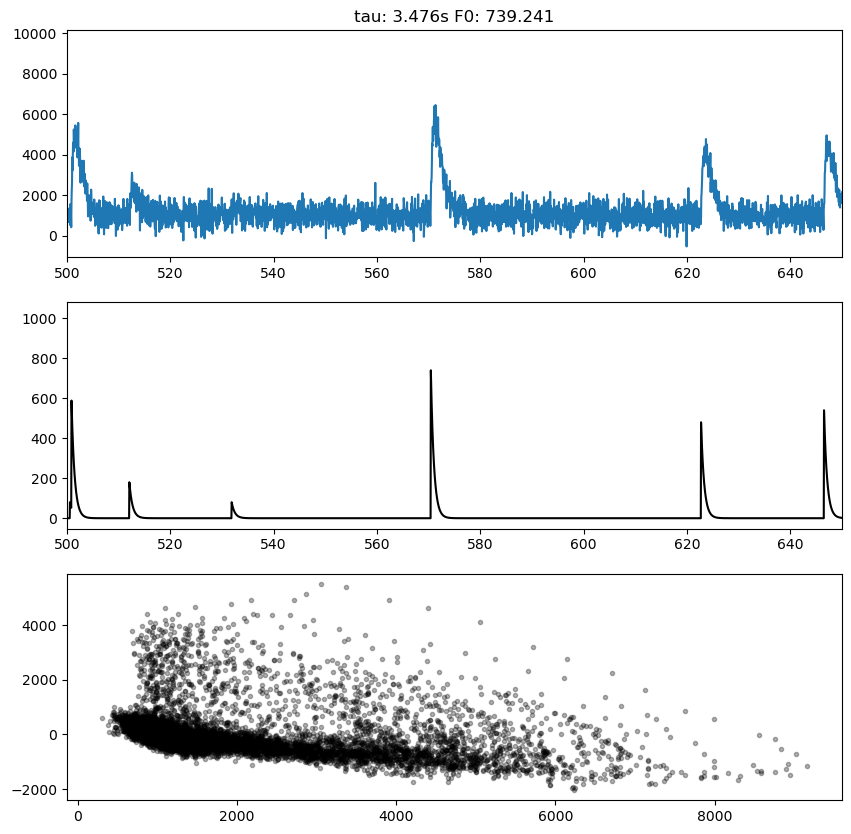

In [467]:
# play with modeled data - non-Poisson spiking is needed for slow decay times # load the functions first in below cells
from oasis.functions import gen_data

tau = 1.2 #s
g = [np.exp((-1*0.05)/tau)]
F0 = 1000
F_trace, true_c, true_s = map(np.squeeze, gen_data(N=1,
                                                   b=F0, 
                                                   seed=0,
                                                   g = g,
                                                   T = 15000,
                                                   framerate = 20,
                                                   firerate = .1,
                                                   sn = 400))


tau_calc,b_calc = calculate_f0_tau(F_trace,F0)
fig = plt.figure(figsize = [10,10])
ax_f = fig.add_subplot(3,1,1)
ax_f.plot(np.arange(len(F_trace))/20,F_trace)
ax_f.set_title('tau: {:.3f}s F0: {}'.format(tau_calc,round(b_calc,3)))
ax_s = fig.add_subplot(3,1,2,sharex = ax_f)
ax_s.plot(np.arange(len(F_trace))/20,true_s,'k-')
ax_s.set_xlim([500,650])
f0 = BCI_analysis.pipeline_utils.rollingfun(F_trace,baseline_length)
fpeak = BCI_analysis.pipeline_utils.rollingfun(F_trace,peak_length)
amplitudes = fpeak[offset:]-f0[:-offset]
f0s = f0[:-offset]
correction = f0s - (f0s-b)*(g[0]**offset) - b
amplitudes_corrected = amplitudes+correction

ax_ampl = fig.add_subplot(3,1,3)
ax_ampl.plot(f0s, amplitudes,'k.',alpha = .3)

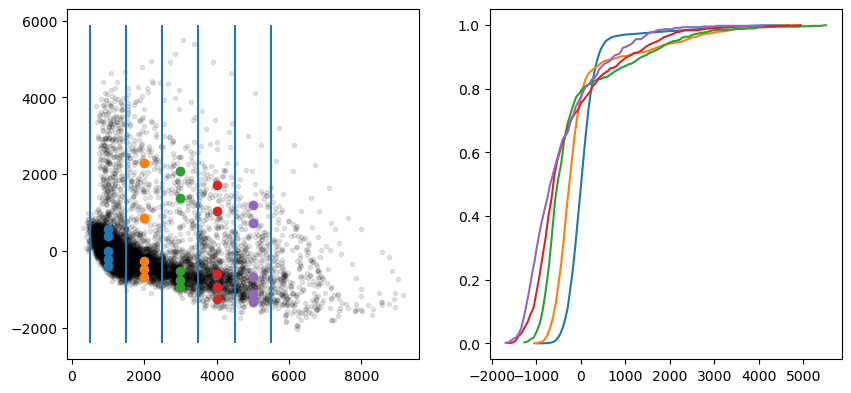

In [468]:
amplitudes_to_use = amplitudes#_corrected
percentiles_to_show = [5,20,50,90,95]
fig = plt.figure(figsize = [10,10])
ax_1 = fig.add_subplot(2,2,1)
ax_1.plot(f0s,amplitudes_to_use,'k.',alpha = .1)
ax_1.vlines(np.asarray([.5,1.5,2.5,3.5,4.5,5.5])*F0,ax_1.get_ylim()[0],ax_1.get_ylim()[1])

ax_2 = fig.add_subplot(2,2,2)

idx_base = (f0s<F0*1.5) &  (f0s>F0*.5)
y,x = np.histogram(amplitudes_to_use[idx_base],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))

ax_1.plot(np.ones(len(percentiles_to_show))*1*F0,np.percentile(amplitudes_to_use[idx_base],percentiles_to_show),'o')


idx_1 = (f0s<F0*2.5) &  (f0s>F0*1.5)
y,x = np.histogram(amplitudes_to_use[idx_1],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*2*F0,np.percentile(amplitudes_to_use[idx_1],percentiles_to_show),'o')



idx_2 = (f0s<F0*3.5) &  (f0s>F0*2.5)
y,x = np.histogram(amplitudes_to_use[idx_2],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*3*F0,np.percentile(amplitudes_to_use[idx_2],percentiles_to_show),'o')



idx_4 = (f0s<F0*4.5) &  (f0s>F0*3.5)
y,x = np.histogram(amplitudes_to_use[idx_4],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*4*F0,np.percentile(amplitudes_to_use[idx_4],percentiles_to_show),'o')


idx_5 = (f0s<F0*5.5) &  (f0s>F0*4.5)
y,x = np.histogram(amplitudes_to_use[idx_5],100)
ax_2.plot(x[1:],np.cumsum(y)/np.sum(y))
ax_1.plot(np.ones(len(percentiles_to_show))*5*F0,np.percentile(amplitudes_to_use[idx_5],percentiles_to_show),'o')

#ax_1.set_xlim([0,1900])

#ax_2.set_ylim([.9,1])